In [274]:
# export the environment
!conda env export --name sklearn > sklearn.yml

In [1]:
import os
import sys
import numpy as np
from itertools import repeat
#sys.path.insert(0, os.path.abspath('../module-subdirectory'))
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, plot_confusion_matrix

from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle
import matplotlib.pyplot as plt
import covid_data # ians py file in local directory
import covid_db_queries_new
import covid_db_get_data
import importlib
import seaborn as sns
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table, select, join
import pandas as pd

In [3]:
#importlib.reload(covid_db_get_data)

In [4]:
df_dict ={}
quant_range_dict = {}

In [5]:
covid_data.omics_id_dict.keys()

dict_keys(['proteomics', 'lipidomics', 'metabolomics', 'transcriptomics'])

In [6]:
ome_names = ['proteomics', 'lipidomics', 'metabolomics', 'transcriptomics']


In [128]:
for key in ome_names:
    print(key)
    df_dict[key], quant_range_dict[key] = covid_db_get_data.get_omics_data(with_metadata=True, dataset=key)

proteomics
lipidomics
metabolomics
transcriptomics


In [8]:
df_dict, quant_range_dict = covid_data.get_combined_data(df_dict, quant_range_dict)
dfc = df_dict['combined']
dfc_quantrange = quant_range_dict['combined']
df_dict['combined']

A0A024R6I7;A0A0G2JRN3  A0A075B6H9  A0A075B6I0  \
sample_id                                                  
1.0                    37.995543   27.176361   28.294477   
2.0                    37.353091   29.419228   29.048510   
3.0                    37.527875   27.174171   28.953215   
4.0                    37.673128   28.879702   29.527460   
5.0                    37.983542   27.262485   28.605867   
...                          ...         ...         ...   
124.0                  37.365447   27.133006   29.418182   
125.0                  37.564109   27.793462   29.003245   
126.0                  37.683884   26.876193   28.002763   
127.0                  37.282698   27.715091   28.660543   
128.0                  37.655909   26.965212   28.665092   

           A0A075B6I4;A0A1W2PQ80  A0A075B6I9  A0A075B6J1  A0A075B6J9  \
sample_id                                                              
1.0                    24.783368   23.926601   23.490571   25.490816   
2.0                    27.573331   24.671039   22.343591   27.166913   
3.0                    25.619161   24.528623   20.714471   25.589237   
4.0                    23.893562   25.875326   24.170967   25.280226   
5.0                    18.440251   20.888495   17.354782   25.654472   
...                          ...         ...         ...         ...   
124.0                  26.724164   24.374313   24.805480   27.039675   
125.0                  26.577443   25.152285   24.429947   26.009474   
126.0                  27.996742   24.717171   23.581184   26.701340   
127.0                  21.713502   25.369895   24.291863   26.368563   
128.0                  19.659693   25.790296   24.768906   26.011970   

           A0A075B6K4  A0A075B6K5  A0A075B6P5;P01615  ...  Vent_free_days  DM  \
sample_id                                             ...                       
1.0         29.287382   29.505121          29.909421  ...               0   0   
2.0         29.576452   30.081443          29.514012  ...              28   0   
3.0         29.621968   29.398338          29.436129  ...              28   1   
4.0         30.966780   30.360452          30.041791  ...              28   0   
5.0         29.020542   29.175695          29.628988  ...              23   0   
...               ...         ...                ...  ...             ...  ..   
124.0       31.051547   30.408517          30.913421  ...              28   1   
125.0       30.063940   30.478656          29.647462  ...              28   0   
126.0       29.526136   28.623103          29.150398  ...              28   0   
127.0       29.801532   30.820312          30.358148  ...              28   0   
128.0       31.428772   30.856381          30.221587  ...              28   0   

           Hospital_free_days_45  Ferritin_NG/ML  CRP_MG/L  DDIMER_mg/L_FEU  \
sample_id                                                                     
1.0                            0             946      73.1              1.3   
2.0                           39            1060                       1.03   
3.0                           18            1335      53.2             1.48   
4.0                           39             583     251.1             1.32   
5.0                           27             800     355.8             0.69   
...                          ...             ...       ...              ...   
124.0                         36             106                       1.46   
125.0                         43                      26.1                    
126.0                         40              85        41             1.87   
127.0                         43                                       0.19   
128.0                         44                                              

           Procalcitonin_NG/ML  Lactate_MMol/L  Fibrinogen  SOFA  
sample_id                                                         
1.0                         36             0.9         513     8  
2.0       

In [135]:
pickle.dump(df_dict,open( "df_dict.pickle", "wb" ))

In [9]:
len(df_dict['combined']['COVID']==1)

125

In [10]:
len(np.where(dfc['COVID']==1)[0])

100

In [11]:
len(np.where(dfc['COVID']==0)[0])

25

In [12]:
dfc_quantrange

17292

In [13]:
dfc_quant_cols = dfc.columns[:dfc_quantrange]
prefilter_range = len(dfc.columns)
dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='Unknown')))]
dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='unknown')))]
rangediff = prefilter_range - len(dfc.columns)
print( 'dropped columns = '+ str(rangediff))
dfc_quantrange_filtered = dfc_quantrange - rangediff

dropped columns = 2756


In [14]:
dfc.columns[:dfc_quantrange_filtered]

Index(['A0A024R6I7;A0A0G2JRN3', 'A0A075B6H9', 'A0A075B6I0',
       'A0A075B6I4;A0A1W2PQ80', 'A0A075B6I9', 'A0A075B6J1', 'A0A075B6J9',
       'A0A075B6K4', 'A0A075B6K5', 'A0A075B6P5;P01615',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=14536)

In [15]:
dfc

A0A024R6I7;A0A0G2JRN3  A0A075B6H9  A0A075B6I0  \
sample_id                                                  
1.0                    37.995543   27.176361   28.294477   
2.0                    37.353091   29.419228   29.048510   
3.0                    37.527875   27.174171   28.953215   
4.0                    37.673128   28.879702   29.527460   
5.0                    37.983542   27.262485   28.605867   
...                          ...         ...         ...   
124.0                  37.365447   27.133006   29.418182   
125.0                  37.564109   27.793462   29.003245   
126.0                  37.683884   26.876193   28.002763   
127.0                  37.282698   27.715091   28.660543   
128.0                  37.655909   26.965212   28.665092   

           A0A075B6I4;A0A1W2PQ80  A0A075B6I9  A0A075B6J1  A0A075B6J9  \
sample_id                                                              
1.0                    24.783368   23.926601   23.490571   25.490816   
2.0                    27.573331   24.671039   22.343591   27.166913   
3.0                    25.619161   24.528623   20.714471   25.589237   
4.0                    23.893562   25.875326   24.170967   25.280226   
5.0                    18.440251   20.888495   17.354782   25.654472   
...                          ...         ...         ...         ...   
124.0                  26.724164   24.374313   24.805480   27.039675   
125.0                  26.577443   25.152285   24.429947   26.009474   
126.0                  27.996742   24.717171   23.581184   26.701340   
127.0                  21.713502   25.369895   24.291863   26.368563   
128.0                  19.659693   25.790296   24.768906   26.011970   

           A0A075B6K4  A0A075B6K5  A0A075B6P5;P01615  ...  Vent_free_days  DM  \
sample_id                                             ...                       
1.0         29.287382   29.505121          29.909421  ...               0   0   
2.0         29.576452   30.081443          29.514012  ...              28   0   
3.0         29.621968   29.398338          29.436129  ...              28   1   
4.0         30.966780   30.360452          30.041791  ...              28   0   
5.0         29.020542   29.175695          29.628988  ...              23   0   
...               ...         ...                ...  ...             ...  ..   
124.0       31.051547   30.408517          30.913421  ...              28   1   
125.0       30.063940   30.478656          29.647462  ...              28   0   
126.0       29.526136   28.623103          29.150398  ...              28   0   
127.0       29.801532   30.820312          30.358148  ...              28   0   
128.0       31.428772   30.856381          30.221587  ...              28   0   

           Hospital_free_days_45  Ferritin_NG/ML  CRP_MG/L  DDIMER_mg/L_FEU  \
sample_id                                                                     
1.0                            0             946      73.1              1.3   
2.0                           39            1060                       1.03   
3.0                           18            1335      53.2             1.48   
4.0                           39             583     251.1             1.32   
5.0                           27             800     355.8             0.69   
...                          ...             ...       ...              ...   
124.0                         36             106                       1.46   
125.0                         43                      26.1                    
126.0                         40              85        41             1.87   
127.0                         43                                       0.19   
128.0                         44                                              

           Procalcitonin_NG/ML  Lactate_MMol/L  Fibrinogen  SOFA  
sample_id                                                         
1.0                         36             0.9         513     8  
2.0       

In [16]:
dfc['COVID'].iloc[np.where(dfc['COVID']=='')] = 1

In [18]:
dfc_covid = dfc[dfc['COVID']==1]
dfc_quant_cols = dfc.columns[:dfc_quantrange_filtered]
X = dfc_covid[dfc_quant_cols]

(array([29.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 71.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

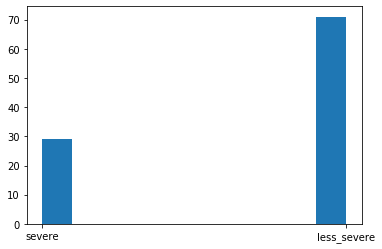

In [19]:
dfc_covid = dfc_covid.assign(dayclass=np.zeros(len(dfc_covid)))
dfc_covid.loc[dfc_covid['Hospital_free_days_45']<1, 'dayclass'] = 'severe'
dfc_covid.loc[dfc_covid['Hospital_free_days_45']>=1, 'dayclass'] = 'less_severe'
plt.hist(dfc_covid['dayclass'])

In [20]:
X

A0A024R6I7;A0A0G2JRN3  A0A075B6H9  A0A075B6I0  \
sample_id                                                  
1.0                    37.995543   27.176361   28.294477   
2.0                    37.353091   29.419228   29.048510   
3.0                    37.527875   27.174171   28.953215   
4.0                    37.673128   28.879702   29.527460   
5.0                    37.983542   27.262485   28.605867   
...                          ...         ...         ...   
99.0                   37.687017   29.417680   30.854747   
100.0                  37.787556   26.969061   28.103146   
101.0                  37.068980   32.415410   28.430139   
102.0                  38.004675   26.636994   28.346803   
103.0                  38.318576   27.799589   25.861147   

           A0A075B6I4;A0A1W2PQ80  A0A075B6I9  A0A075B6J1  A0A075B6J9  \
sample_id                                                              
1.0                    24.783368   23.926601   23.490571   25.490816   
2.0                    27.573331   24.671039   22.343591   27.166913   
3.0                    25.619161   24.528623   20.714471   25.589237   
4.0                    23.893562   25.875326   24.170967   25.280226   
5.0                    18.440251   20.888495   17.354782   25.654472   
...                          ...         ...         ...         ...   
99.0                   25.202957   26.348830   25.365263   24.867641   
100.0                  26.583481   25.303093   20.852103   25.527788   
101.0                  26.307425   26.740082   23.796498   26.716858   
102.0                  26.662073   25.585918   24.429053   26.073349   
103.0                  24.551744   25.732650   18.872135   26.311449   

           A0A075B6K4  A0A075B6K5  A0A075B6P5;P01615  ...  ZWILCH  ZWINT  \
sample_id                                             ...                  
1.0         29.287382   29.505121          29.909421  ...     6.9    6.4   
2.0         29.576452   30.081443          29.514012  ...     7.4    8.1   
3.0         29.621968   29.398338          29.436129  ...     6.5    6.7   
4.0         30.966780   30.360452          30.041791  ...     7.2    6.9   
5.0         29.020542   29.175695          29.628988  ...     6.8    7.3   
...               ...         ...                ...  ...     ...    ...   
99.0        31.974151   32.190635          30.303998  ...     5.4    6.8   
100.0       28.278393   29.567178          29.739326  ...     6.3    7.3   
101.0       30.895548   30.786904          31.184766  ...     7.0    7.0   
102.0       29.878007   29.607049          29.886157  ...     7.2    6.3   
103.0       30.829414   28.647359          30.121764  ...     6.3    6.9   

           ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B   ZYX  ZZEF1  ZZZ3  
sample_id                                                       
1.0         6.0   6.9   9.6     1.9     9.8  13.3   11.5   9.0  
2.0         5.5   6.5   9.7     3.1     9.9  13.5   11.3   8.5  
3.0         4.4   5.3  10.4     4.5     9.3  14.2   11.8   7.8  
4.0         6.4   7.2   9.5     3.6     9.6  12.3   11.0   9.0  
5.0         5.0   6.1   9.6     2.8    10.1  13.6   11.1   8.6  
...         ...   ...   ...     ...     ...   ...    ...   ...  
99.0        4.2   5.0  10.2     3.8     9.4  15.5   10.5   6.9  
100.0       5.0   6.4   9.8     3.5     9.2  14.3   10.0   8.0  
101.0       5.4   7.6   9.6     3.9     8.7  13.3   10.6   8.6  
102.0       5.8   6.5   9.7     3.5     9.9  14.7   11.5   8.7  
103.0       4.1   5.5  10.3     2.8     9.3  15.6   10.4   7.6  

[100 rows x 14536 columns]

In [21]:
y = dfc_covid['dayclass']
hfd = dfc_covid['Hospital_free_days_45']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_valid, hfd_train, hfd_valid = train_test_split(X, hfd, test_size = 0.2, random_state = 42)
X_train

A0A024R6I7;A0A0G2JRN3  A0A075B6H9  A0A075B6I0  \
sample_id                                                  
57.0                   36.793019   28.284980   30.121393   
92.0                   37.117973   27.828688   28.693818   
27.0                   37.791018   27.476224   30.303127   
43.0                   37.327053   27.871559   27.277462   
71.0                   37.797556   28.069072   29.144284   
...                          ...         ...         ...   
62.0                   38.008802   27.964165   29.517320   
73.0                   36.934625   27.931963   28.414377   
15.0                   37.532309   27.844757   28.512618   
96.0                   36.704965   28.605549   25.719967   
52.0                   37.652374   27.574848   27.249976   

           A0A075B6I4;A0A1W2PQ80  A0A075B6I9  A0A075B6J1  A0A075B6J9  \
sample_id                                                              
57.0                   22.534160   25.414256   23.787359   26.466362   
92.0                   26.102775   25.594999   23.707567   27.247533   
27.0                   19.800324   26.131457   19.456747   27.353381   
43.0                   25.714894   25.417736   23.319896   26.259256   
71.0                   19.710678   24.250247   24.755776   25.401682   
...                          ...         ...         ...         ...   
62.0                   24.800798   24.060769   24.850670   26.528042   
73.0                   24.583367   26.983811   20.834402   26.192366   
15.0                   24.842541   26.954713   24.264348   26.230007   
96.0                   23.779666   26.306052   22.671805   25.526087   
52.0                   19.455385   23.217917   23.113879   18.635862   

           A0A075B6K4  A0A075B6K5  A0A075B6P5;P01615  ...  ZWILCH  ZWINT  \
sample_id                                             ...                  
57.0        30.877963   30.062654          30.154726  ...     7.2    7.6   
92.0        31.035709   31.022475          30.138217  ...     6.8    8.1   
27.0        29.806535   31.065353          30.428023  ...     7.5    8.2   
43.0        31.865923   29.921673          29.771245  ...     6.6    7.4   
71.0        30.739165   30.842361          30.720858  ...     7.6    8.5   
...               ...         ...                ...  ...     ...    ...   
62.0        30.245925   30.305412          30.417398  ...     7.0    7.5   
73.0        30.796761   30.074314          30.363902  ...     7.2    5.6   
15.0        31.087272   31.420463          31.409934  ...     6.5    6.3   
96.0        31.268075   29.748808          30.919969  ...     5.6    5.2   
52.0        29.232996   29.087196          29.365363  ...     5.8    4.6   

           ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B   ZYX  ZZEF1  ZZZ3  
sample_id                                                       
57.0        6.0   7.6   9.6     2.9     9.2  12.8   11.4   9.2  
92.0        4.2   6.1   9.8     3.7     9.3  14.4   11.0   8.1  
27.0        4.4   6.2   9.9     3.8     9.7  13.3   11.0   8.3  
43.0        3.6   4.2  10.5     4.6     9.4  14.9   10.9   7.0  
71.0        4.0   6.2   9.9     3.6    10.0  13.9   10.8   8.2  
...         ...   ...   ...     ...     ...   ...    ...   ...  
62.0        5.4   7.1   9.8     2.7     9.1  13.2   10.7   8.5  
73.0        6.7   7.7   9.6     2.4     9.3  12.6   11.2   9.3  
15.0        5.4   6.8  10.1     3.9    10.6  13.5   12.0   8.2  
96.0        5.8   6.6   9.4     4.8     9.0  14.4    9.6   7.4  
52.0        5.3   5.8  10.4     1.8     9.6  14.0   11.0   7.4  

[80 rows x 14536 columns]

In [28]:
et = ExtraTreesClassifier()
et.fit(X_train, y_train)
y_pred = et.predict(X_valid)
y_score = et.predict_proba(X_valid)

In [31]:
y_score[:,1]

array([0.07, 0.5 , 0.16, 0.14, 0.45, 0.36, 0.63, 0.19, 0.03, 0.23, 0.07,
       0.38, 0.26, 0.07, 0.1 , 0.44, 0.48, 0.06, 0.06, 0.34])

In [30]:
et.classes_

array(['less_severe', 'severe'], dtype=object)

accuracy:  0.70, recall: 0.00, precision: 0.00, f1: 0.00, ave_prec: 0.41


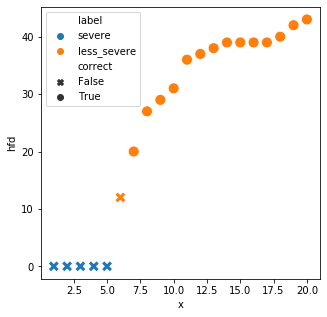

In [32]:

day_order_index = np.argsort(hfd_valid.values)
correct = y_valid == y_pred
print('accuracy: %5.2f, recall: %3.2f, precision: %3.2f, f1: %3.2f, ave_prec: %3.2f' % (accuracy_score(y_valid, y_pred), 
                                                           recall_score(y_valid, y_pred, pos_label='severe'),
                                                           precision_score(y_valid, y_pred, pos_label='severe'),
                                                           f1_score(y_valid, y_pred, pos_label='severe'),
                                                            average_precision_score(y_valid, y_score[:,1], pos_label='severe'))
     )

plot_df = pd.DataFrame({'hfd':hfd_valid.iloc[day_order_index], 
              'x':np.arange(1, len(y_valid)+1,1), 
              'label':y_valid.iloc[day_order_index],
              'correct':correct.iloc[day_order_index]})
plt.rcParams['figure.figsize']= 5,5
MARKERS = {True:"s",False:'X'}
sns.scatterplot('x', 'hfd', data=plot_df, hue='label', style='correct', markers={True:"o",False:'X'}, s=120)
plt.show()

In [38]:
et.classes_

array(['less_severe', 'severe'], dtype=object)

In [37]:
roc_auc_score(y_valid, y_score[:,1])

0.7066666666666667

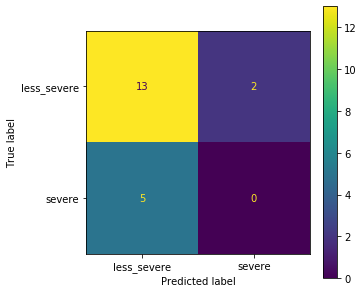

In [24]:
plot_confusion_matrix(et, X_valid, y_valid)

In [25]:
def compare_cutoffs_kfold(plot=True):
    accuracies = []
    recalls = []
    precisions = []
    metric_means = []
    day_thresh = []
    RANDOM_SEED = 11
    for i in range(1,35):
        
        DAY_CUTOFF = i
        print('day cutoff'+str(DAY_CUTOFF))
        df = dfc[dfc['COVID']==1]
        #df = dfc
        X = df[dfc.columns[:dfc_quantrange_filtered]]
        df = df.assign(dayclass=np.zeros(len(df)))
        df.loc[df['Hospital_free_days_45']<DAY_CUTOFF, 'dayclass'] = 'severe'
        df.loc[df['Hospital_free_days_45']>=DAY_CUTOFF, 'dayclass'] = 'less_severe'
        y = df['dayclass']
        hfd = df['Hospital_free_days_45']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
        X_train, X_test, hfd_train, hfd_test = train_test_split(X, hfd, test_size = 0.2, random_state = RANDOM_SEED)
        xa = np.asarray(X_train)
        ya = np.asarray(y_train)
        ha = np.asarray(hfd_train)
        
        
        fold=0
        kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
        
        for train_index, test_index in kf.split(xa):
            print('fold= '+str(fold))
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_val = xa[train_index], xa[test_index]
            y_train, y_val = ya[train_index], ya[test_index]
            h_train, h_val = ha[train_index], ha[test_index]
            et = ExtraTreesClassifier(random_state=RANDOM_SEED)
            et.fit(X_train, y_train)
            y_pred = et.predict(X_val)
            accuracies.append(accuracy_score(y_val, y_pred))
            recalls.append(recall_score(y_val, y_pred, pos_label='severe'))
            precisions.append(precision_score(y_val, y_pred, pos_label='severe'))
            metric_means.append(np.mean([accuracies[-1], recalls[-1], precisions[-1]]))
            day_thresh.append(i)
            #print(h_val)
            day_order_index = np.argsort(h_val)
            correct = y_val == y_pred
            print('accuracy: %5.2f, recall: %3.2f, precision: %3.2f, metric means: %3.2f' % (accuracies[-1], 
                                                                       recalls[-1],
                                                                       precisions[-1],
                                                                       metric_means[-1])
                 )
            if(plot):
                plot_df = pd.DataFrame({'hfd':h_val[day_order_index], 
                              'x':np.arange(1, len(y_val)+1,1), 
                              'label':y_val[day_order_index],
                              'correct':correct[day_order_index]})
                plt.rcParams['figure.figsize']= 5,5
                MARKERS = {True:"s",False:'X'}
                sns.scatterplot('x', 'hfd', data=plot_df, hue='label', style='correct', markers={True:"o",False:'X'}, s=120)
                plt.show()
            fold+=1
    return accuracies, recalls, precisions, metric_means, day_thresh

day cutoff1
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


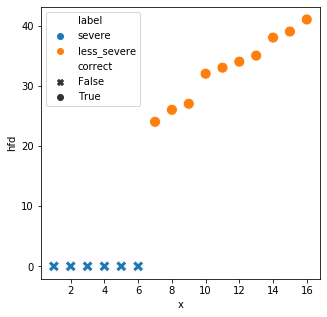

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


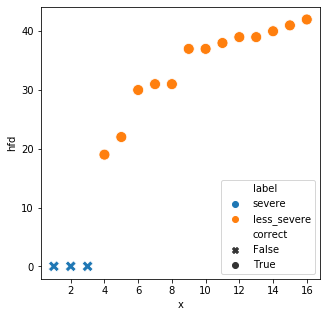

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


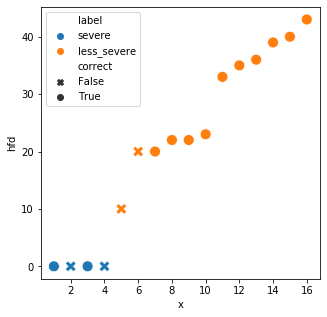

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


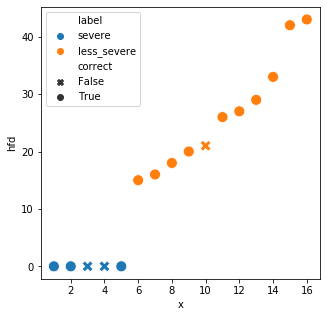

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


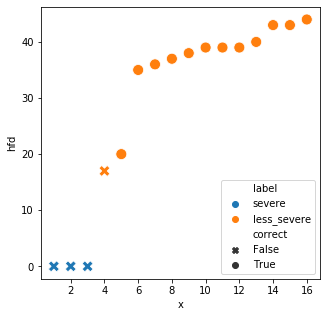

day cutoff2
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


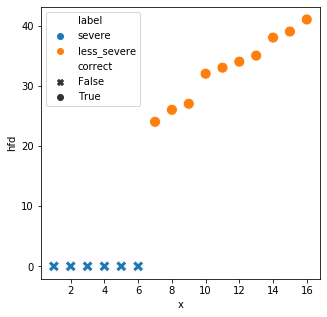

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


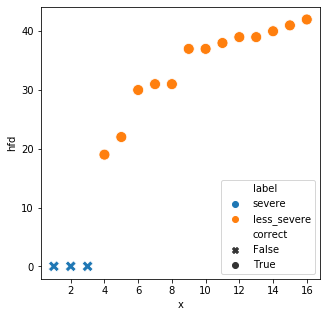

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


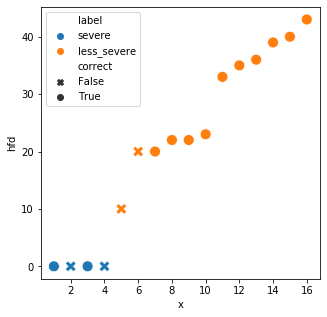

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


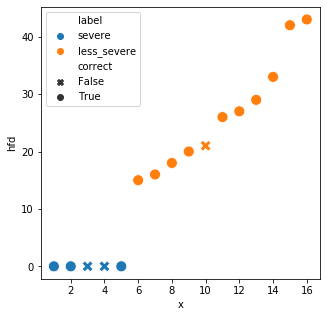

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


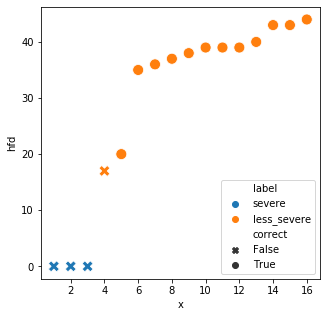

day cutoff3
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


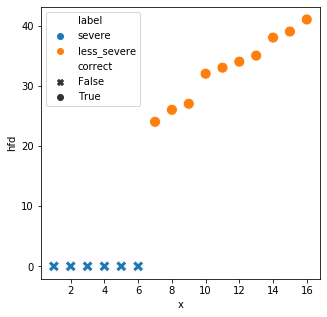

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


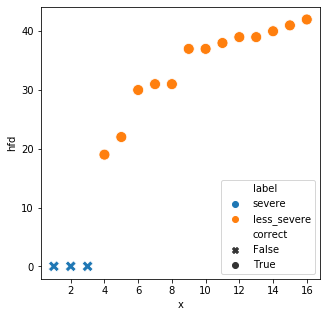

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


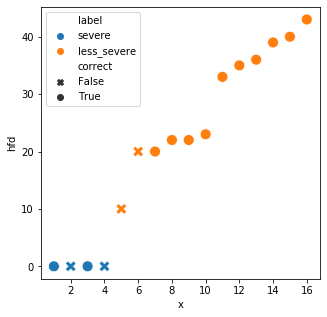

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


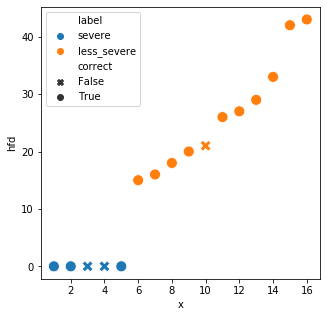

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


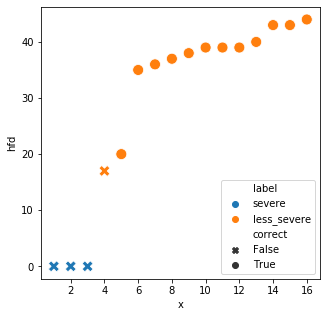

day cutoff4
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


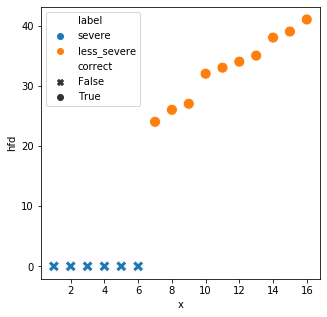

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


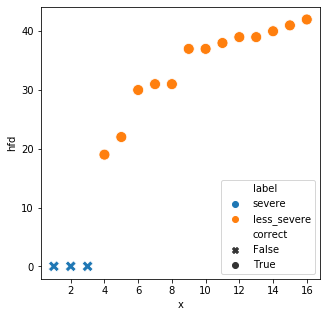

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


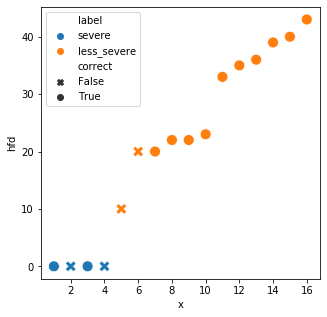

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


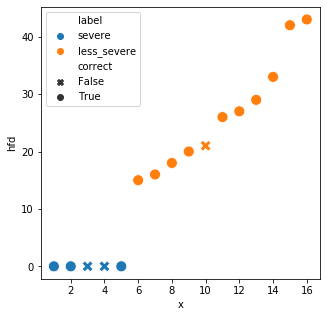

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


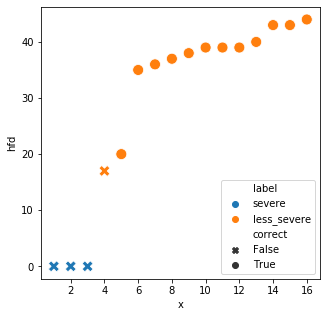

day cutoff5
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


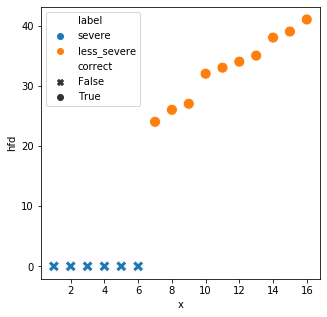

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


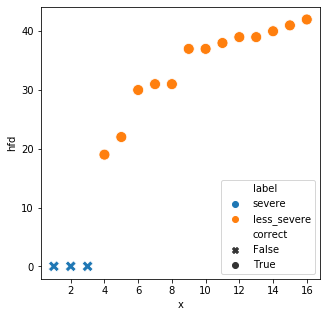

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


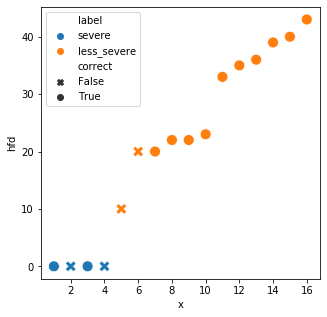

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


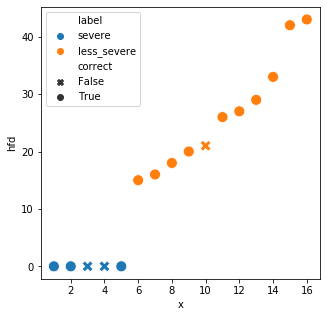

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


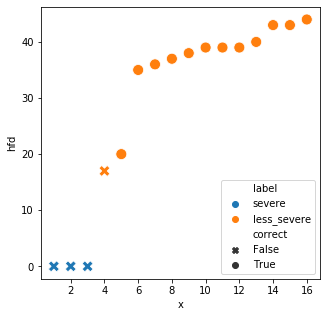

day cutoff6
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


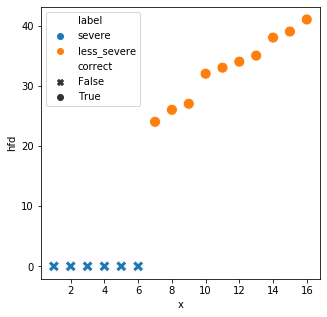

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


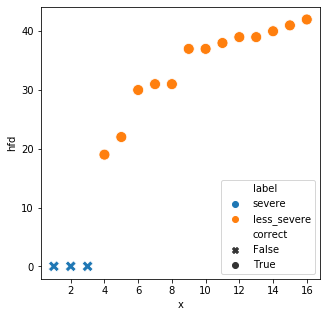

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


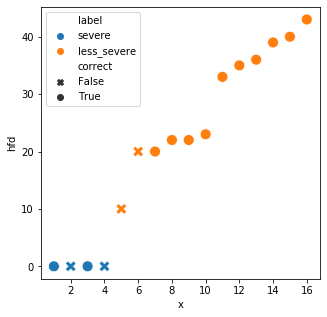

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


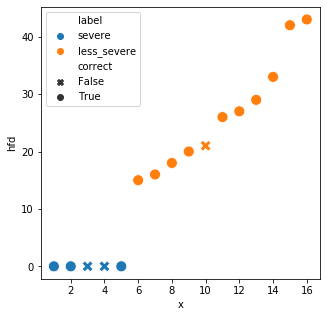

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


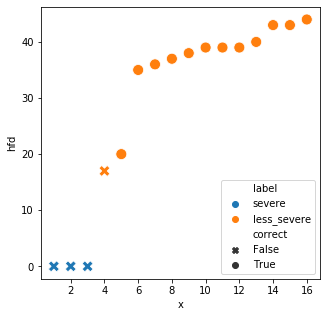

day cutoff7
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


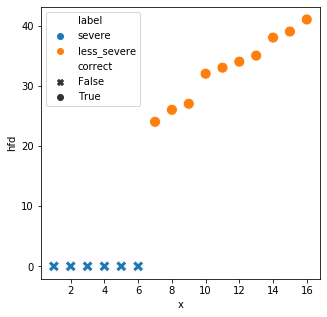

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


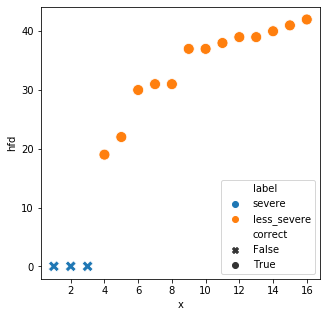

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


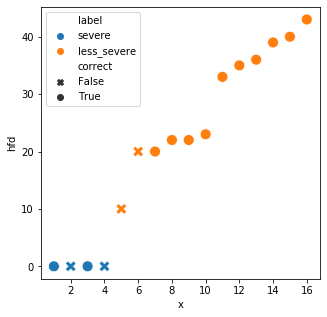

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


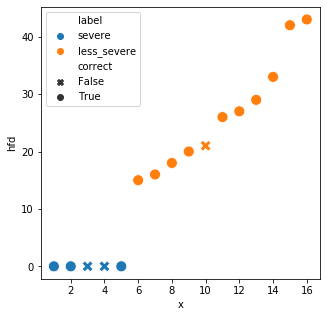

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


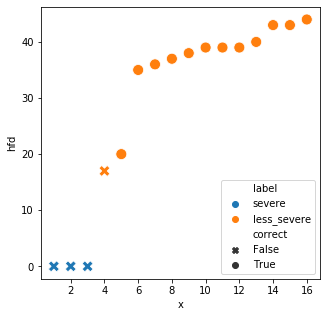

day cutoff8
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


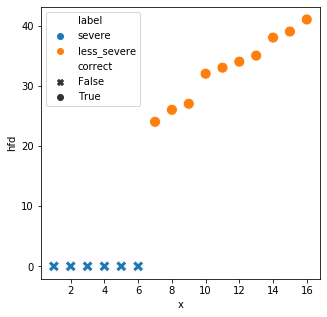

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


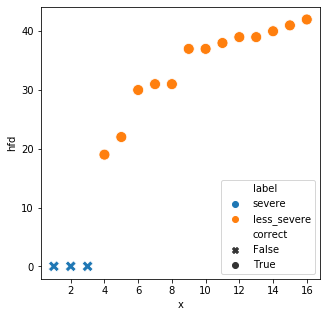

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


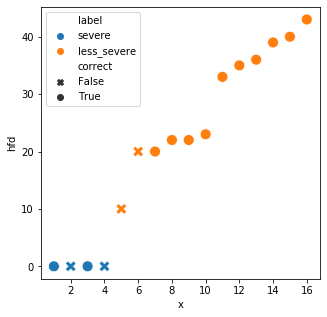

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


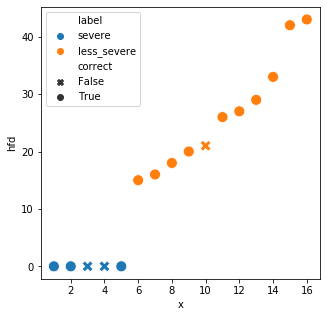

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


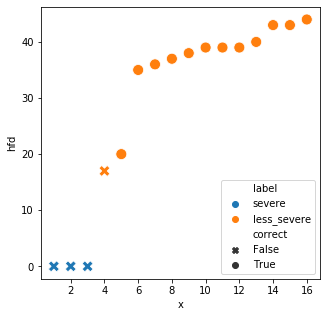

day cutoff9
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


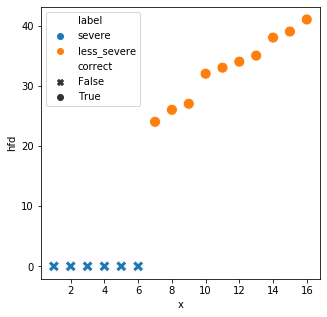

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


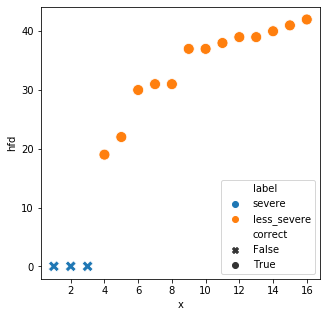

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


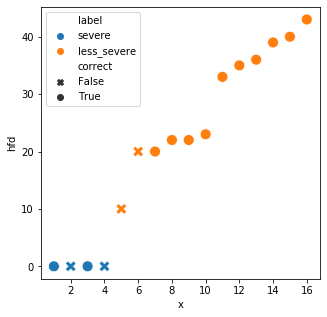

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


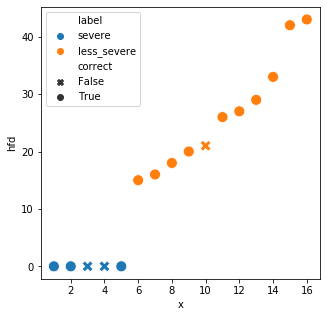

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


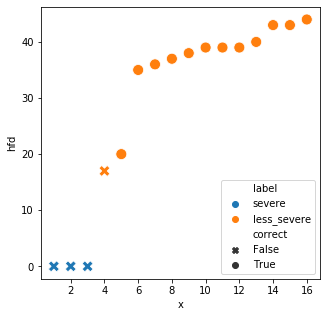

day cutoff10
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


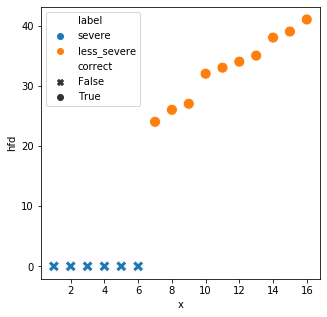

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


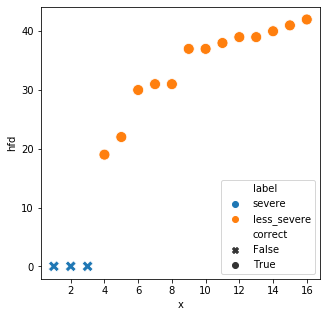

fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


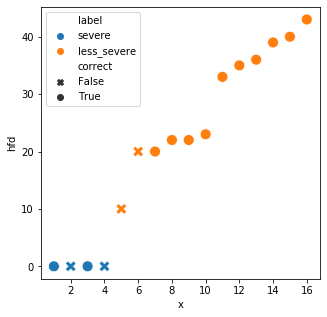

fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


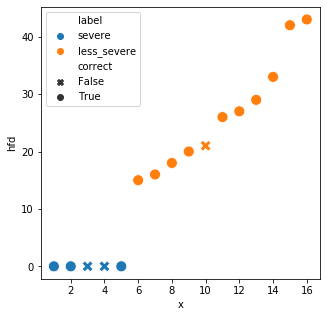

fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


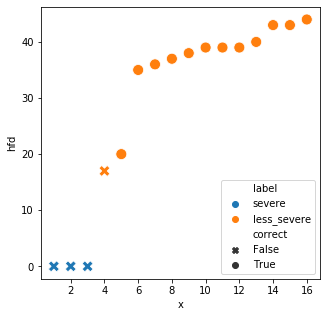

day cutoff11
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


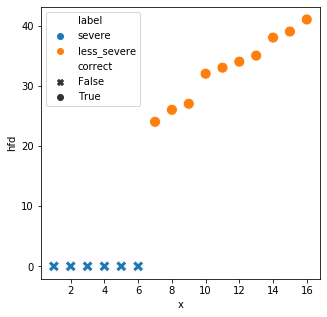

fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74


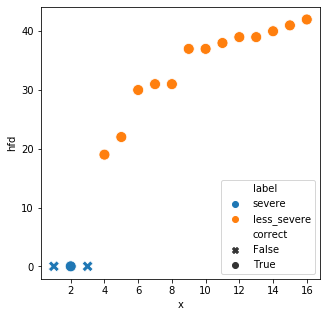

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


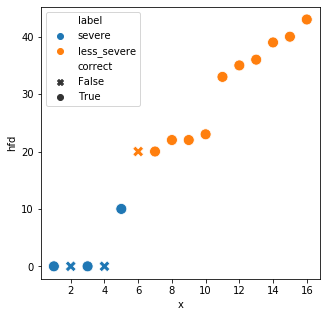

fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60


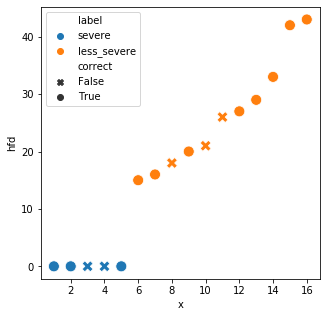

fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55


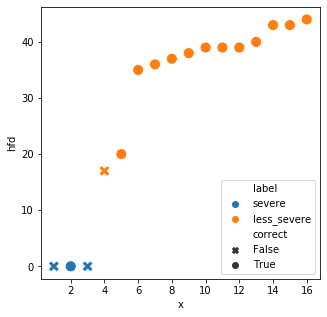

day cutoff12
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


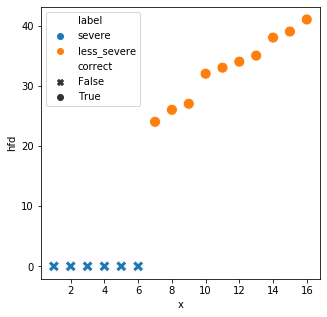

fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74


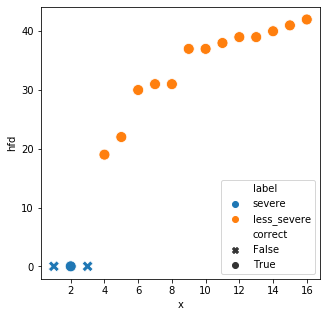

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


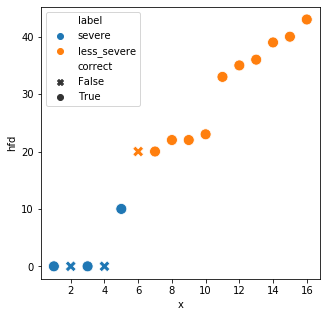

fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60


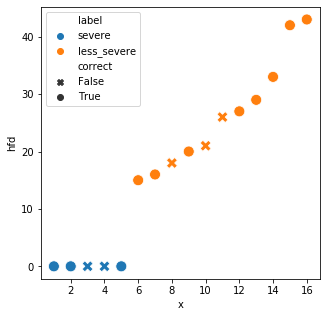

fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55


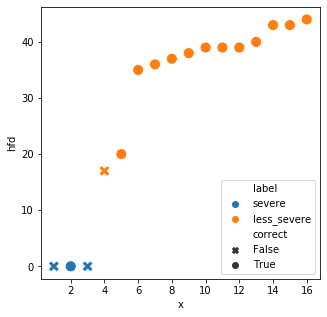

day cutoff13
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


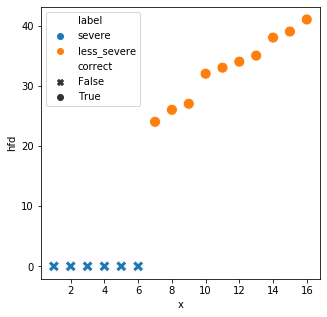

fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74


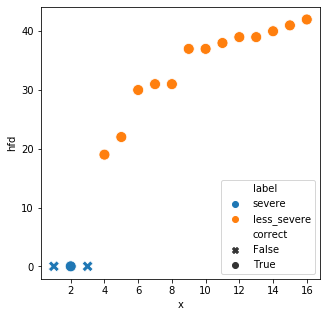

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


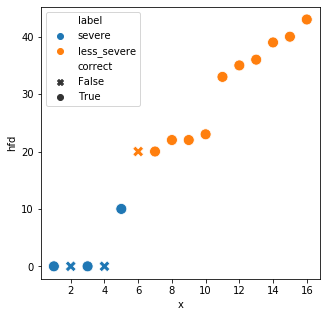

fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60


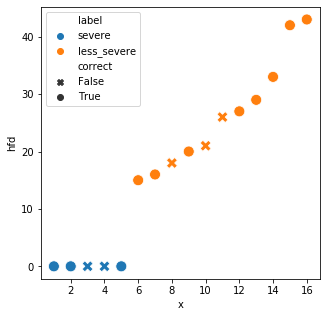

fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55


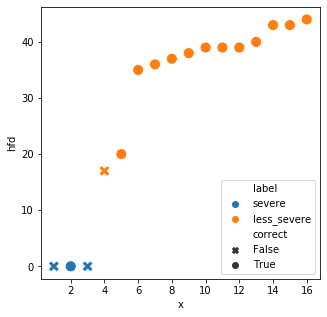

day cutoff14
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


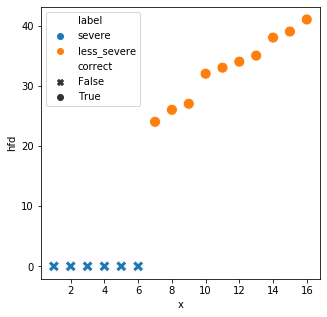

fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74


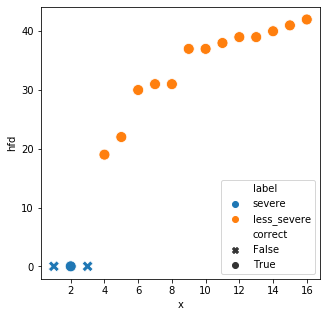

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


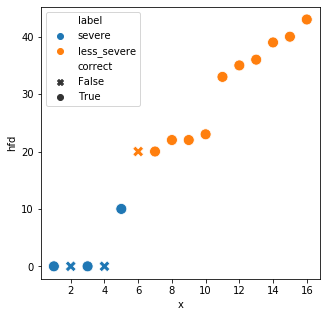

fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60


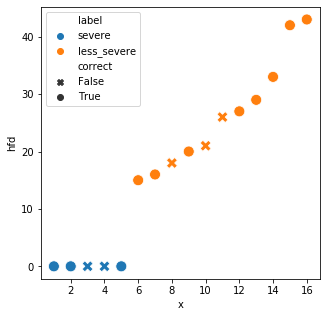

fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55


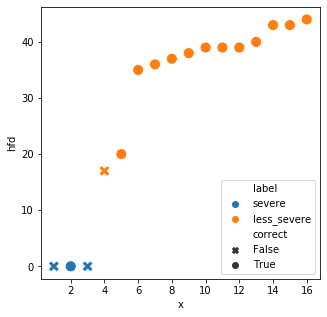

day cutoff15
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


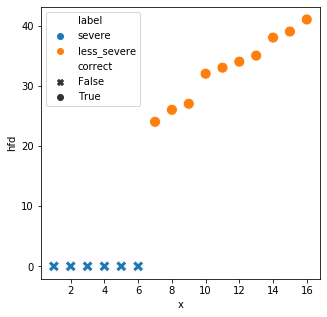

fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74


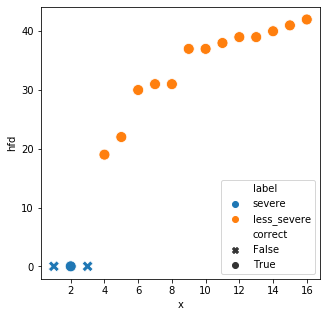

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


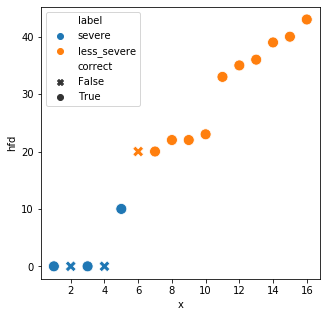

fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60


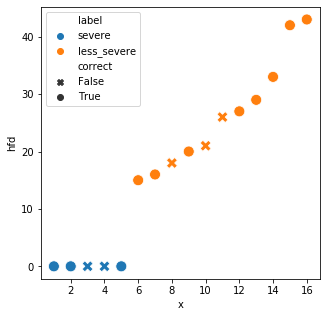

fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55


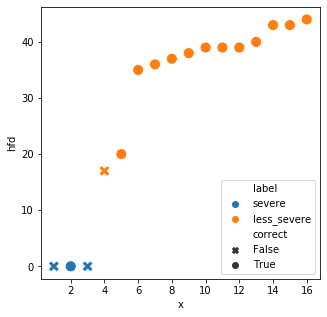

day cutoff16
fold= 0
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


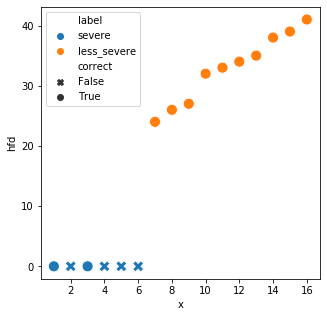

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


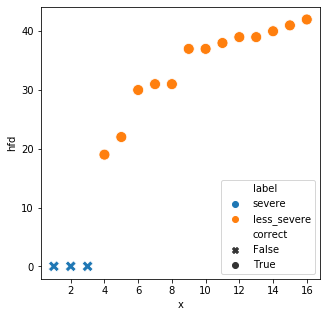

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


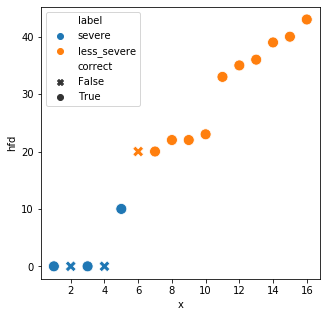

fold= 3
accuracy:  0.62, recall: 0.50, precision: 0.50, metric means: 0.54


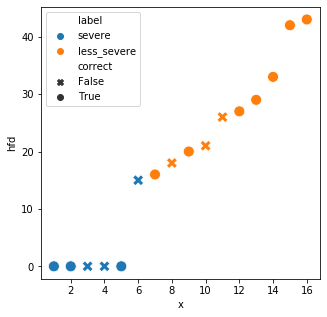

fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55


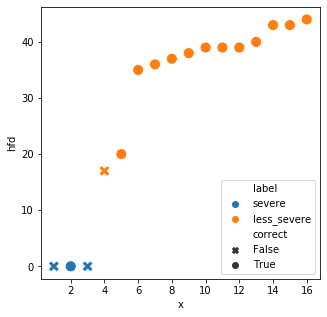

day cutoff17
fold= 0
accuracy:  0.62, recall: 0.17, precision: 0.50, metric means: 0.43


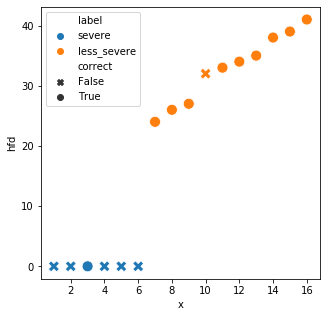

fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74


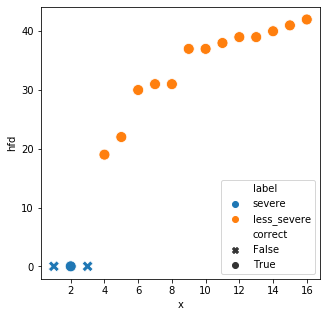

fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65


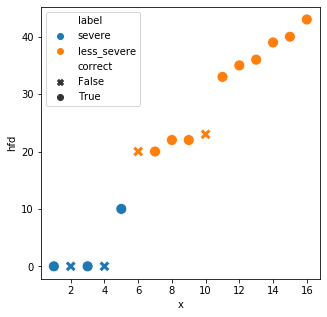

fold= 3
accuracy:  0.56, recall: 0.43, precision: 0.50, metric means: 0.50


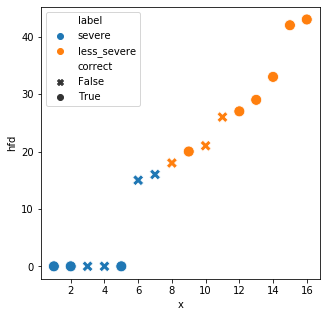

fold= 4
accuracy:  0.75, recall: 0.33, precision: 0.33, metric means: 0.47


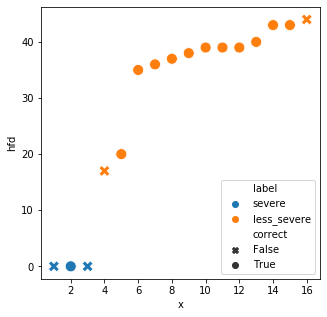

day cutoff18
fold= 0
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


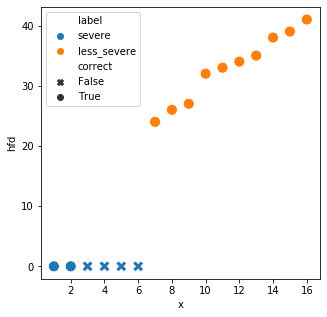

fold= 1
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55


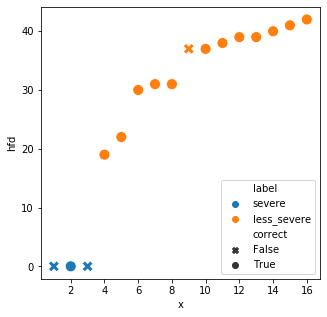

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


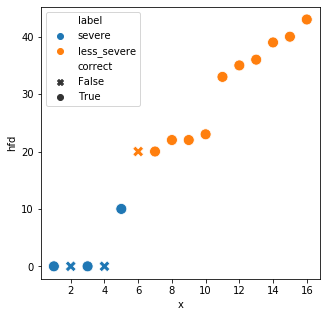

fold= 3
accuracy:  0.62, recall: 0.57, precision: 0.57, metric means: 0.59


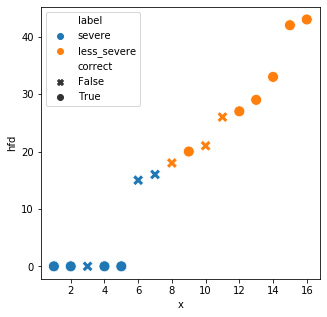

fold= 4
accuracy:  0.81, recall: 0.50, precision: 0.67, metric means: 0.66


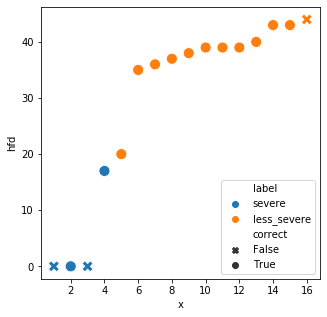

day cutoff19
fold= 0
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


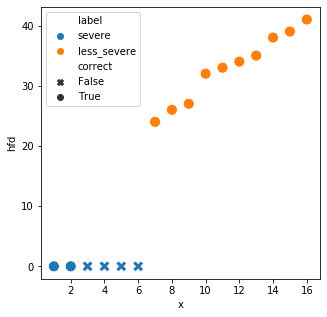

fold= 1
accuracy:  0.75, recall: 0.33, precision: 0.33, metric means: 0.47


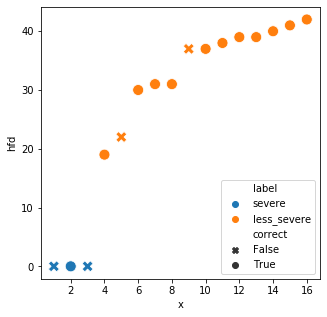

fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65


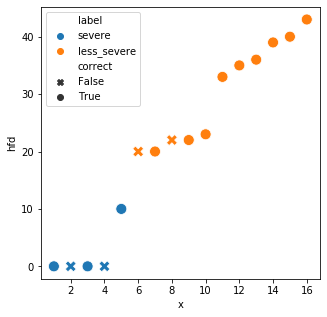

fold= 3
accuracy:  0.69, recall: 0.62, precision: 0.71, metric means: 0.68


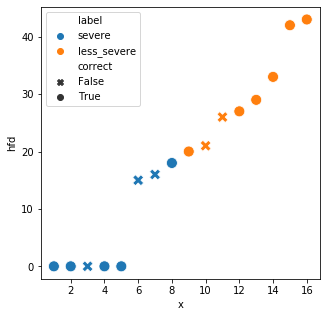

fold= 4
accuracy:  0.88, recall: 0.50, precision: 1.00, metric means: 0.79


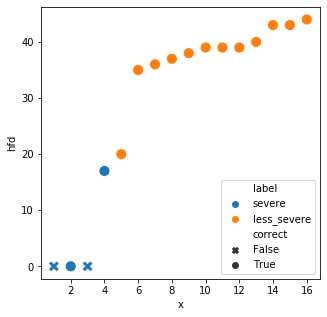

day cutoff20
fold= 0
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


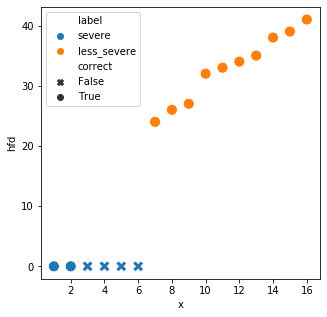

fold= 1
accuracy:  0.69, recall: 0.25, precision: 0.33, metric means: 0.42


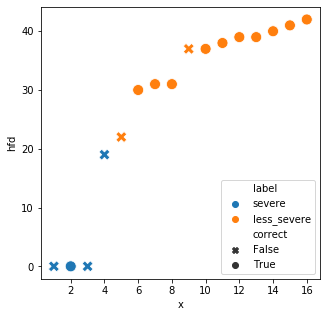

fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65


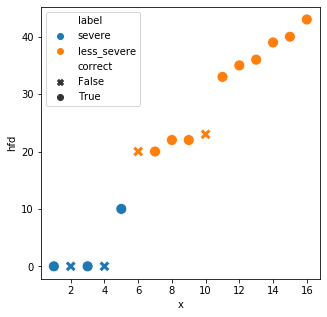

fold= 3
accuracy:  0.75, recall: 0.75, precision: 0.75, metric means: 0.75


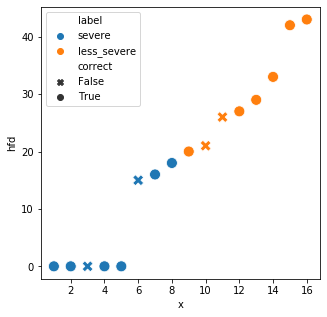

fold= 4
accuracy:  0.81, recall: 0.50, precision: 0.67, metric means: 0.66


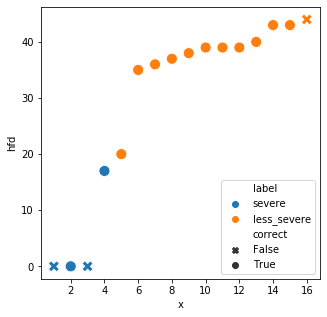

day cutoff21
fold= 0
accuracy:  0.62, recall: 0.50, precision: 0.50, metric means: 0.54


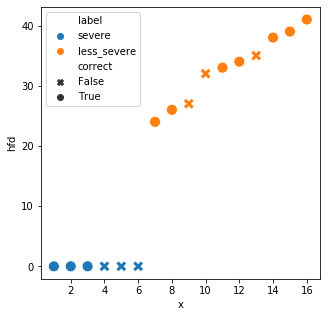

fold= 1
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58


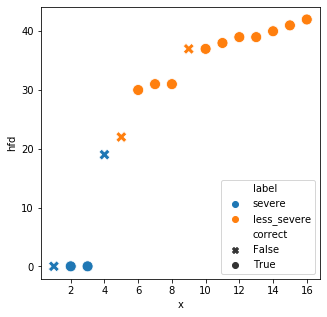

fold= 2
accuracy:  0.75, recall: 0.71, precision: 0.71, metric means: 0.73


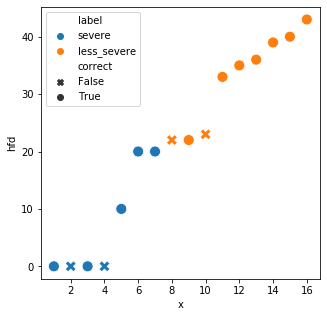

fold= 3
accuracy:  0.69, recall: 0.67, precision: 0.75, metric means: 0.70


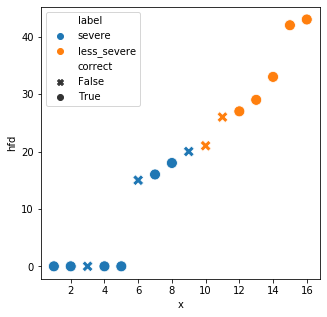

fold= 4
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


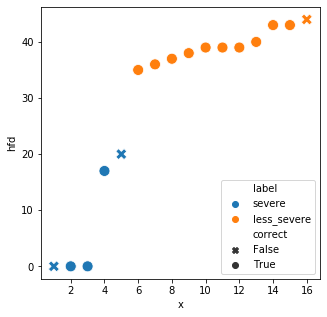

day cutoff22
fold= 0
accuracy:  0.62, recall: 0.50, precision: 0.50, metric means: 0.54


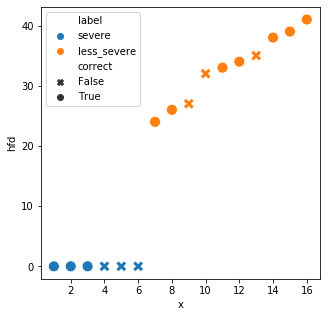

fold= 1
accuracy:  0.69, recall: 0.25, precision: 0.33, metric means: 0.42


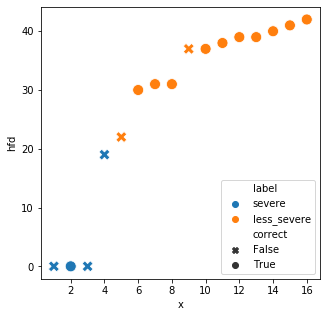

fold= 2
accuracy:  0.69, recall: 0.57, precision: 0.67, metric means: 0.64


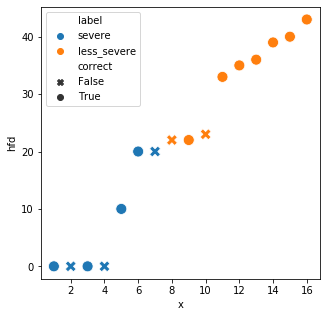

fold= 3
accuracy:  0.75, recall: 0.70, precision: 0.88, metric means: 0.78


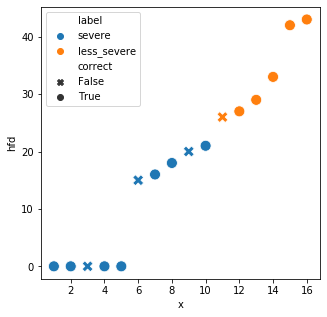

fold= 4
accuracy:  0.94, recall: 0.80, precision: 1.00, metric means: 0.91


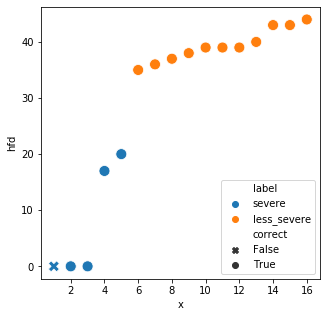

day cutoff23
fold= 0
accuracy:  0.69, recall: 0.67, precision: 0.57, metric means: 0.64


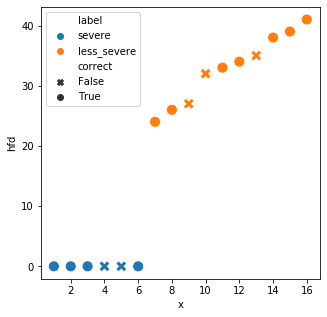

fold= 1
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


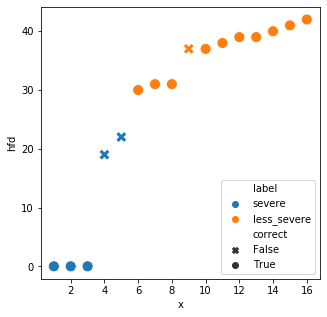

fold= 2
accuracy:  0.75, recall: 0.67, precision: 0.86, metric means: 0.76


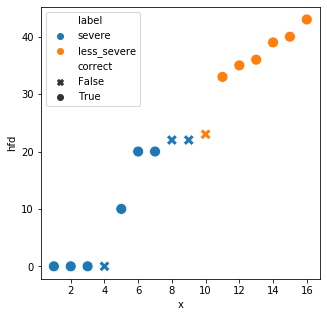

fold= 3
accuracy:  0.81, recall: 0.80, precision: 0.89, metric means: 0.83


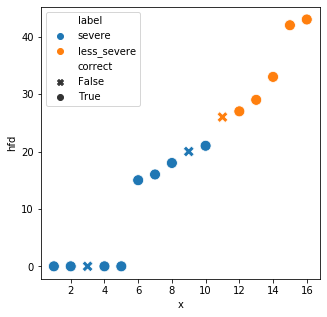

fold= 4
accuracy:  0.88, recall: 0.80, precision: 0.80, metric means: 0.83


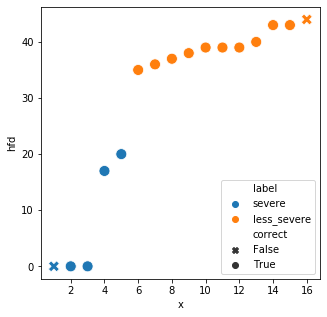

day cutoff24
fold= 0
accuracy:  0.69, recall: 0.67, precision: 0.57, metric means: 0.64


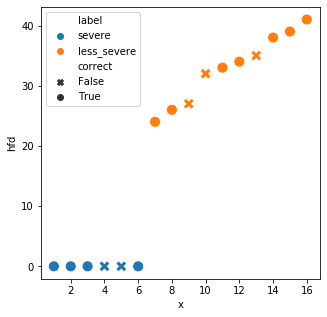

fold= 1
accuracy:  0.94, recall: 1.00, precision: 0.83, metric means: 0.92


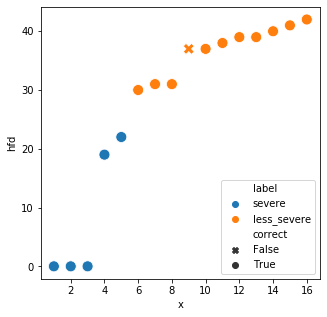

fold= 2
accuracy:  0.81, recall: 0.70, precision: 1.00, metric means: 0.84


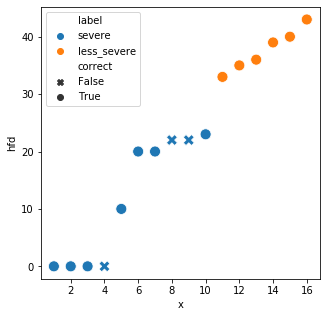

fold= 3
accuracy:  0.75, recall: 0.80, precision: 0.80, metric means: 0.78


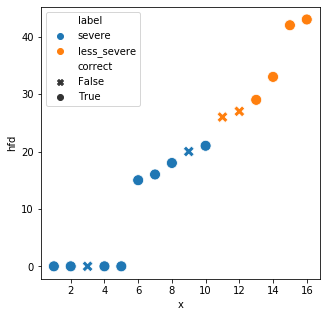

fold= 4
accuracy:  0.88, recall: 0.80, precision: 0.80, metric means: 0.83


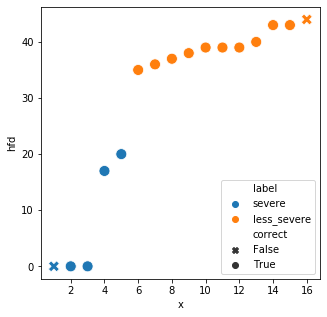

day cutoff25
fold= 0
accuracy:  0.62, recall: 0.57, precision: 0.57, metric means: 0.59


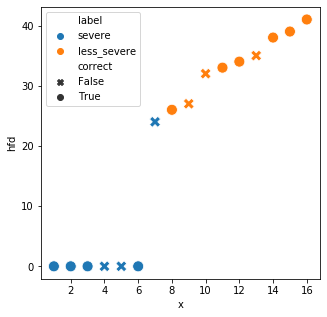

fold= 1
accuracy:  0.88, recall: 0.80, precision: 0.80, metric means: 0.83


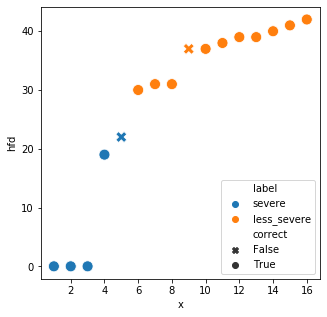

fold= 2
accuracy:  0.88, recall: 0.80, precision: 1.00, metric means: 0.89


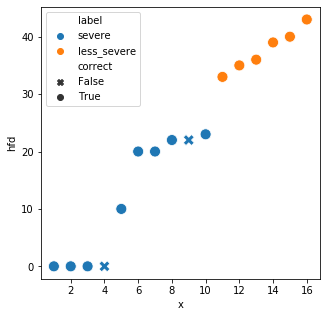

fold= 3
accuracy:  0.81, recall: 0.90, precision: 0.82, metric means: 0.84


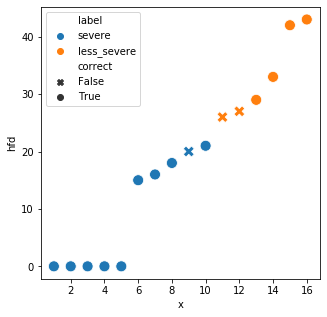

fold= 4
accuracy:  0.88, recall: 0.80, precision: 0.80, metric means: 0.83


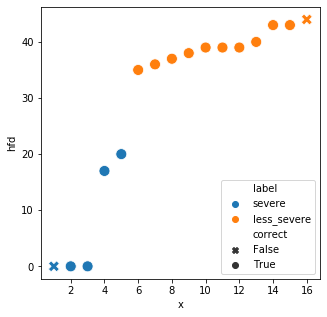

day cutoff26
fold= 0
accuracy:  0.62, recall: 0.57, precision: 0.57, metric means: 0.59


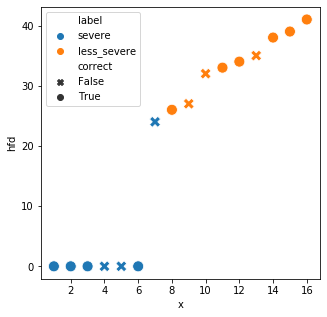

fold= 1
accuracy:  0.88, recall: 0.80, precision: 0.80, metric means: 0.83


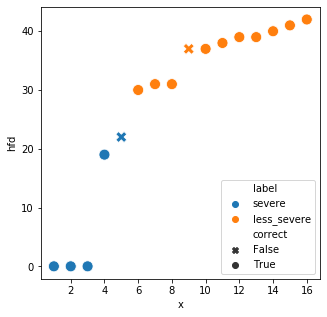

fold= 2
accuracy:  0.88, recall: 0.80, precision: 1.00, metric means: 0.89


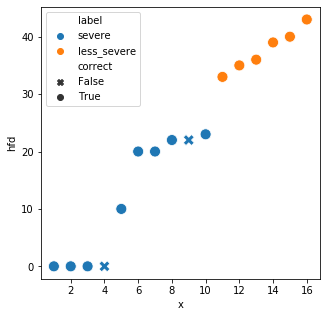

fold= 3
accuracy:  0.81, recall: 0.90, precision: 0.82, metric means: 0.84


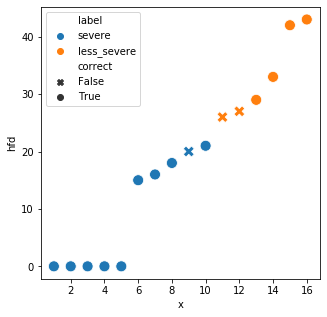

fold= 4
accuracy:  0.88, recall: 0.80, precision: 0.80, metric means: 0.83


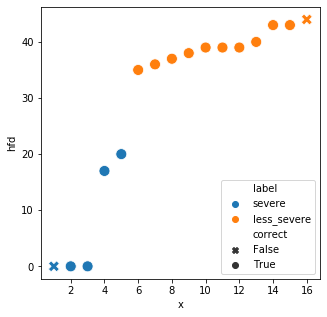

day cutoff27
fold= 0
accuracy:  0.56, recall: 0.50, precision: 0.57, metric means: 0.54


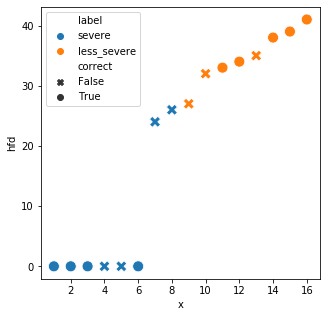

fold= 1
accuracy:  0.81, recall: 0.80, precision: 0.67, metric means: 0.76


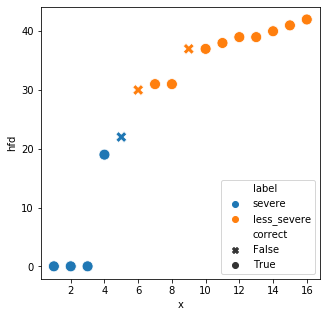

fold= 2
accuracy:  0.81, recall: 0.80, precision: 0.89, metric means: 0.83


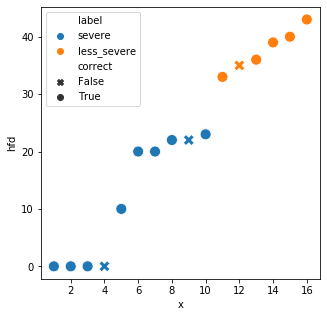

fold= 3
accuracy:  0.94, recall: 0.91, precision: 1.00, metric means: 0.95


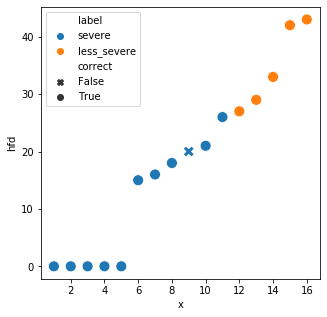

fold= 4
accuracy:  0.88, recall: 0.80, precision: 0.80, metric means: 0.83


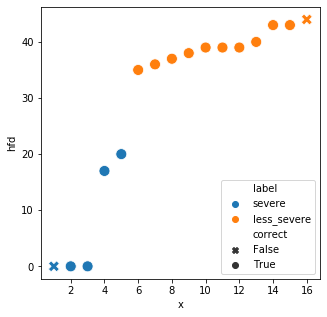

day cutoff28
fold= 0
accuracy:  0.62, recall: 0.56, precision: 0.71, metric means: 0.63


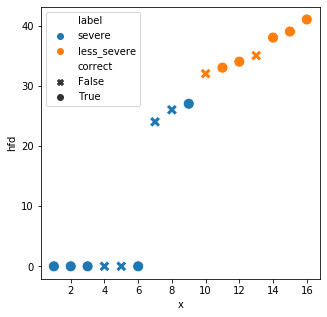

fold= 1
accuracy:  0.81, recall: 1.00, precision: 0.62, metric means: 0.81


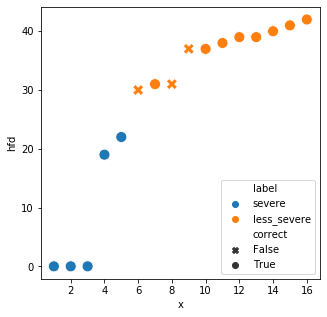

fold= 2
accuracy:  0.88, recall: 0.80, precision: 1.00, metric means: 0.89


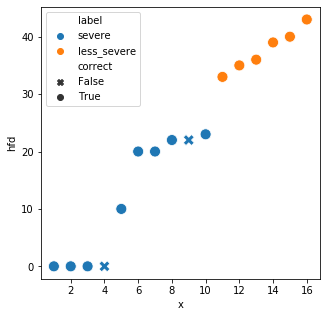

fold= 3
accuracy:  0.94, recall: 0.92, precision: 1.00, metric means: 0.95


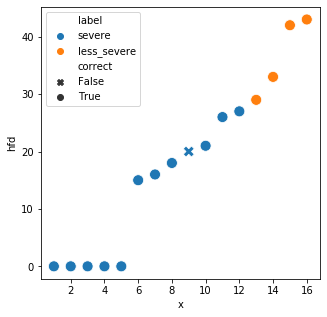

fold= 4
accuracy:  0.69, recall: 0.80, precision: 0.50, metric means: 0.66


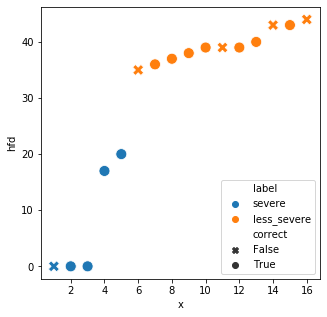

day cutoff29
fold= 0
accuracy:  0.62, recall: 0.56, precision: 0.71, metric means: 0.63


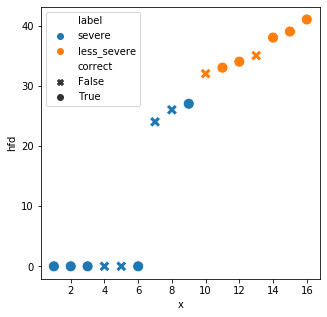

fold= 1
accuracy:  0.81, recall: 1.00, precision: 0.62, metric means: 0.81


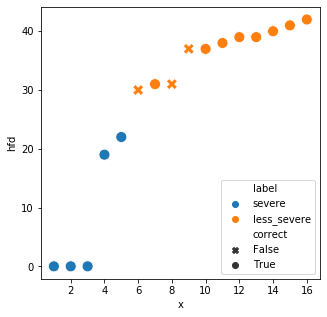

fold= 2
accuracy:  0.88, recall: 0.80, precision: 1.00, metric means: 0.89


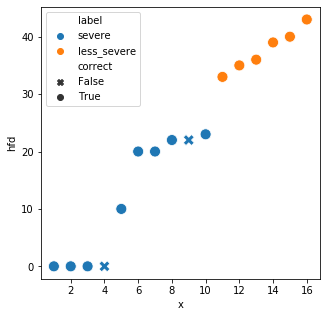

fold= 3
accuracy:  0.94, recall: 0.92, precision: 1.00, metric means: 0.95


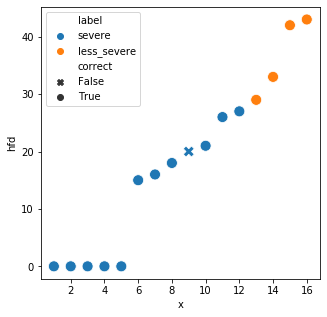

fold= 4
accuracy:  0.69, recall: 0.80, precision: 0.50, metric means: 0.66


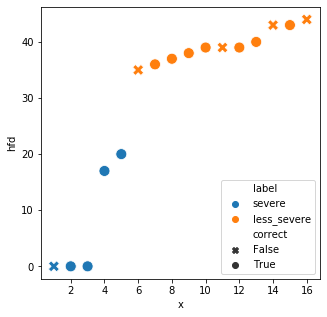

day cutoff30
fold= 0
accuracy:  0.69, recall: 0.67, precision: 0.75, metric means: 0.70


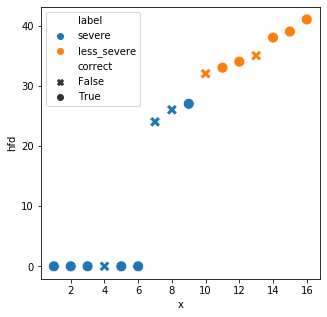

fold= 1
accuracy:  0.81, recall: 1.00, precision: 0.62, metric means: 0.81


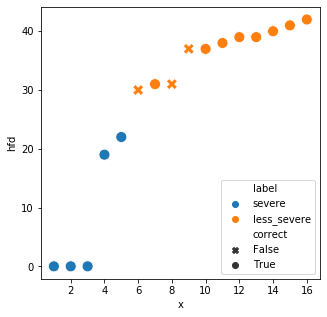

fold= 2
accuracy:  0.88, recall: 0.90, precision: 0.90, metric means: 0.89


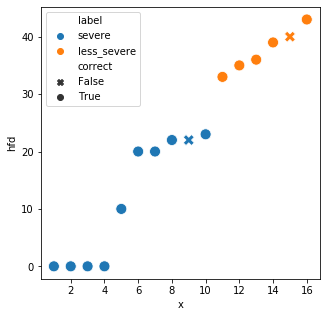

fold= 3
accuracy:  0.88, recall: 0.85, precision: 1.00, metric means: 0.91


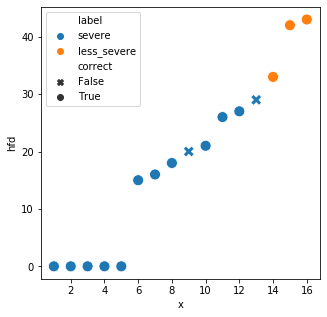

fold= 4
accuracy:  0.75, recall: 1.00, precision: 0.56, metric means: 0.77


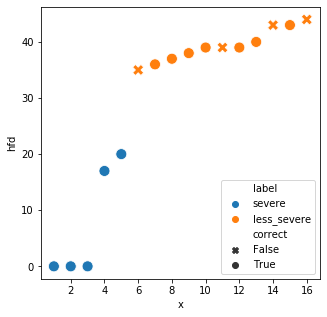

day cutoff31
fold= 0
accuracy:  0.62, recall: 0.67, precision: 0.67, metric means: 0.65


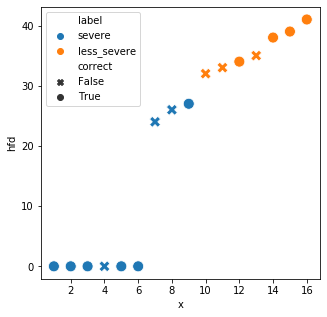

fold= 1
accuracy:  0.88, recall: 1.00, precision: 0.75, metric means: 0.88


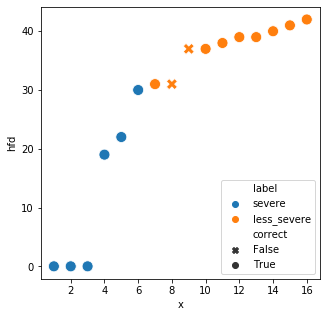

fold= 2
accuracy:  0.81, recall: 0.90, precision: 0.82, metric means: 0.84


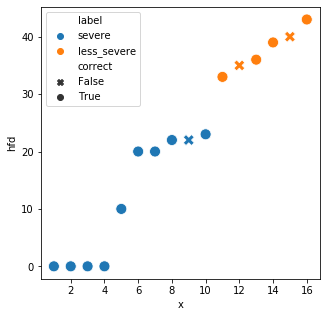

fold= 3
accuracy:  0.81, recall: 0.85, precision: 0.92, metric means: 0.86


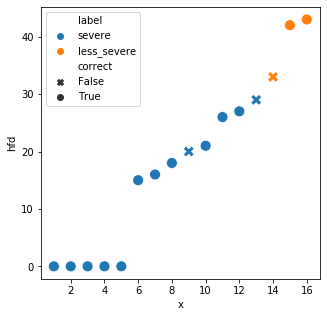

fold= 4
accuracy:  0.75, recall: 1.00, precision: 0.56, metric means: 0.77


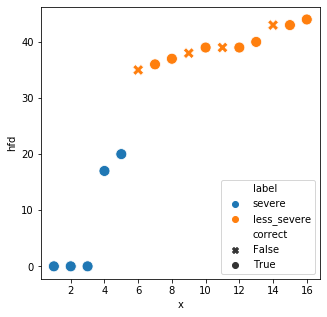

day cutoff32
fold= 0
accuracy:  0.62, recall: 0.78, precision: 0.64, metric means: 0.68


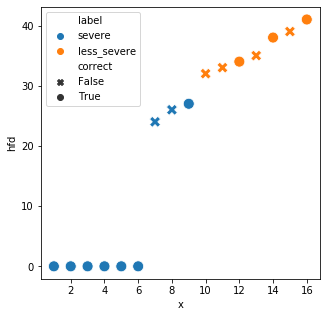

fold= 1
accuracy:  0.88, recall: 0.88, precision: 0.88, metric means: 0.88


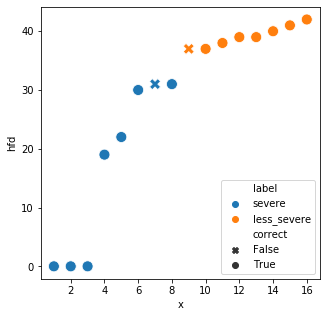

fold= 2
accuracy:  0.75, recall: 0.90, precision: 0.75, metric means: 0.80


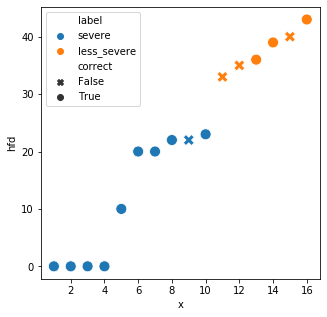

fold= 3
accuracy:  0.88, recall: 0.85, precision: 1.00, metric means: 0.91


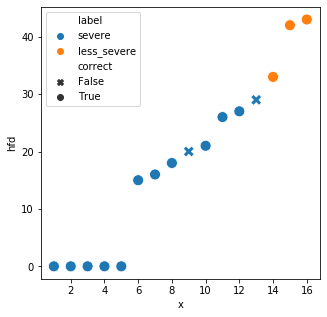

fold= 4
accuracy:  0.69, recall: 1.00, precision: 0.50, metric means: 0.73


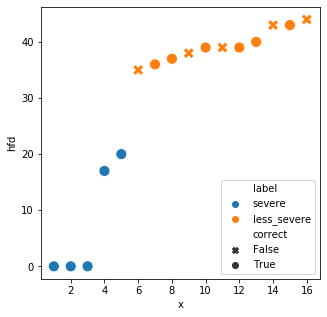

day cutoff33
fold= 0
accuracy:  0.69, recall: 0.80, precision: 0.73, metric means: 0.74


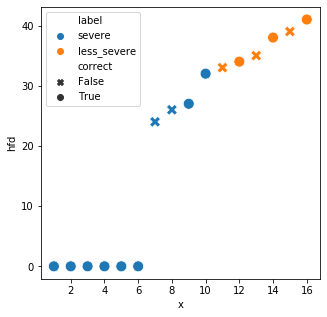

fold= 1
accuracy:  0.81, recall: 0.75, precision: 0.86, metric means: 0.81


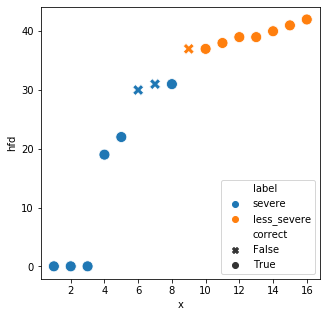

fold= 2
accuracy:  0.88, recall: 1.00, precision: 0.83, metric means: 0.90


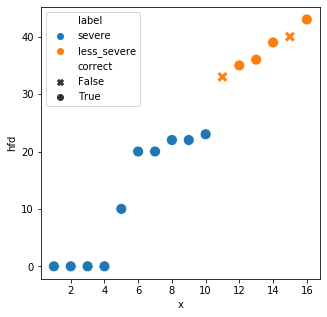

fold= 3
accuracy:  0.81, recall: 0.85, precision: 0.92, metric means: 0.86


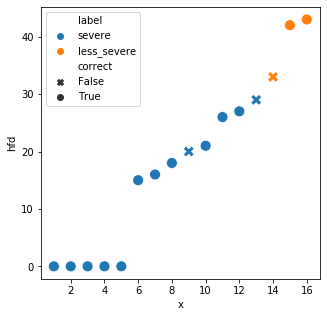

fold= 4
accuracy:  0.69, recall: 1.00, precision: 0.50, metric means: 0.73


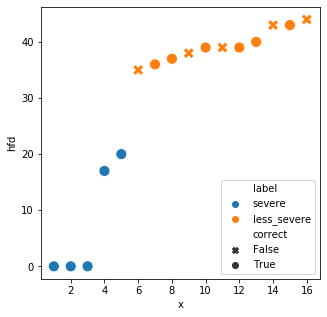

day cutoff34
fold= 0
accuracy:  0.81, recall: 0.82, precision: 0.90, metric means: 0.84


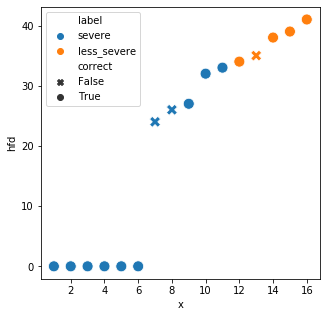

fold= 1
accuracy:  0.88, recall: 0.88, precision: 0.88, metric means: 0.88


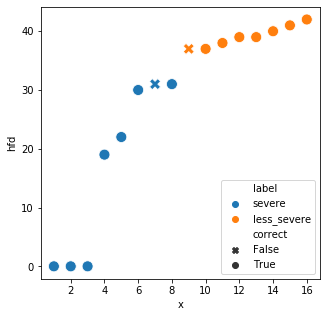

fold= 2
accuracy:  0.81, recall: 0.91, precision: 0.83, metric means: 0.85


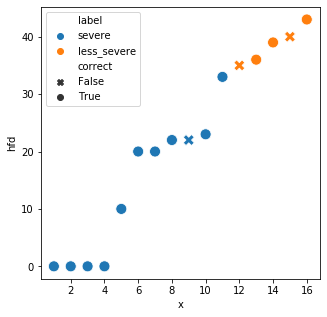

fold= 3
accuracy:  0.94, recall: 0.93, precision: 1.00, metric means: 0.96


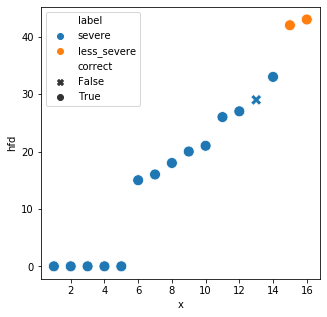

fold= 4
accuracy:  0.62, recall: 1.00, precision: 0.45, metric means: 0.69


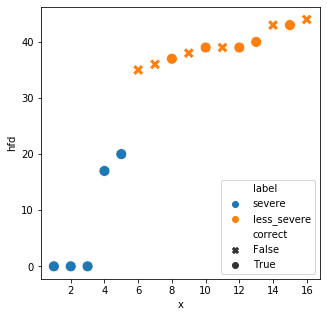

In [52]:
acc, rec, prec, mm, day = compare_cutoffs_kfold()

In [53]:
all_metrics = acc+rec+prec+mm
len(all_metrics)
from itertools import repeat
given_values =['accuracy', 'recall', 'precision', 'metric mean']
new_list=[]
for value in given_values:
    new_list.extend(repeat(value,len(acc)))
#print(new_list)
lineplot_df = pd.DataFrame({'day':day+day+day+day, 'all_metrics':all_metrics, 'metric_type':new_list})

Text(0.5, 1.0, '5-fold CV')

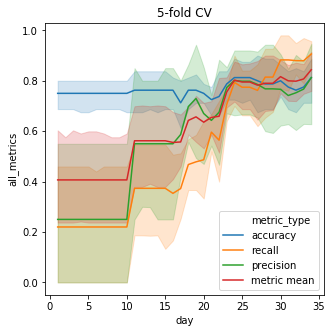

In [54]:
sns.lineplot('day', 'all_metrics', 
            data=lineplot_df,
            hue='metric_type')
plt.title('5-fold CV')

In [58]:
lineplot_df[lineplot_df['metric_type']=='metric mean']

day  all_metrics  metric_type
510    1     0.208333  metric mean
511    1     0.270833  metric mean
512    1     0.583333  metric mean
513    1     0.720833  metric mean
514    1     0.250000  metric mean
..   ...          ...          ...
675   34     0.843561  metric mean
676   34     0.875000  metric mean
677   34     0.851641  metric mean
678   34     0.955357  metric mean
679   34     0.693182  metric mean

[170 rows x 3 columns]

In [79]:
n=5
metmeanbyfold = [sum(mm[i:i+n])/n for i in range(0,len(mm),n)]

In [85]:
from numpy import diff
dx=1
dy = diff(metmeanbyfold)/dx
d2y = diff(metmeanbyfold, 2)/dx
print(dy)
print(d2y)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.15527778  0.          0.
  0.          0.         -0.00666667  0.00190476  0.08539683  0.01420635
 -0.02123016  0.01912698  0.00424603  0.09695767  0.04637566 -0.00735931
  0.         -0.01249759  0.00752886  0.          0.02629121 -0.01656566
 -0.00147306  0.00885161  0.03671023]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.15527778 -0.15527778  0.          0.
  0.         -0.00666667  0.00857143  0.08349206 -0.07119048 -0.03543651
  0.04035714 -0.01488095  0.09271164 -0.05058201 -0.05373497  0.00735931
 -0.01249759  0.02002646 -0.00752886  0.02629121 -0.04285687  0.01509259
  0.01032468  0.02785862]


Text(0.5, 1.0, 'derivative of metric means')

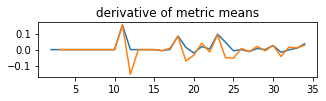

In [119]:
plt.rcParams['figure.figsize'] = 5,1
sns.lineplot(np.linspace(2,34,33), dy)
sns.lineplot(np.linspace(3,34,32), d2y)

plt.title('derivative of metric means')

Text(0.5, 1.0, 'derivative of metric means')

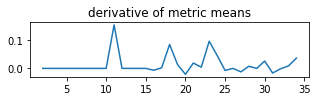

In [93]:
plt.rcParams['figure.figsize'] = 5,1
sns.lineplot(np.linspace(2,34,33), dy)
plt.title('derivative of metric means')

In [97]:
np.where(np.asarray(metmeanbyfold)>0.8)

(array([23, 29, 32, 33], dtype=int64),)

[10 14 18 23 25 27 29]


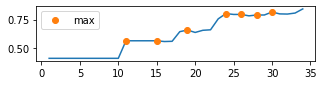

In [115]:
from pylab import *
n=5
plt.rcParams['figure.figsize'] = 5,1
metmeanbyfold = [sum(mm[i:i+n])/n for i in range(0,len(mm),n)]
#a = diff(sign(diff(metmeanbyfold))).nonzero()[0] + 1 # local min+max
#b = (diff(sign(diff(metmeanbyfold))) > 0).nonzero()[0] + 1 # local min
local_max = (diff(sign(diff(metmeanbyfold))) < 0).nonzero()[0] + 1 # local max
print(c)
xvalues = np.linspace(1,35,35)
plot(range(1,35),metmeanbyfold)
#plot(x[b], np.asarray(metmeanbyfold)[b], "o", label="min")
plot(xvalues[local_max], np.asarray(metmeanbyfold)[local_max], "o", label="max")
legend()
show()

Text(0.5, 1.0, '5-fold CV')

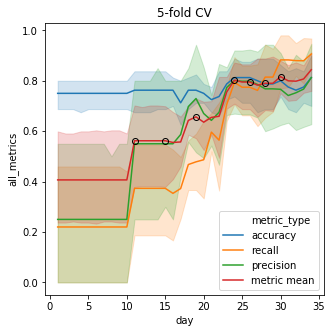

In [121]:
plt.rcParams['figure.figsize'] = 5,5
sns.lineplot('day', 'all_metrics', 
            data=lineplot_df,
            hue='metric_type')
plot(xvalues[local_max], np.asarray(metmeanbyfold)[local_max], "ko", label="max", fillstyle='none')
plt.title('5-fold CV')

(array([48.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 52.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

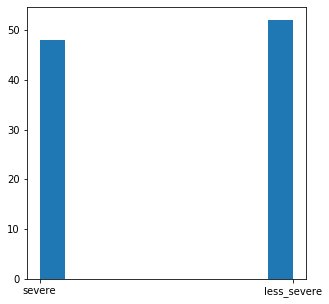

In [118]:
plt.rcParams['figure.figsize'] = 5,5
dfc_covid = dfc_covid.assign(dayclass=np.zeros(len(dfc_covid)))
dfc_covid.loc[dfc_covid['Hospital_free_days_45']<24, 'dayclass'] = 'severe'
dfc_covid.loc[dfc_covid['Hospital_free_days_45']>=24, 'dayclass'] = 'less_severe'
plt.hist(dfc_covid['dayclass'])

In [ ]:
q

In [46]:
def compare_cutoffs_kfold(dataset, df_dict, quant_range_dict, plot=True):
    accuracies = []
    recalls = []
    precisions = []
    metric_means = []
    ave_precs = []
    f1s= []
    aucs = []
    day_thresh = []
    RANDOM_SEED = 11
    print('dataset is ' +dataset)
    dfc = df_dict[dataset]
    qrc = quant_range_dict[dataset]
    dfc_quant_cols = dfc.columns[:qrc]
    prefilter_range = len(dfc.columns)
    dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='Unknown')))]
    dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='unknown')))]
    rangediff = prefilter_range - len(dfc.columns)
    print( 'dropped columns = '+ str(rangediff))
    qr_filt = qrc - rangediff
    print('measurements used ' + str(qr_filt))
    
    
    for i in range(1,35):
        
        DAY_CUTOFF = i
        print('day cutoff'+str(DAY_CUTOFF))


        df = dfc[dfc['COVID']==1]
        #df = dfc
        X = df[df.columns[:qr_filt]]
        df = df.assign(dayclass=np.zeros(len(df)))
        df.loc[df['Hospital_free_days_45']<DAY_CUTOFF, 'dayclass'] = 'severe'
        df.loc[df['Hospital_free_days_45']>=DAY_CUTOFF, 'dayclass'] = 'less_severe'
        y = df['dayclass']
        hfd = df['Hospital_free_days_45']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
        X_train, X_test, hfd_train, hfd_test = train_test_split(X, hfd, test_size = 0.2, random_state = RANDOM_SEED)
        xa = np.asarray(X_train)
        ya = np.asarray(y_train)
        ha = np.asarray(hfd_train)
        
        
        fold=0
        kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
        
        for train_index, test_index in kf.split(xa):
            print('fold= '+str(fold))
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_val = xa[train_index], xa[test_index]
            y_train, y_val = ya[train_index], ya[test_index]
            h_train, h_val = ha[train_index], ha[test_index]
            et = ExtraTreesClassifier(random_state=RANDOM_SEED)
            et.fit(X_train, y_train)
            y_pred = et.predict(X_val)
            y_score = et.predict_proba(X_val)
            accuracies.append(accuracy_score(y_val, y_pred))
            recalls.append(recall_score(y_val, y_pred, pos_label='severe'))
            precisions.append(precision_score(y_val, y_pred, pos_label='severe'))
            metric_means.append(np.mean([accuracies[-1], recalls[-1], precisions[-1]]))
            ave_precs.append(average_precision_score(y_val, y_score[:,1], pos_label='severe') )
            f1s.append(f1_score(y_val, y_pred, pos_label='severe'))
            aucs.append(roc_auc_score(y_val, y_score[:,1]))
            
            day_thresh.append(i)
            #print(h_val)
            day_order_index = np.argsort(h_val)
            correct = y_val == y_pred
            print('accuracy: %5.2f, recall: %3.2f, precision: %3.2f, metric means: %3.2f' % (accuracies[-1], 
                                                                       recalls[-1],
                                                                       precisions[-1],
                                                                       metric_means[-1])
                 )
            if(plot):
                plot_df = pd.DataFrame({'hfd':h_val[day_order_index], 
                              'x':np.arange(1, len(y_val)+1,1), 
                              'label':y_val[day_order_index],
                              'correct':correct[day_order_index]})
                plt.rcParams['figure.figsize']= 5,5
                MARKERS = {True:"s",False:'X'}
                sns.scatterplot('x', 'hfd', data=plot_df, hue='label', style='correct', markers={True:"o",False:'X'}, s=120)
                plt.show()
            fold+=1
    metrics_dict = {'accuracy':accuracies, 'recall':recalls, 'precision': precisions, 'metric_means':metric_means, 
                   'average_precision':ave_precs, 'f1':f1s, 'roc_auc':aucs, 'day_thresh':day_thresh}
    return metrics_dict

dataset is proteomics
dropped columns = 0
measurements used 517
day cutoff1
fold= 0
accuracy:  0.59, recall: 0.00, precision: 0.00, metric means: 0.20


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


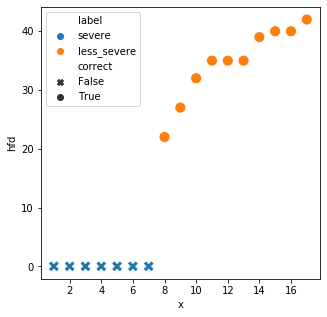

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


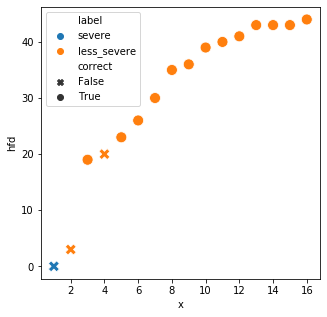

fold= 2
accuracy:  0.81, recall: 0.50, precision: 0.67, metric means: 0.66


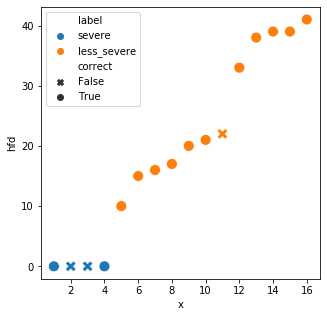

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


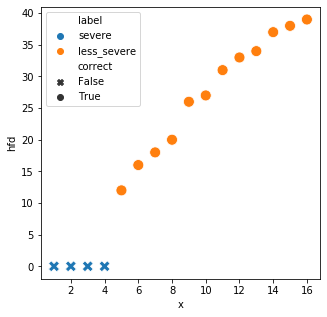

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


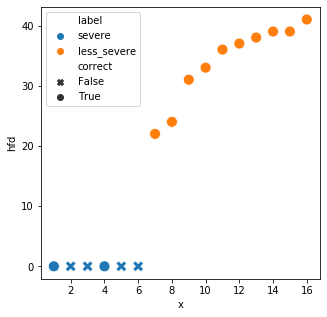

day cutoff2
fold= 0
accuracy:  0.59, recall: 0.00, precision: 0.00, metric means: 0.20


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


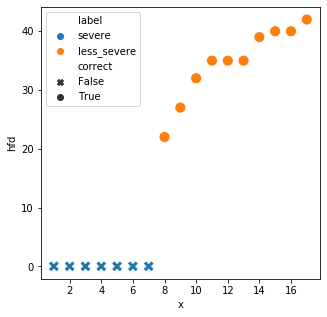

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


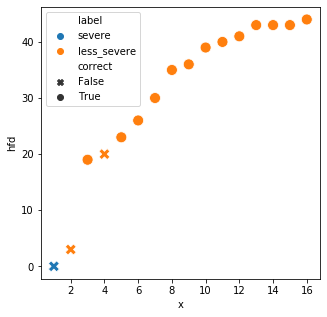

fold= 2
accuracy:  0.81, recall: 0.50, precision: 0.67, metric means: 0.66


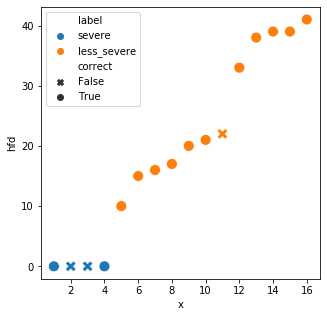

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


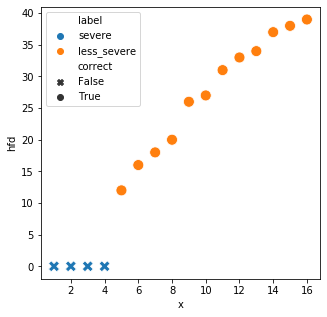

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


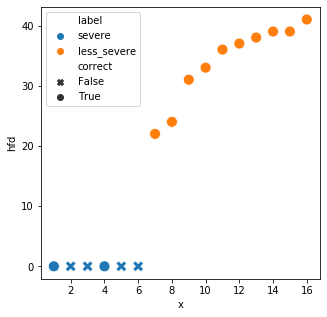

day cutoff3
fold= 0
accuracy:  0.59, recall: 0.00, precision: 0.00, metric means: 0.20


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


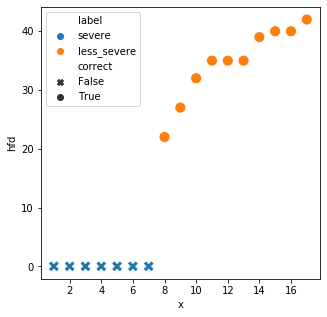

fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27


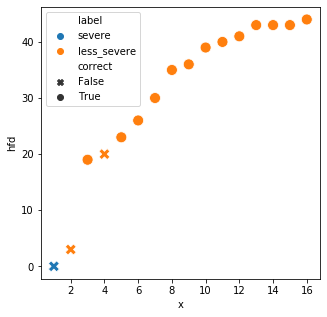

fold= 2
accuracy:  0.81, recall: 0.50, precision: 0.67, metric means: 0.66


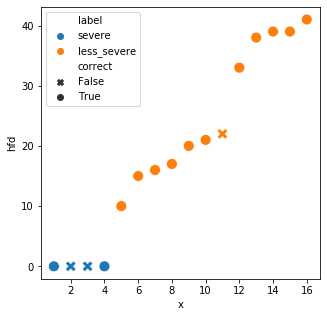

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


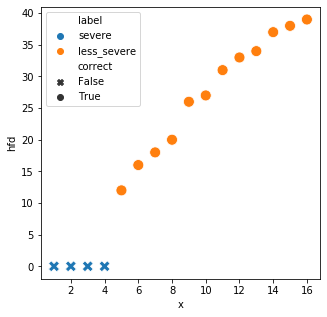

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


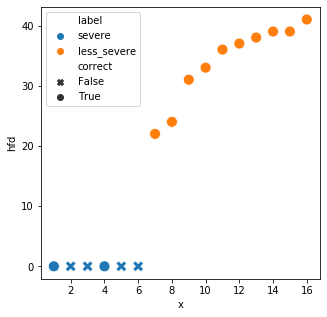

day cutoff4
fold= 0
accuracy:  0.65, recall: 0.14, precision: 1.00, metric means: 0.60


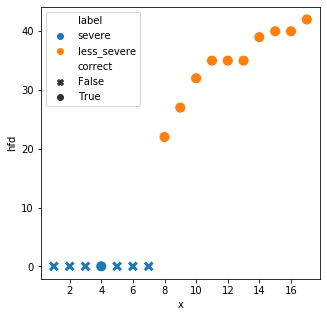

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


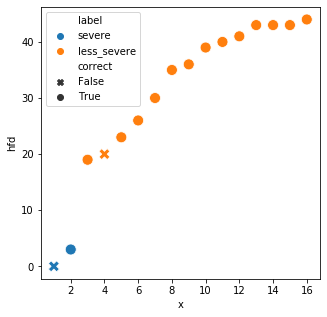

fold= 2
accuracy:  0.88, recall: 0.75, precision: 0.75, metric means: 0.79


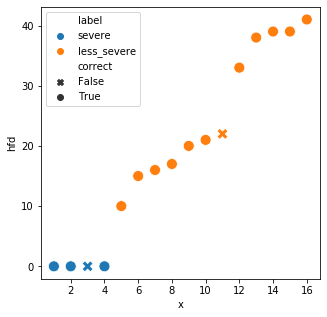

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


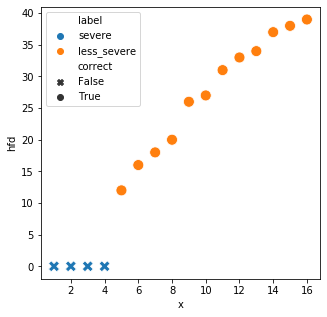

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


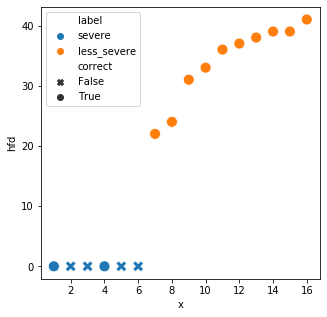

day cutoff5
fold= 0
accuracy:  0.65, recall: 0.14, precision: 1.00, metric means: 0.60


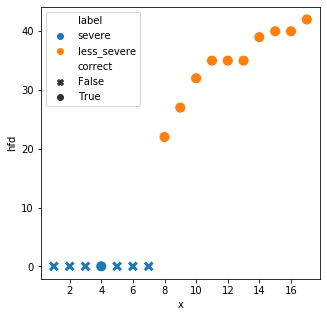

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


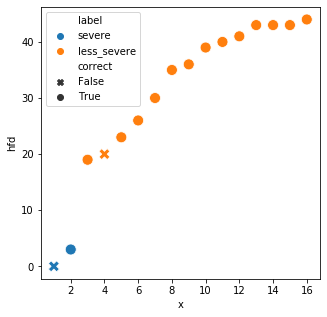

fold= 2
accuracy:  0.88, recall: 0.75, precision: 0.75, metric means: 0.79


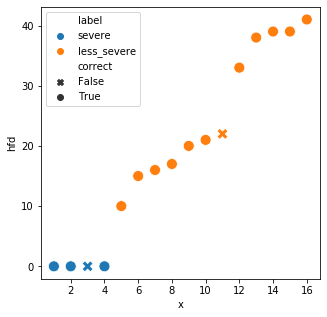

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


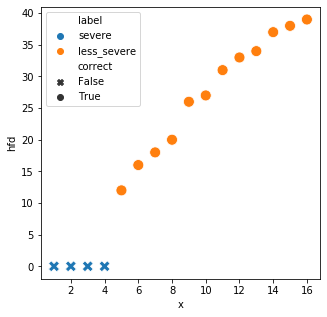

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


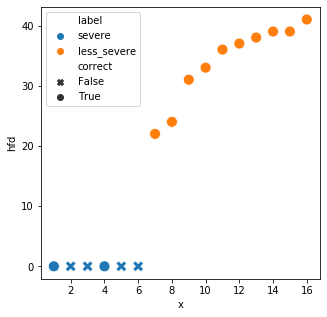

day cutoff6
fold= 0
accuracy:  0.65, recall: 0.14, precision: 1.00, metric means: 0.60


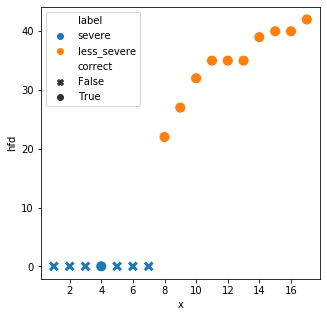

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


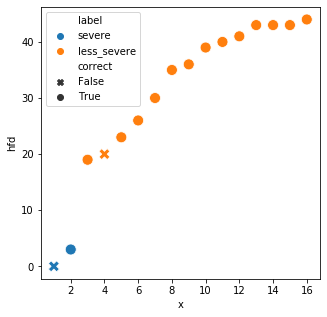

fold= 2
accuracy:  0.88, recall: 0.75, precision: 0.75, metric means: 0.79


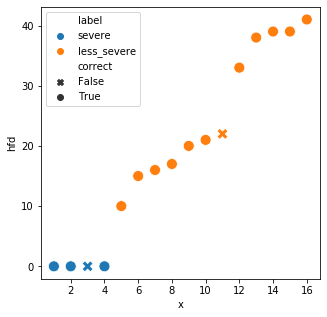

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


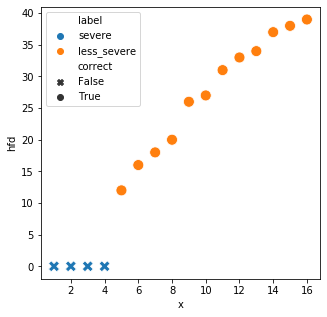

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


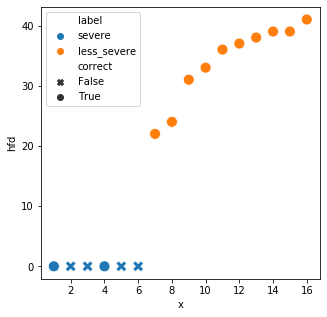

day cutoff7
fold= 0
accuracy:  0.65, recall: 0.14, precision: 1.00, metric means: 0.60


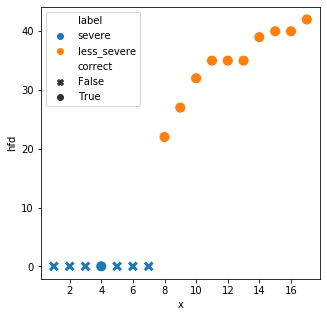

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


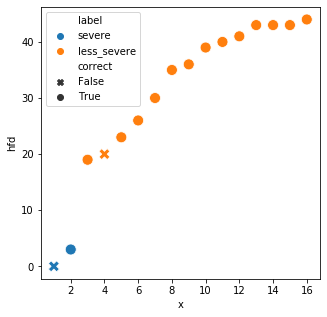

fold= 2
accuracy:  0.88, recall: 0.75, precision: 0.75, metric means: 0.79


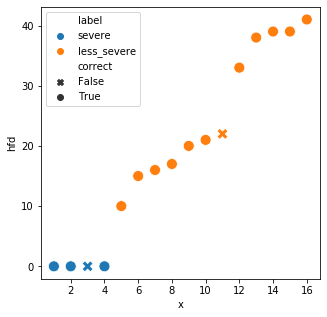

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


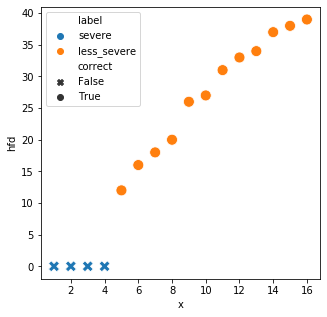

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


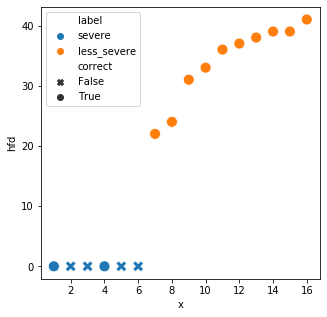

day cutoff8
fold= 0
accuracy:  0.65, recall: 0.14, precision: 1.00, metric means: 0.60


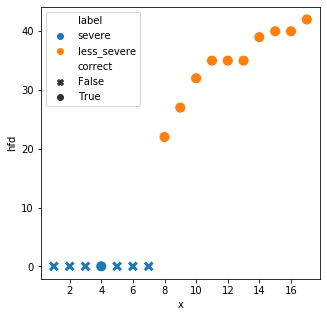

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


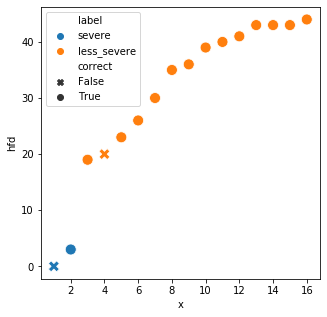

fold= 2
accuracy:  0.88, recall: 0.75, precision: 0.75, metric means: 0.79


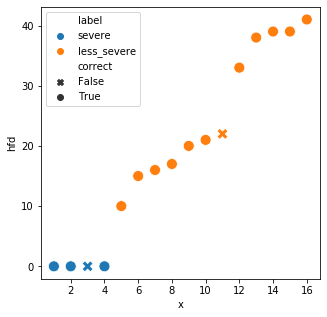

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


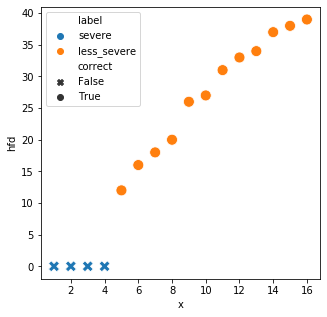

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


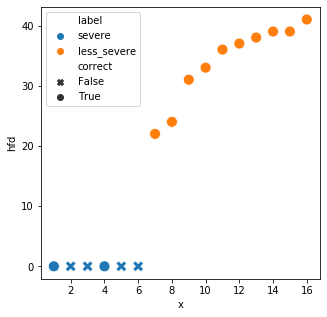

day cutoff9
fold= 0
accuracy:  0.65, recall: 0.14, precision: 1.00, metric means: 0.60


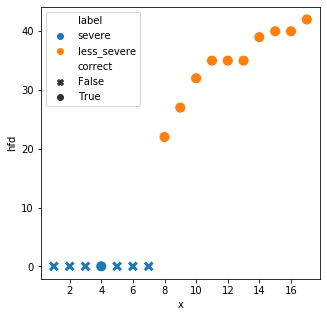

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


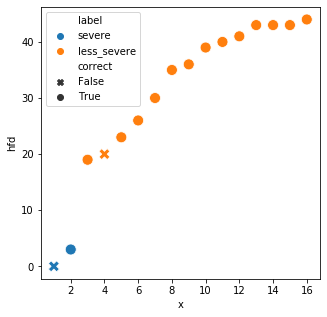

fold= 2
accuracy:  0.88, recall: 0.75, precision: 0.75, metric means: 0.79


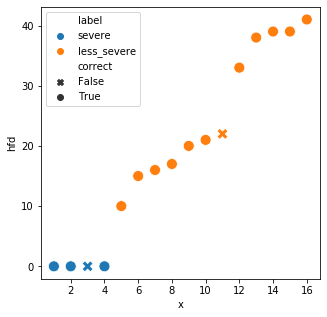

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


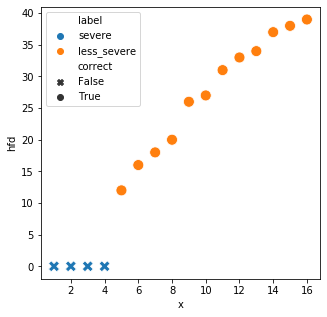

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


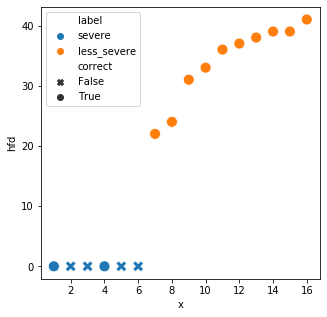

day cutoff10
fold= 0
accuracy:  0.65, recall: 0.14, precision: 1.00, metric means: 0.60


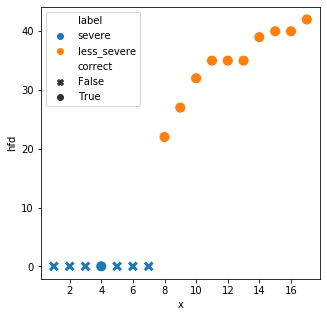

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


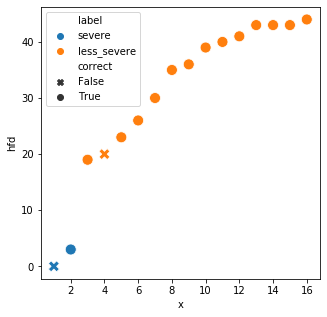

fold= 2
accuracy:  0.88, recall: 0.75, precision: 0.75, metric means: 0.79


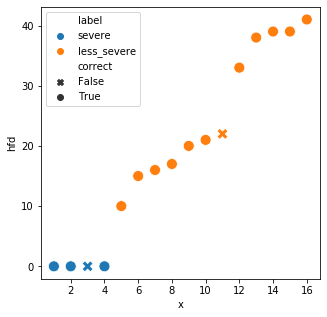

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


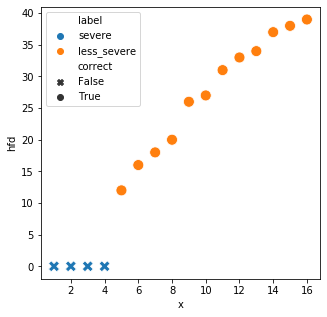

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


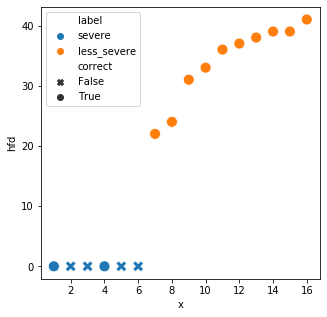

day cutoff11
fold= 0
accuracy:  0.82, recall: 0.57, precision: 1.00, metric means: 0.80


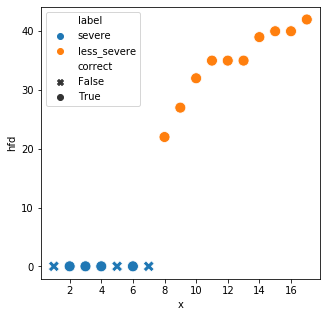

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


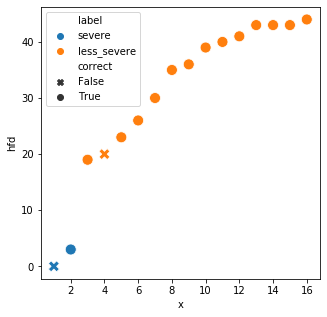

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


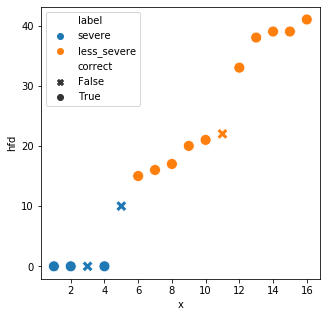

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


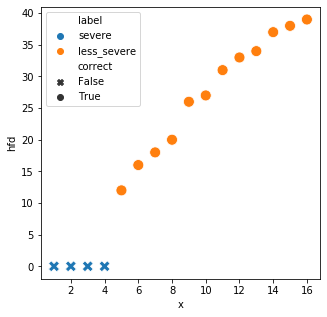

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


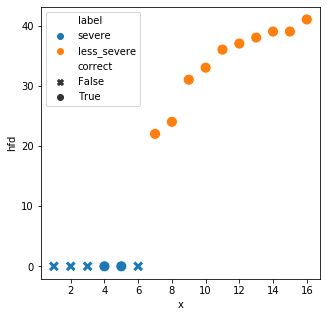

day cutoff12
fold= 0
accuracy:  0.82, recall: 0.57, precision: 1.00, metric means: 0.80


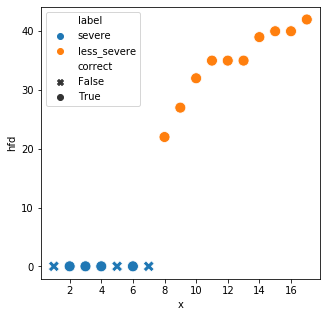

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


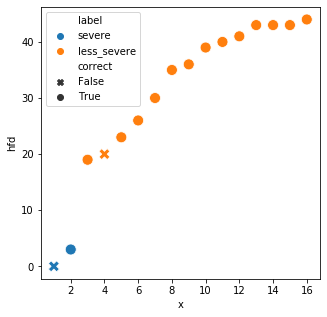

fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72


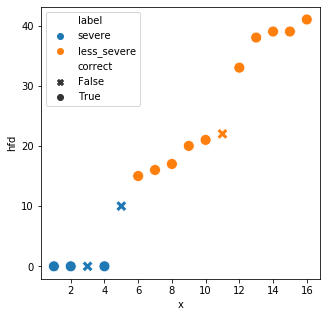

fold= 3
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


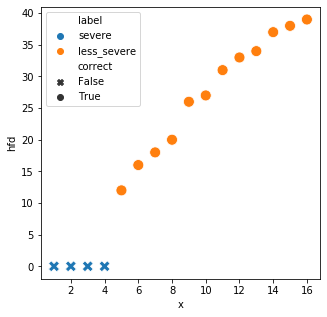

fold= 4
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69


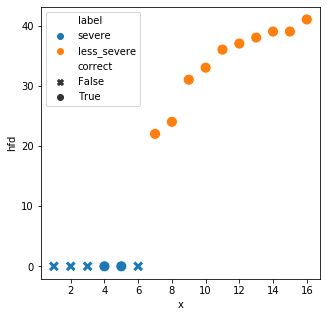

day cutoff13
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66


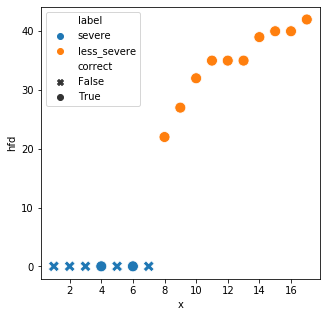

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


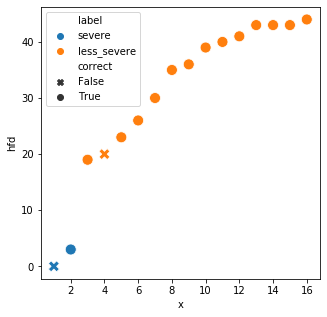

fold= 2
accuracy:  0.75, recall: 0.40, precision: 0.67, metric means: 0.61


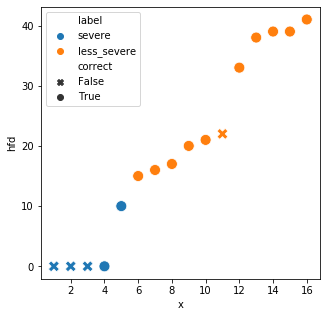

fold= 3
accuracy:  0.69, recall: 0.00, precision: 0.00, metric means: 0.23


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


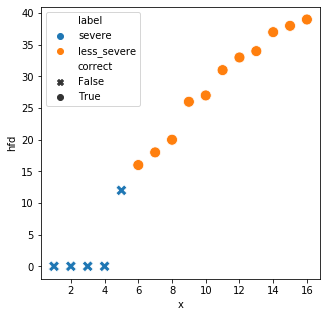

fold= 4
accuracy:  0.81, recall: 0.50, precision: 1.00, metric means: 0.77


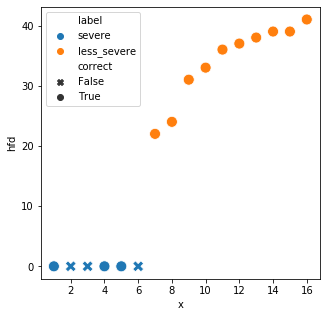

day cutoff14
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66


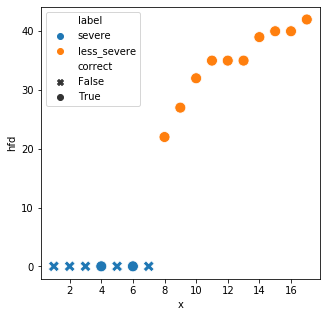

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


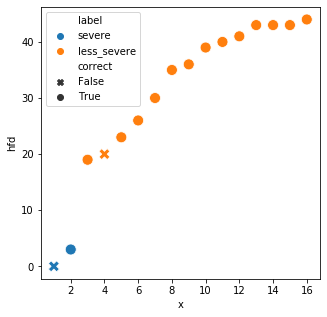

fold= 2
accuracy:  0.75, recall: 0.40, precision: 0.67, metric means: 0.61


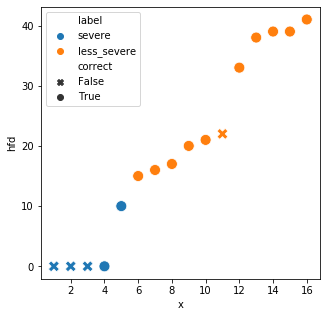

fold= 3
accuracy:  0.69, recall: 0.00, precision: 0.00, metric means: 0.23


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


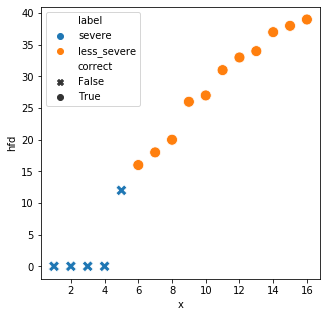

fold= 4
accuracy:  0.81, recall: 0.50, precision: 1.00, metric means: 0.77


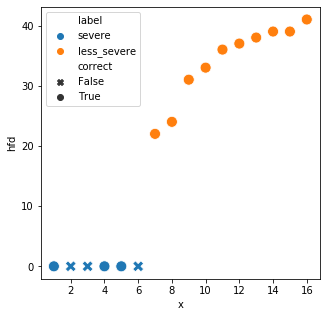

day cutoff15
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66


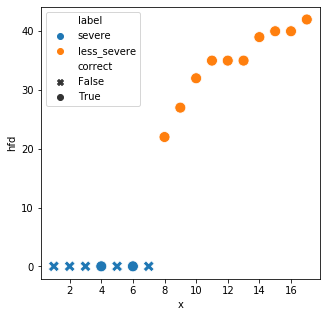

fold= 1
accuracy:  0.88, recall: 0.50, precision: 0.50, metric means: 0.62


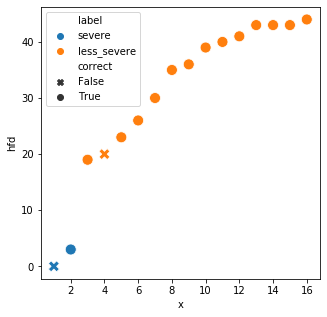

fold= 2
accuracy:  0.75, recall: 0.40, precision: 0.67, metric means: 0.61


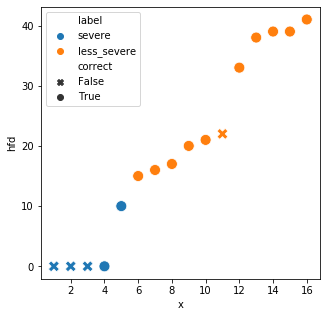

fold= 3
accuracy:  0.69, recall: 0.00, precision: 0.00, metric means: 0.23


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


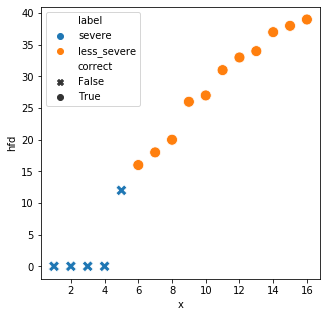

fold= 4
accuracy:  0.81, recall: 0.50, precision: 1.00, metric means: 0.77


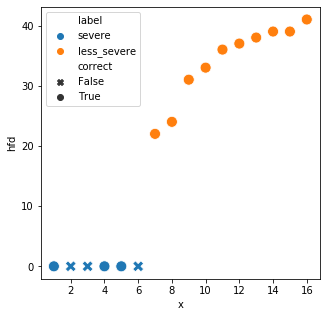

day cutoff16
fold= 0
accuracy:  0.82, recall: 0.57, precision: 1.00, metric means: 0.80


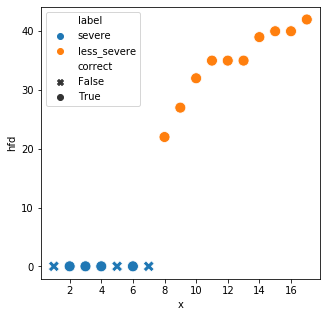

fold= 1
accuracy:  0.81, recall: 0.50, precision: 0.33, metric means: 0.55


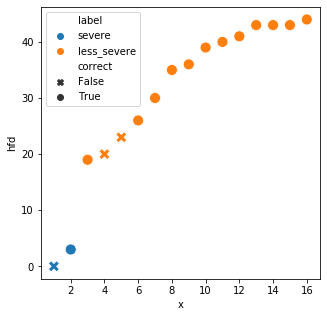

fold= 2
accuracy:  0.69, recall: 0.33, precision: 0.67, metric means: 0.56


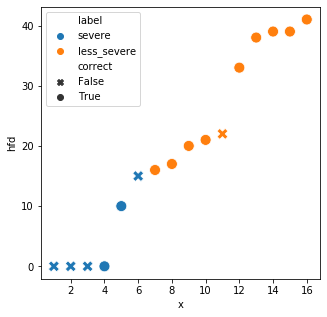

fold= 3
accuracy:  0.69, recall: 0.00, precision: 0.00, metric means: 0.23


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


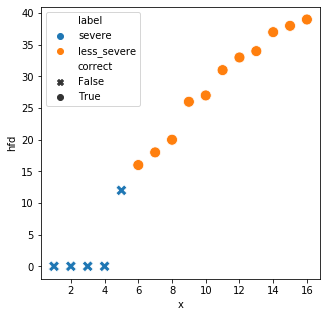

fold= 4
accuracy:  0.75, recall: 0.50, precision: 0.75, metric means: 0.67


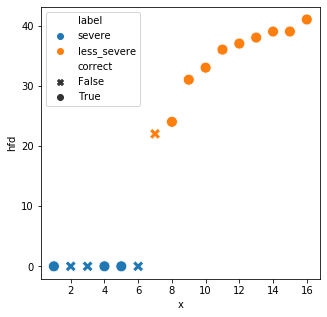

day cutoff17
fold= 0
accuracy:  0.88, recall: 0.71, precision: 1.00, metric means: 0.87


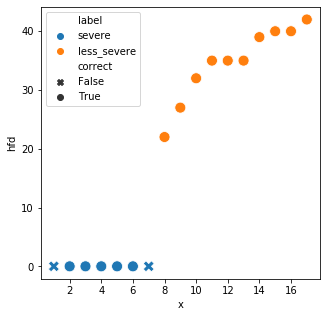

fold= 1
accuracy:  0.81, recall: 0.50, precision: 0.33, metric means: 0.55


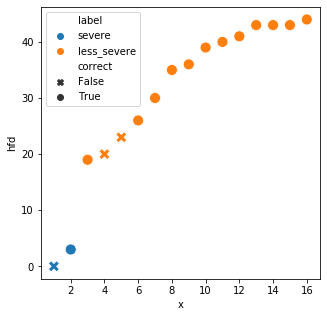

fold= 2
accuracy:  0.69, recall: 0.43, precision: 0.75, metric means: 0.62


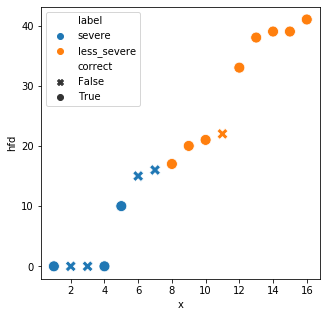

fold= 3
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


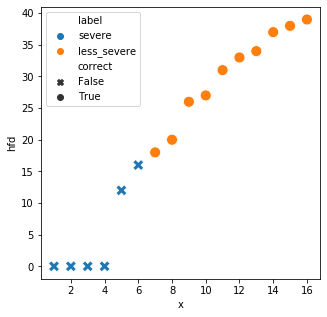

fold= 4
accuracy:  0.81, recall: 0.67, precision: 0.80, metric means: 0.76


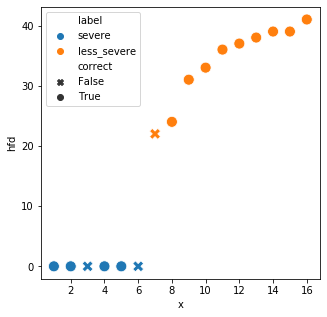

day cutoff18
fold= 0
accuracy:  0.76, recall: 0.57, precision: 0.80, metric means: 0.71


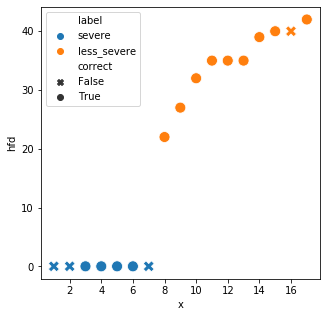

fold= 1
accuracy:  0.75, recall: 0.50, precision: 0.25, metric means: 0.50


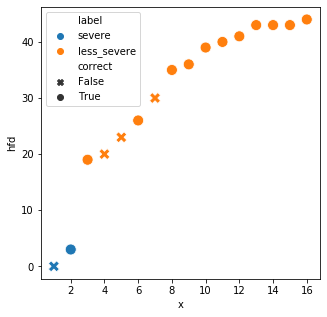

fold= 2
accuracy:  0.62, recall: 0.38, precision: 0.75, metric means: 0.58


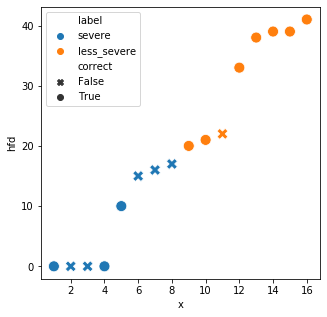

fold= 3
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


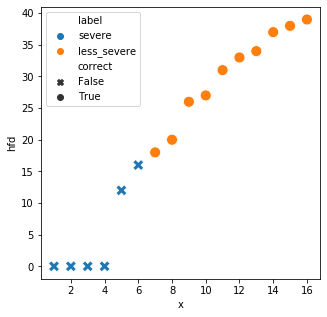

fold= 4
accuracy:  0.88, recall: 0.67, precision: 1.00, metric means: 0.85


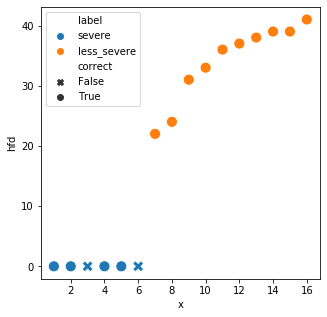

day cutoff19
fold= 0
accuracy:  0.82, recall: 0.57, precision: 1.00, metric means: 0.80


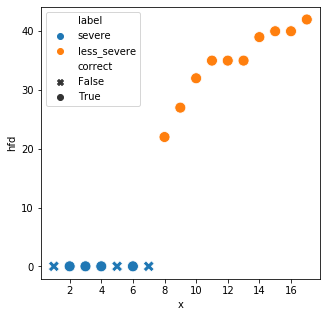

fold= 1
accuracy:  0.88, recall: 1.00, precision: 0.50, metric means: 0.79


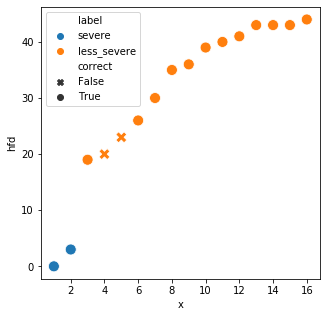

fold= 2
accuracy:  0.62, recall: 0.38, precision: 0.75, metric means: 0.58


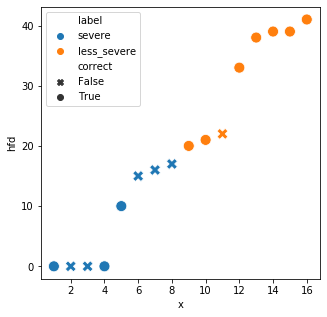

fold= 3
accuracy:  0.56, recall: 0.00, precision: 0.00, metric means: 0.19


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


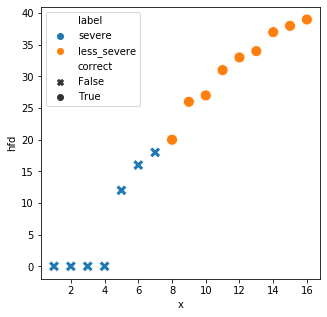

fold= 4
accuracy:  0.88, recall: 0.67, precision: 1.00, metric means: 0.85


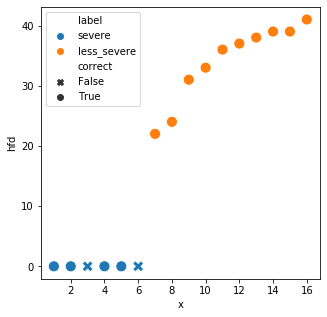

day cutoff20
fold= 0
accuracy:  0.76, recall: 0.43, precision: 1.00, metric means: 0.73


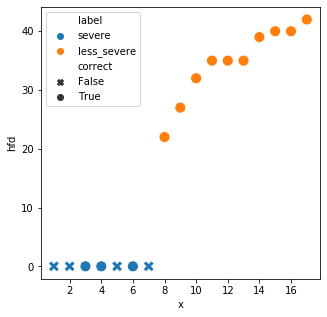

fold= 1
accuracy:  0.81, recall: 0.67, precision: 0.50, metric means: 0.66


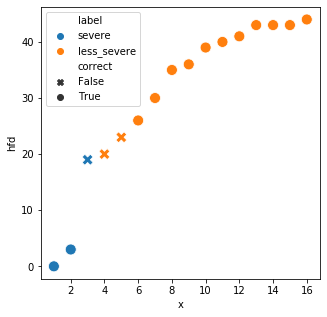

fold= 2
accuracy:  0.62, recall: 0.38, precision: 0.75, metric means: 0.58


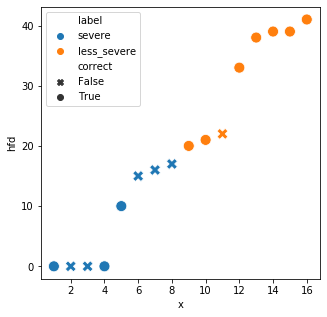

fold= 3
accuracy:  0.69, recall: 0.29, precision: 1.00, metric means: 0.66


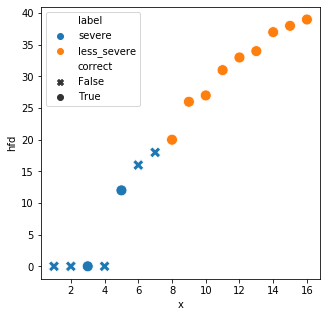

fold= 4
accuracy:  0.88, recall: 0.67, precision: 1.00, metric means: 0.85


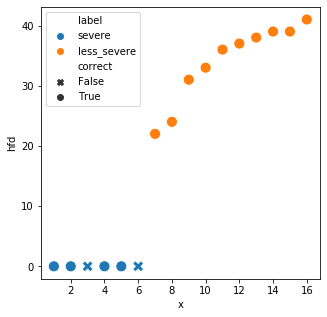

day cutoff21
fold= 0
accuracy:  0.88, recall: 0.71, precision: 1.00, metric means: 0.87


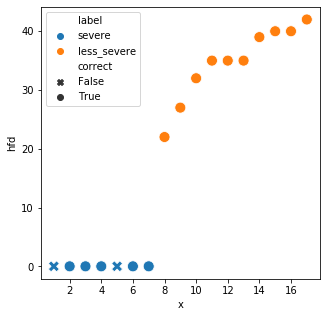

fold= 1
accuracy:  0.81, recall: 0.75, precision: 0.60, metric means: 0.72


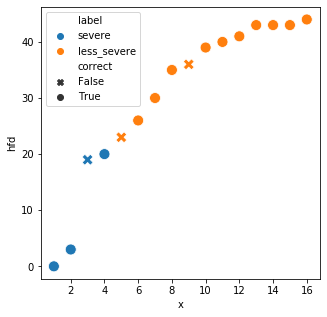

fold= 2
accuracy:  0.62, recall: 0.56, precision: 0.71, metric means: 0.63


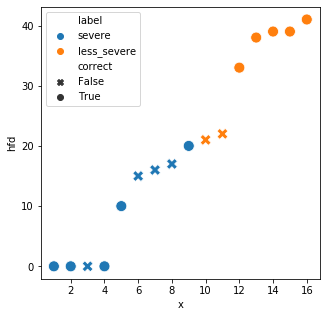

fold= 3
accuracy:  0.69, recall: 0.38, precision: 1.00, metric means: 0.69


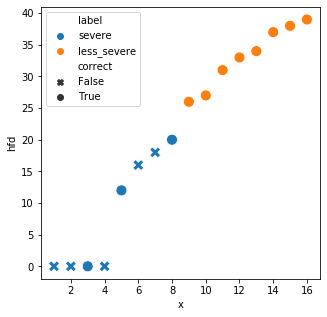

fold= 4
accuracy:  0.94, recall: 0.83, precision: 1.00, metric means: 0.92


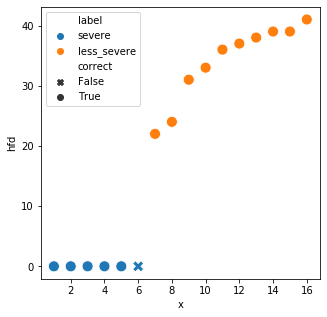

day cutoff22
fold= 0
accuracy:  0.94, recall: 0.86, precision: 1.00, metric means: 0.93


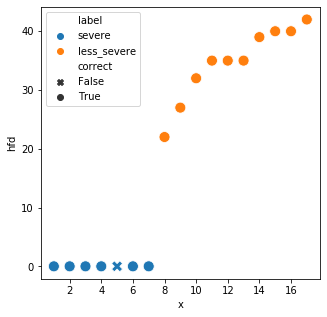

fold= 1
accuracy:  0.88, recall: 1.00, precision: 0.67, metric means: 0.85


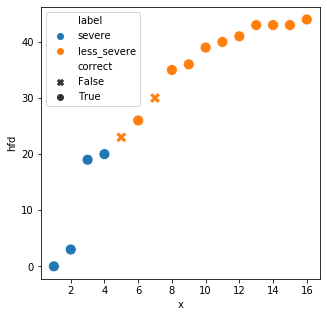

fold= 2
accuracy:  0.69, recall: 0.60, precision: 0.86, metric means: 0.71


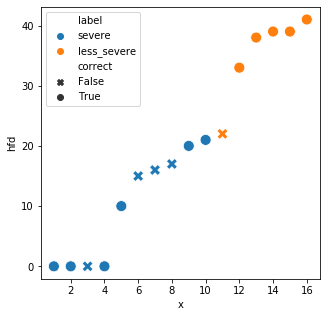

fold= 3
accuracy:  0.62, recall: 0.38, precision: 0.75, metric means: 0.58


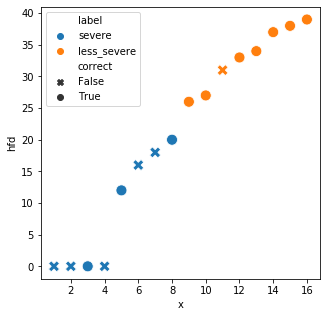

fold= 4
accuracy:  0.94, recall: 0.83, precision: 1.00, metric means: 0.92


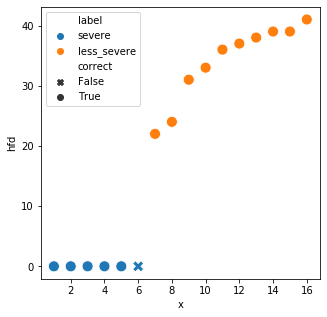

day cutoff23
fold= 0
accuracy:  0.88, recall: 0.88, precision: 0.88, metric means: 0.88


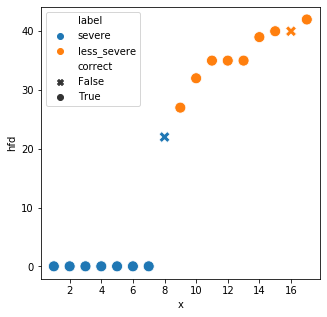

fold= 1
accuracy:  0.88, recall: 1.00, precision: 0.67, metric means: 0.85


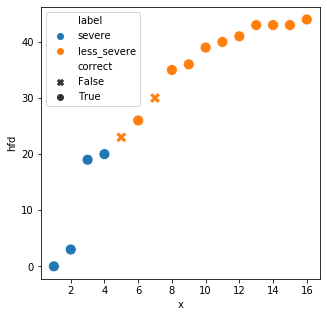

fold= 2
accuracy:  0.69, recall: 0.55, precision: 1.00, metric means: 0.74


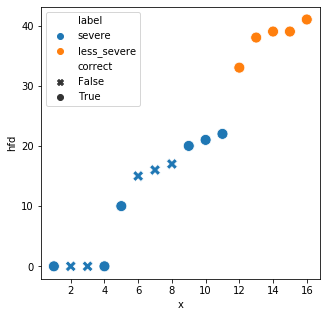

fold= 3
accuracy:  0.75, recall: 0.50, precision: 1.00, metric means: 0.75


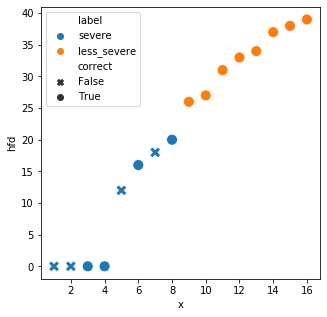

fold= 4
accuracy:  0.81, recall: 0.86, precision: 0.75, metric means: 0.81


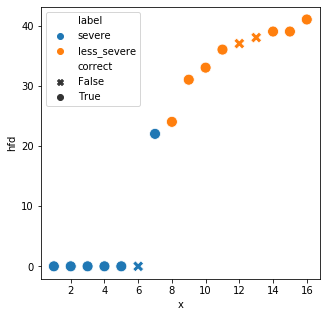

day cutoff24
fold= 0
accuracy:  0.88, recall: 0.88, precision: 0.88, metric means: 0.88


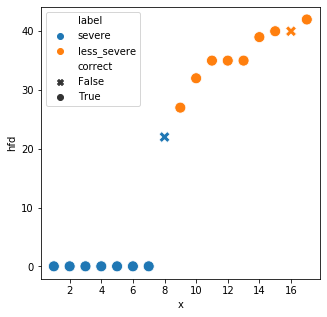

fold= 1
accuracy:  0.94, recall: 1.00, precision: 0.83, metric means: 0.92


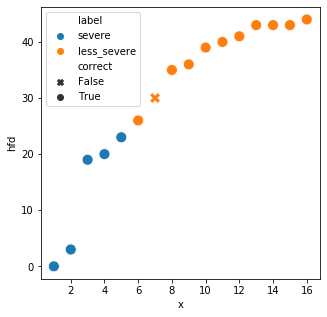

fold= 2
accuracy:  0.81, recall: 0.73, precision: 1.00, metric means: 0.85


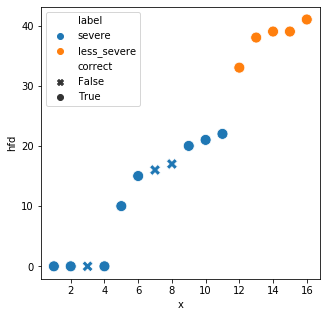

fold= 3
accuracy:  0.75, recall: 0.50, precision: 1.00, metric means: 0.75


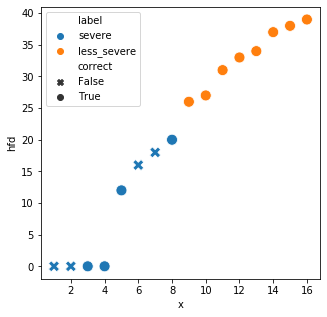

fold= 4
accuracy:  0.81, recall: 0.71, precision: 0.83, metric means: 0.79


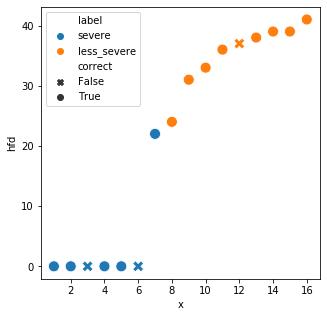

day cutoff25
fold= 0
accuracy:  0.82, recall: 0.88, precision: 0.78, metric means: 0.83


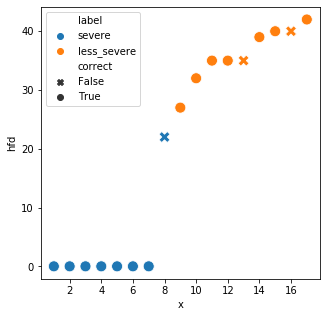

fold= 1
accuracy:  0.81, recall: 1.00, precision: 0.62, metric means: 0.81


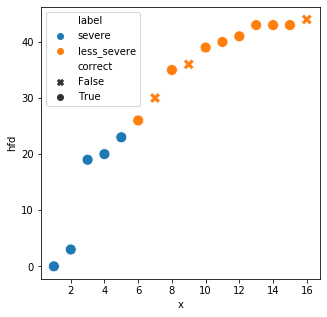

fold= 2
accuracy:  0.81, recall: 0.73, precision: 1.00, metric means: 0.85


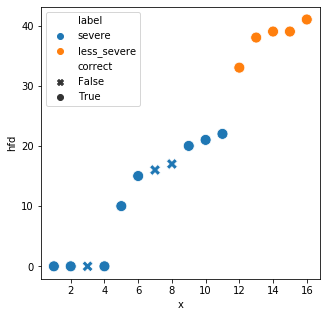

fold= 3
accuracy:  0.75, recall: 0.62, precision: 0.83, metric means: 0.74


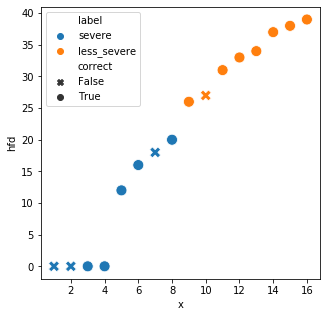

fold= 4
accuracy:  0.75, recall: 0.62, precision: 0.83, metric means: 0.74


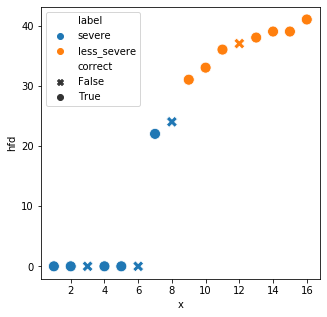

day cutoff26
fold= 0
accuracy:  0.82, recall: 0.88, precision: 0.78, metric means: 0.83


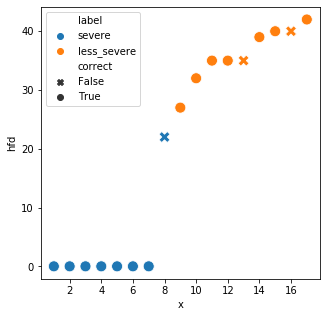

fold= 1
accuracy:  0.81, recall: 1.00, precision: 0.62, metric means: 0.81


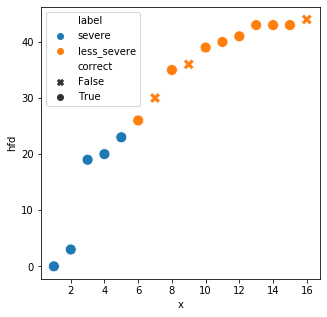

fold= 2
accuracy:  0.81, recall: 0.73, precision: 1.00, metric means: 0.85


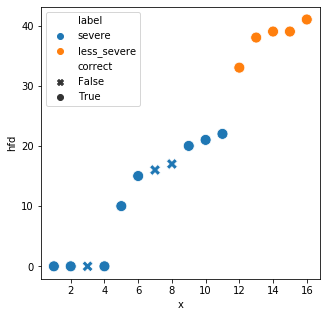

fold= 3
accuracy:  0.75, recall: 0.62, precision: 0.83, metric means: 0.74


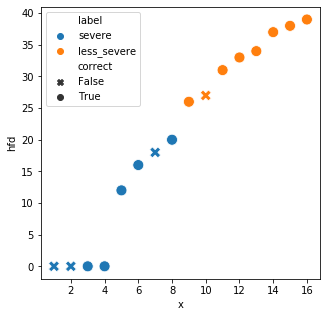

fold= 4
accuracy:  0.75, recall: 0.62, precision: 0.83, metric means: 0.74


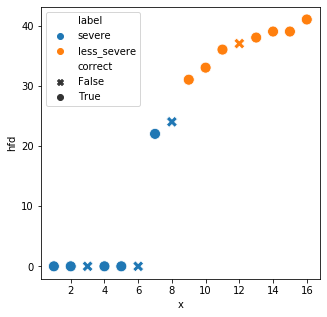

day cutoff27
fold= 0
accuracy:  0.76, recall: 0.75, precision: 0.75, metric means: 0.75


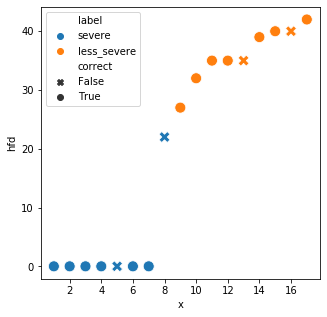

fold= 1
accuracy:  0.81, recall: 0.83, precision: 0.71, metric means: 0.79


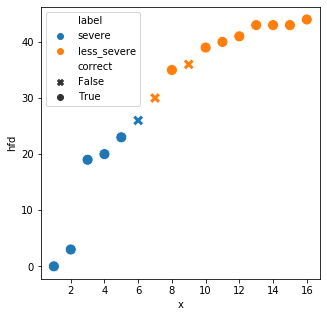

fold= 2
accuracy:  0.88, recall: 0.82, precision: 1.00, metric means: 0.90


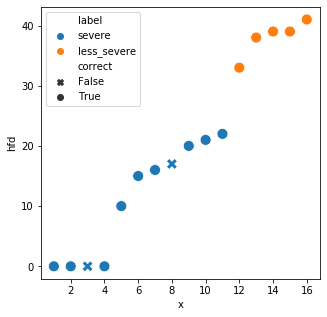

fold= 3
accuracy:  0.62, recall: 0.56, precision: 0.71, metric means: 0.63


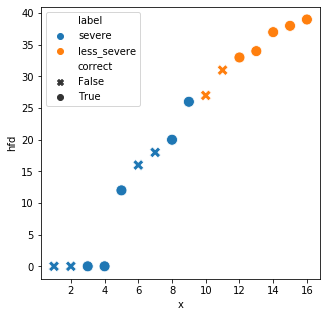

fold= 4
accuracy:  0.69, recall: 0.75, precision: 0.67, metric means: 0.70


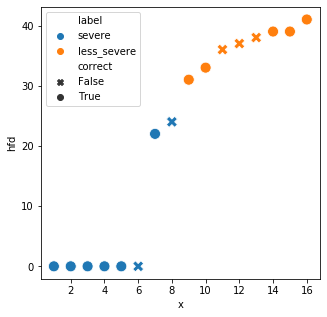

day cutoff28
fold= 0
accuracy:  0.71, recall: 0.78, precision: 0.70, metric means: 0.73


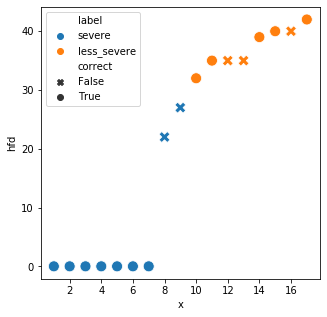

fold= 1
accuracy:  0.75, recall: 0.83, precision: 0.62, metric means: 0.74


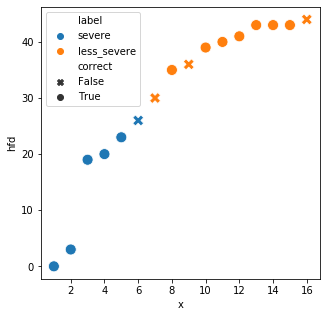

fold= 2
accuracy:  0.88, recall: 0.82, precision: 1.00, metric means: 0.90


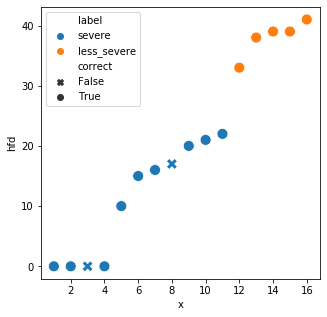

fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.86, metric means: 0.71


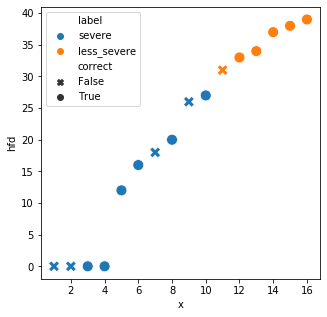

fold= 4
accuracy:  0.62, recall: 0.75, precision: 0.60, metric means: 0.66


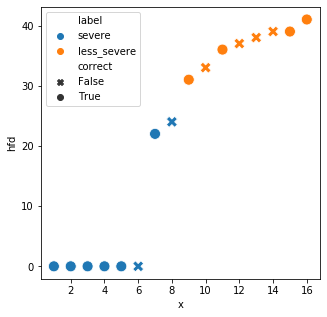

day cutoff29
fold= 0
accuracy:  0.71, recall: 0.78, precision: 0.70, metric means: 0.73


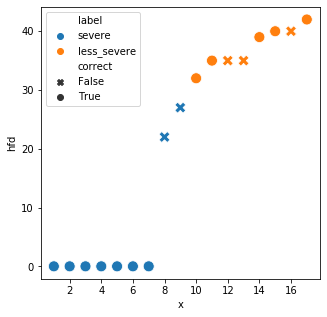

fold= 1
accuracy:  0.75, recall: 0.83, precision: 0.62, metric means: 0.74


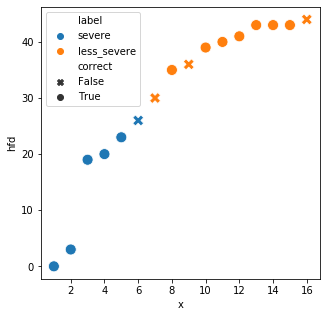

fold= 2
accuracy:  0.88, recall: 0.82, precision: 1.00, metric means: 0.90


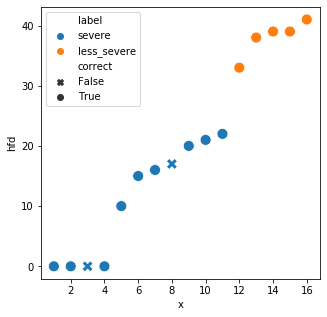

fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.86, metric means: 0.71


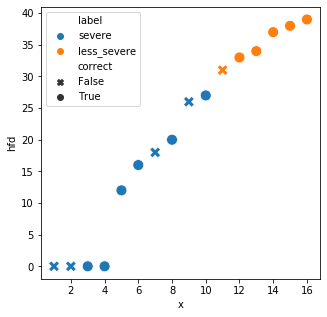

fold= 4
accuracy:  0.62, recall: 0.75, precision: 0.60, metric means: 0.66


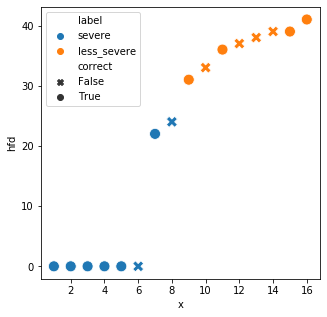

day cutoff30
fold= 0
accuracy:  0.71, recall: 0.78, precision: 0.70, metric means: 0.73


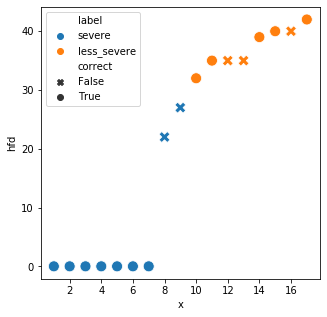

fold= 1
accuracy:  0.75, recall: 0.83, precision: 0.62, metric means: 0.74


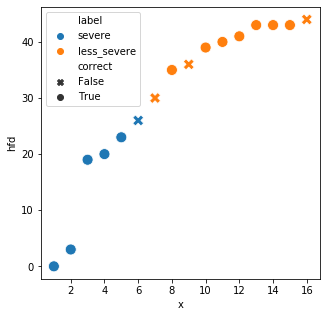

fold= 2
accuracy:  0.88, recall: 0.82, precision: 1.00, metric means: 0.90


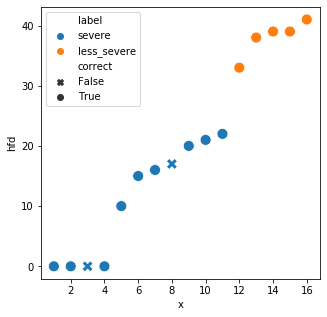

fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.86, metric means: 0.71


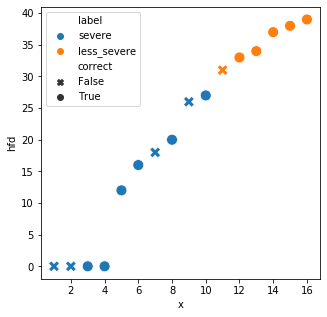

fold= 4
accuracy:  0.62, recall: 0.75, precision: 0.60, metric means: 0.66


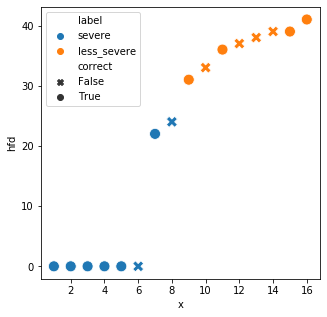

day cutoff31
fold= 0
accuracy:  0.71, recall: 0.67, precision: 0.75, metric means: 0.71


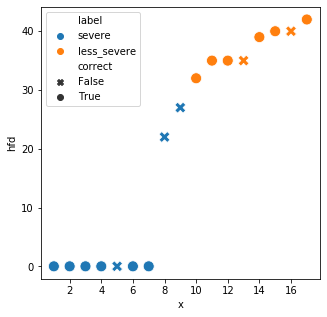

fold= 1
accuracy:  0.81, recall: 0.86, precision: 0.75, metric means: 0.81


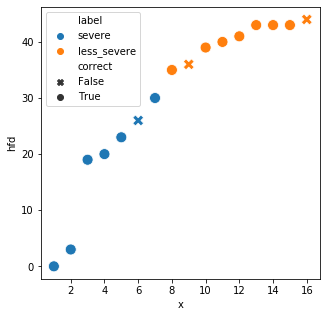

fold= 2
accuracy:  0.88, recall: 0.82, precision: 1.00, metric means: 0.90


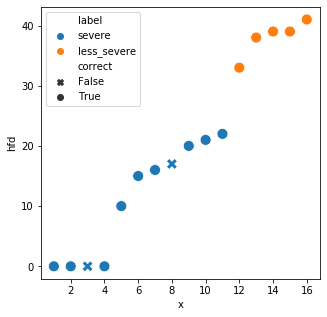

fold= 3
accuracy:  0.62, recall: 0.60, precision: 0.75, metric means: 0.66


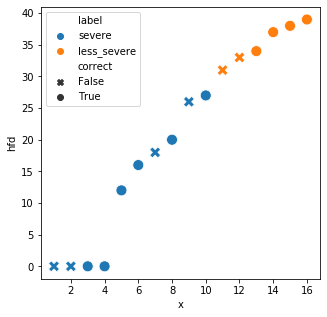

fold= 4
accuracy:  0.56, recall: 0.75, precision: 0.55, metric means: 0.62


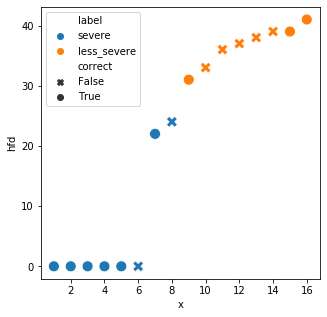

day cutoff32
fold= 0
accuracy:  0.59, recall: 0.78, precision: 0.58, metric means: 0.65


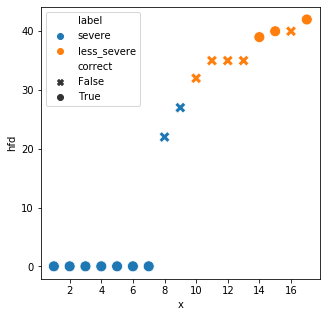

fold= 1
accuracy:  0.81, recall: 0.86, precision: 0.75, metric means: 0.81


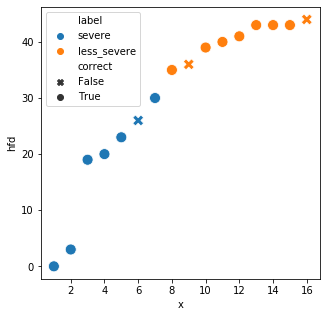

fold= 2
accuracy:  0.94, recall: 0.91, precision: 1.00, metric means: 0.95


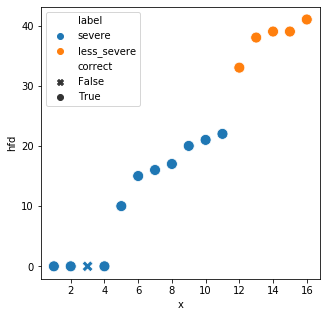

fold= 3
accuracy:  0.69, recall: 0.55, precision: 1.00, metric means: 0.74


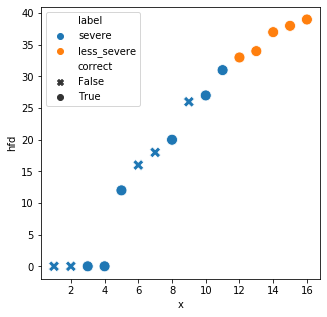

fold= 4
accuracy:  0.50, recall: 0.67, precision: 0.55, metric means: 0.57


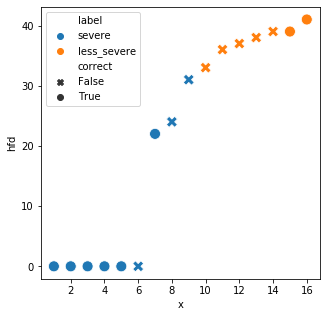

day cutoff33
fold= 0
accuracy:  0.65, recall: 0.80, precision: 0.67, metric means: 0.70


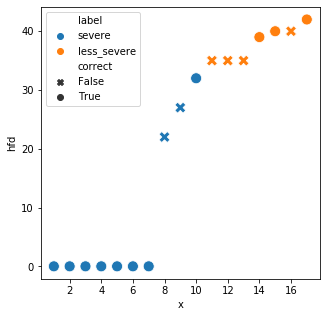

fold= 1
accuracy:  0.81, recall: 0.86, precision: 0.75, metric means: 0.81


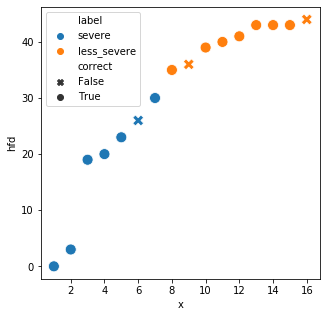

fold= 2
accuracy:  0.88, recall: 0.91, precision: 0.91, metric means: 0.90


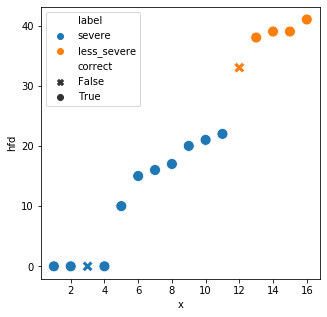

fold= 3
accuracy:  0.69, recall: 0.73, precision: 0.80, metric means: 0.74


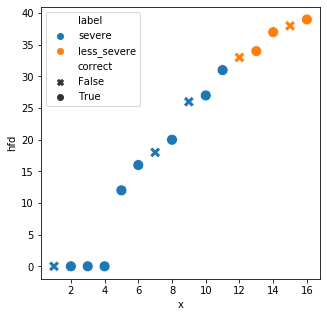

fold= 4
accuracy:  0.56, recall: 0.67, precision: 0.60, metric means: 0.61


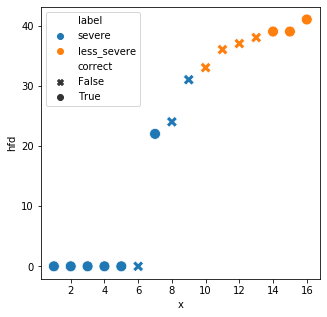

day cutoff34
fold= 0
accuracy:  0.59, recall: 0.90, precision: 0.60, metric means: 0.70


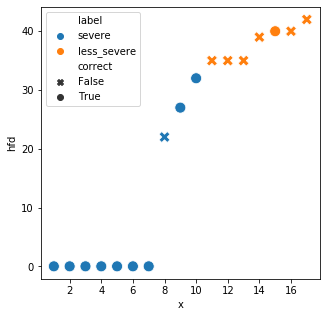

fold= 1
accuracy:  0.81, recall: 1.00, precision: 0.70, metric means: 0.84


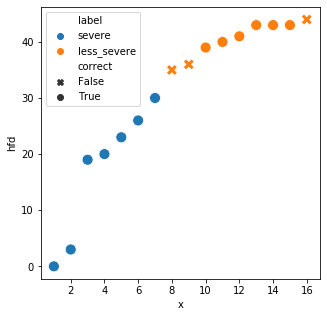

fold= 2
accuracy:  1.00, recall: 1.00, precision: 1.00, metric means: 1.00


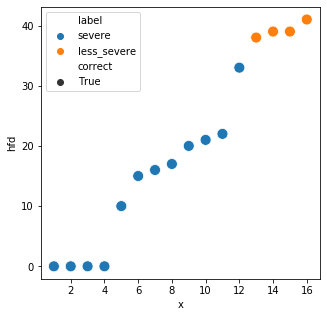

fold= 3
accuracy:  0.75, recall: 0.75, precision: 0.90, metric means: 0.80


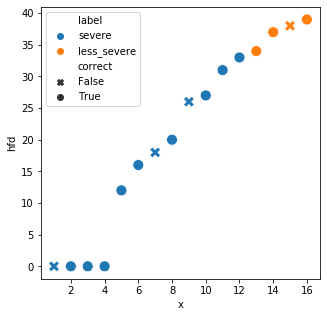

fold= 4
accuracy:  0.56, recall: 0.80, precision: 0.62, metric means: 0.66


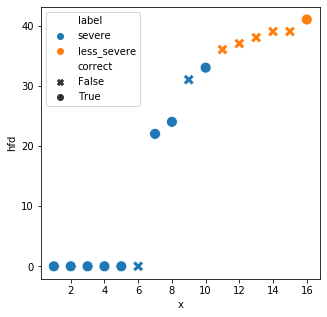

In [65]:
proteomics_metrics_dict = compare_cutoffs_kfold('proteomics', df_dict, quant_range_dict, plot=True)

In [54]:
METRICS= ['accuracy', 'recall', 'precision', 'average_precision', 'roc_auc','f1']
METRICS[0]

'accuracy'

In [100]:

METRICS= ['accuracy', 'recall', 'precision', 'average_precision', 'roc_auc','f1']
def plot_metrics_vs_daythresh(metrics_dict, metrics, plotname, savefigure=False):
    # concatenate metrics of interest
    all_metrics = []
    for i in range(len(metrics)):
        all_metrics+= metrics_dict[metrics[i]]
    ### make repeats of metric names for df
    new_list=[]
    for value in metrics:
        new_list.extend(repeat(value,len(metrics_dict[metrics[0]])))
    # make repeats of the day threshold
    day =[]
    for i in range(len(metrics)):
        day+=proteomics_metrics_dict['day_thresh']
    # make pandas dataframe and plot
    lineplot_df = pd.DataFrame({'day':day, 'all_metrics':all_metrics, 'metric_type':new_list})
    plt.rcParams['figure.figsize'] = 5,5
    sns.lineplot('day', 'all_metrics', 
            data=lineplot_df,
            hue='metric_type')
    #plt.plot(xvalues[local_max], np.asarray(metmeanbyfold)[local_max], "ko", label="max", fillstyle='none')
    plt.title(plotname+', 5-fold CV')
    if(savefigure):
        plt.savefig(plotname+'_threshold.svg')

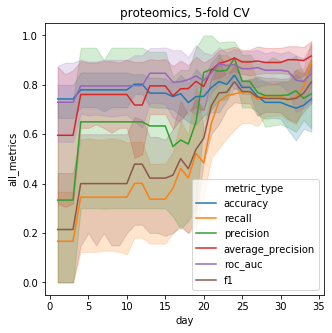

In [279]:
plot_metrics_vs_daythresh(proteomics_metrics_dict, METRICS, 'proteomics', savefigure=True)

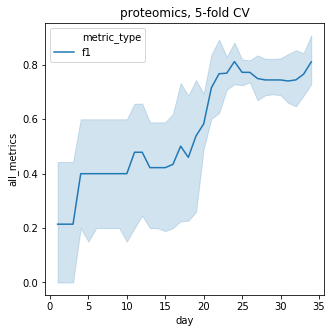

In [102]:
plot_metrics_vs_daythresh(proteomics_metrics_dict, ['f1'], 'proteomics')

In [66]:
met_metric_dict = compare_cutoffs_kfold('metabolomics', df_dict, quant_range_dict, plot=False)

dataset is metabolomics
dropped columns = 45
measurements used 110
day cutoff1
fold= 0
accuracy:  0.76, recall: 0.43, precision: 1.00, metric means: 0.73
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
fold= 3
accuracy:  0.69, recall: 0.00, precision: 0.00, metric means: 0.23
fold= 4
accuracy:  0.62, recall: 0.33, precision: 0.50, metric means: 0.49
day cutoff2
fold= 0
accuracy:  0.76, recall: 0.43, precision: 1.00, metric means: 0.73
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
fold= 3


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.69, recall: 0.00, precision: 0.00, metric means: 0.23
fold= 4
accuracy:  0.62, recall: 0.33, precision: 0.50, metric means: 0.49
day cutoff3
fold= 0
accuracy:  0.76, recall: 0.43, precision: 1.00, metric means: 0.73
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
fold= 3
accuracy:  0.69, recall: 0.00, precision: 0.00, metric means: 0.23
fold= 4


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.33, precision: 0.50, metric means: 0.49
day cutoff4
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66
fold= 1
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
fold= 2
accuracy:  0.75, recall: 0.25, precision: 0.50, metric means: 0.50
fold= 3
accuracy:  0.81, recall: 0.25, precision: 1.00, metric means: 0.69
fold= 4
accuracy:  0.62, recall: 0.33, precision: 0.50, metric means: 0.49
day cutoff5
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66
fold= 1
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
fold= 2
accuracy:  0.75, recall: 0.25, precision: 0.50, metric means: 0.50
fold= 3
accuracy:  0.81, recall: 0.25, precision: 1.00, metric means: 0.69
fold= 4
accuracy:  0.62, recall: 0.33, precision: 0.50, metric means: 0.49
day cutoff6
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66
fold= 1
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.

C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



fold= 4
accuracy:  0.69, recall: 0.67, precision: 0.57, metric means: 0.64
day cutoff18
fold= 0
accuracy:  0.76, recall: 0.43, precision: 1.00, metric means: 0.73
fold= 1
accuracy:  0.75, recall: 0.50, precision: 0.25, metric means: 0.50
fold= 2
accuracy:  0.50, recall: 0.12, precision: 0.50, metric means: 0.38
fold= 3
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 4


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.33, precision: 0.50, metric means: 0.49
day cutoff19
fold= 0
accuracy:  0.82, recall: 0.57, precision: 1.00, metric means: 0.80
fold= 1
accuracy:  0.69, recall: 1.00, precision: 0.29, metric means: 0.66
fold= 2
accuracy:  0.50, recall: 0.12, precision: 0.50, metric means: 0.38
fold= 3
accuracy:  0.56, recall: 0.00, precision: 0.00, metric means: 0.19
fold= 4
accuracy:  0.69, recall: 0.50, precision: 0.60, metric means: 0.60
day cutoff20


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fold= 0
accuracy:  0.71, recall: 0.43, precision: 0.75, metric means: 0.63
fold= 1
accuracy:  0.75, recall: 1.00, precision: 0.43, metric means: 0.73
fold= 2
accuracy:  0.50, recall: 0.12, precision: 0.50, metric means: 0.38
fold= 3
accuracy:  0.50, recall: 0.00, precision: 0.00, metric means: 0.17
fold= 4
accuracy:  0.69, recall: 0.50, precision: 0.60, metric means: 0.60
day cutoff21
fold= 0
accuracy:  0.82, recall: 0.57, precision: 1.00, metric means: 0.80
fold= 1
accuracy:  0.88, recall: 1.00, precision: 0.67, metric means: 0.85
fold= 2
accuracy:  0.44, recall: 0.22, precision: 0.50, metric means: 0.39
fold= 3
accuracy:  0.69, recall: 0.50, precision: 0.80, metric means: 0.66
fold= 4
accuracy:  0.62, recall: 0.50, precision: 0.50, metric means: 0.54
day cutoff22
fold= 0
accuracy:  0.88, recall: 0.71, precision: 1.00, metric means: 0.87
fold= 1
accuracy:  0.88, recall: 1.00, precision: 0.67, metric means: 0.85
fold= 2
accuracy:  0.50, recall: 0.30, precision: 0.75, metric means: 0.52

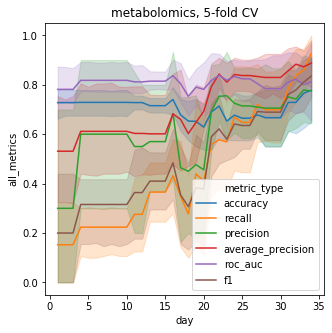

In [278]:

plot_metrics_vs_daythresh(met_metric_dict, METRICS, 'metabolomics', savefigure=True)

In [89]:
lip_metric_dict = compare_cutoffs_kfold('lipidomics', df_dict, quant_range_dict, plot=False)

dataset is lipidomics
dropped columns = 2711
measurements used 646
day cutoff1
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66
fold= 1
accuracy:  0.94, recall: 1.00, precision: 0.50, metric means: 0.81
fold= 2
accuracy:  0.81, recall: 0.75, precision: 0.60, metric means: 0.72
fold= 3
accuracy:  0.81, recall: 0.25, precision: 1.00, metric means: 0.69
fold= 4
accuracy:  0.88, recall: 0.67, precision: 1.00, metric means: 0.85
day cutoff2
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66
fold= 1
accuracy:  0.94, recall: 1.00, precision: 0.50, metric means: 0.81
fold= 2
accuracy:  0.81, recall: 0.75, precision: 0.60, metric means: 0.72
fold= 3
accuracy:  0.81, recall: 0.25, precision: 1.00, metric means: 0.69
fold= 4
accuracy:  0.88, recall: 0.67, precision: 1.00, metric means: 0.85
day cutoff3
fold= 0
accuracy:  0.71, recall: 0.29, precision: 1.00, metric means: 0.66
fold= 1
accuracy:  0.94, recall: 1.00, precision: 0.50, metric means: 0.

accuracy:  0.82, recall: 0.71, precision: 0.83, metric means: 0.79
fold= 1
accuracy:  0.81, recall: 0.75, precision: 0.60, metric means: 0.72
fold= 2
accuracy:  0.75, recall: 0.60, precision: 1.00, metric means: 0.78
fold= 3
accuracy:  0.75, recall: 0.50, precision: 1.00, metric means: 0.75
fold= 4
accuracy:  0.75, recall: 0.67, precision: 0.67, metric means: 0.69
day cutoff23
fold= 0
accuracy:  0.76, recall: 0.62, precision: 0.83, metric means: 0.74
fold= 1
accuracy:  0.81, recall: 0.75, precision: 0.60, metric means: 0.72
fold= 2
accuracy:  0.75, recall: 0.64, precision: 1.00, metric means: 0.80
fold= 3
accuracy:  0.81, recall: 0.62, precision: 1.00, metric means: 0.81
fold= 4
accuracy:  0.75, recall: 0.71, precision: 0.71, metric means: 0.73
day cutoff24
fold= 0
accuracy:  0.94, recall: 0.88, precision: 1.00, metric means: 0.94
fold= 1
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65
fold= 2
accuracy:  0.81, recall: 0.73, precision: 1.00, metric means: 0.85
fold= 3

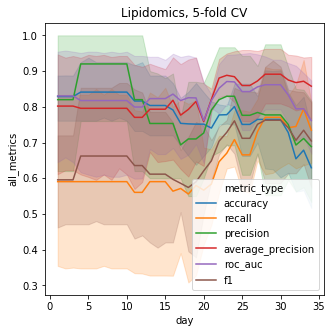

In [275]:
plot_metrics_vs_daythresh(lip_metric_dict, METRICS, 'Lipidomics', savefigure=True)

In [91]:
transcript_metric_dict = compare_cutoffs_kfold('transcriptomics', df_dict, quant_range_dict, plot=False)

dataset is transcriptomics
dropped columns = 0
measurements used 13263
day cutoff1
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff2
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff3
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff4
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff5
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff6
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff7
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21

C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff8
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff9
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff10
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.69, recall: 0.50, precision: 0.40, metric means: 0.53
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff11
fold= 0
accuracy:  0.69, recall: 0.17, precision: 1.00, metric means: 0.62
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65
fold= 3
accuracy:  0.62, recall: 0.60, precision: 0.43, metric means: 0.55
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff12
fold= 0
accuracy:  0.69, recall: 0.17, precision: 1.00, metric means: 0.62
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65
fold= 3
accuracy:  0.62, recall: 0.60, precision: 0.43, metric means: 0.55
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff13
fold= 0
accuracy:  0.69, recall: 0.17, precision: 1.00, metric means: 0.62
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65
fold= 3
accuracy:  0.62, recall: 0.60, precision: 0.43, metric means: 0.55
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff14
fold= 0
accuracy:  0.69, recall: 0.17, precision: 1.00, metric means: 0.62
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65
fold= 3
accuracy:  0.62, recall: 0.60, precision: 0.43, metric means: 0.55
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff15
fold= 0
accuracy:  0.69, recall: 0.17, precision: 1.00, metric means: 0.62
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65
fold= 3
accuracy:  0.62, recall: 0.60, precision: 0.43, metric means: 0.55
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff16
fold= 0
accuracy:  0.62, recall: 0.17, precision: 0.50, metric means: 0.43
fold= 1
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65
fold= 3
accuracy:  0.56, recall: 0.50, precision: 0.43, metric means: 0.50
fold= 4
accuracy:  0.69, recall: 0.00, precision: 0.00, metric means: 0.23
day cutoff17
fold= 0
accuracy:  0.69, recall: 0.33, precision: 0.67, metric means: 0.56
fold= 1
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 3
accuracy:  0.62, recall: 0.57, precision: 0.57, metric means: 0.59
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cut

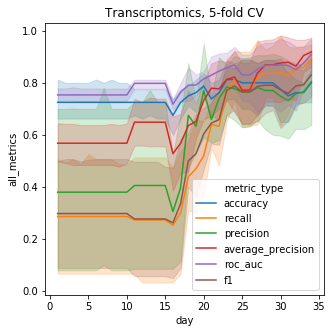

In [276]:
plot_metrics_vs_daythresh(transcript_metric_dict, METRICS, 'Transcriptomics', savefigure=True)

In [93]:
comb_metric_dict = compare_cutoffs_kfold('combined', df_dict, quant_range_dict, plot=False)

dataset is combined
dropped columns = 2756
measurements used 14536
day cutoff1
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff2
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff3
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21

C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff4
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff5
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff6
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff7
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff8
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff9
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21

C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



fold= 1
accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff10
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.75, recall: 0.50, precision: 0.50, metric means: 0.58
fold= 3
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 4
accuracy:  0.75, recall: 0.00, precision: 0.00, metric means: 0.25
day cutoff11
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21

C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55
day cutoff12
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55
day cutoff13
fold= 0


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55
day cutoff14
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21

C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55
day cutoff15
fold= 0
accuracy:  0.62, recall: 0.00, precision: 0.00, metric means: 0.21
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 3
accuracy:  0.69, recall: 0.60, precision: 0.50, metric means: 0.60
fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55
day cutoff16
fold= 0
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69
fold= 1


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.81, recall: 0.00, precision: 0.00, metric means: 0.27
fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 3
accuracy:  0.62, recall: 0.50, precision: 0.50, metric means: 0.54
fold= 4
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55
day cutoff17
fold= 0
accuracy:  0.62, recall: 0.17, precision: 0.50, metric means: 0.43
fold= 1
accuracy:  0.88, recall: 0.33, precision: 1.00, metric means: 0.74
fold= 2
accuracy:  0.75, recall: 0.60, precision: 0.60, metric means: 0.65
fold= 3
accuracy:  0.56, recall: 0.43, precision: 0.50, metric means: 0.50
fold= 4
accuracy:  0.75, recall: 0.33, precision: 0.33, metric means: 0.47
day cutoff18
fold= 0
accuracy:  0.75, recall: 0.33, precision: 1.00, metric means: 0.69
fold= 1
accuracy:  0.81, recall: 0.33, precision: 0.50, metric means: 0.55
fold= 2
accuracy:  0.81, recall: 0.60, precision: 0.75, metric means: 0.72
fold= 3
accuracy:  0.62, recall: 0.57, precision: 0.57, metric means: 0.59
fold= 4

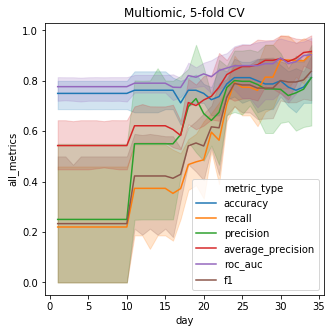

In [277]:
plot_metrics_vs_daythresh(comb_metric_dict, METRICS, 'Multiomic', savefigure=True)

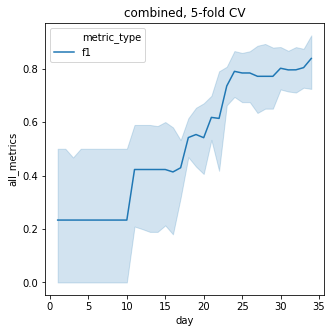

In [103]:
plot_metrics_vs_daythresh(comb_metric_dict, ['f1'], 'combined')

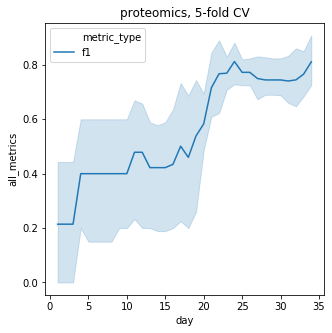

In [104]:
plot_metrics_vs_daythresh(proteomics_metrics_dict, ['f1'], 'proteomics')

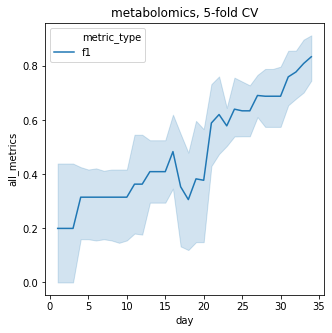

In [107]:
plot_metrics_vs_daythresh(met_metric_dict, ['f1'], 'metabolomics')

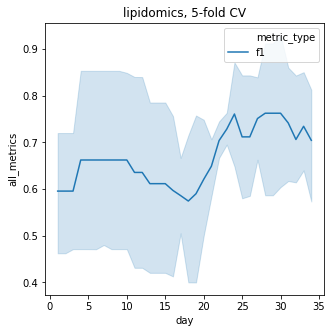

In [108]:
plot_metrics_vs_daythresh(lip_metric_dict, ['f1'], 'lipidomics')

In [207]:

METRIC='f1'
def plot_onemetric(metrics_dict, metric, plotname, savefigure=False):
    # concatenate metrics of interest
    
    kfolds=5
    tmp_metric = metrics_dict[metric]
    plt.rcParams['figure.figsize'] = 5,1
    metmeanbyfold = [sum(tmp_metric[i:i+kfolds])/kfolds for i in range(0,len(tmp_metric),kfolds)]
    #a = diff(sign(diff(metmeanbyfold))).nonzero()[0] + 1 # local min+max
    #b = (diff(sign(diff(metmeanbyfold))) > 0).nonzero()[0] + 1 # local min
    local_max = (np.diff(np.sign(np.diff(metmeanbyfold))) < 0).nonzero()[0] + 1 # local max
    print(local_max)
    print('global max = ' +str(max(metmeanbyfold)))
    
    xvalues = np.linspace(1,35,35)
    plt.plot(range(1,35),metmeanbyfold)
    #plot(x[b], np.asarray(metmeanbyfold)[b], "o", label="min")
    plt.plot(xvalues[local_max], np.asarray(metmeanbyfold)[local_max], "o", label="max")
    plt.plot(xvalues[23], np.asarray(metmeanbyfold)[23], "ko", label="max")
    print('local max @ 24 days = ' + str(np.asarray(metmeanbyfold)[23]))
    #plt.legend()
    plt.ylim(0,1)
    plt.title(plotname +' local maxima')
    plt.ylabel(metric)
    plt.xlabel('hospital free days threshold')
    if(savefigure):
        plt.savefig(plotname + '_' + metric + '_localmax.svg', bbox_inches = "tight")


[ 2  9 12 15 18 22 27 29 32]
global max = 0.8912654475154476
local max @ 24 days = 0.8842698967698966


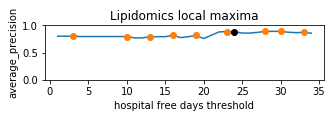

In [208]:
plot_onemetric(lip_metric_dict, 'average_precision', 'Lipidomics')


[ 3  9 11 14 23 27 29 32]
global max = 0.7624944714727996
local max @ 24 days = 0.7608020050125314


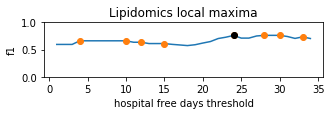

In [209]:
plot_onemetric(lip_metric_dict, 'f1', 'Lipidomics', savefigure=True)

[ 3 10 12 15 18 21 23 26]
global max = 0.8352657004830917
local max @ 24 days = 0.6413542340012929


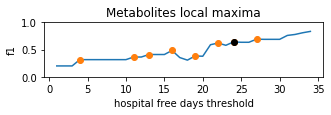

In [210]:
plot_onemetric(met_metric_dict, 'f1', 'Metabolites', savefigure=True)

[ 9 14 23 27 28]
global max = 0.8304981250633425
local max @ 24 days = 0.7875213675213676


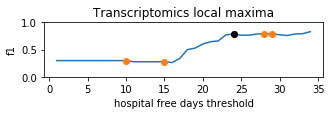

In [211]:
plot_onemetric(transcript_metric_dict, 'f1', 'Transcriptomics', savefigure=True)

[ 3 10 11 16 23 25 29]
global max = 0.812418721629248
local max @ 24 days = 0.812418721629248


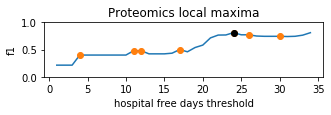

In [212]:
plot_onemetric(proteomics_metrics_dict, 'f1', 'Proteomics', savefigure=True)

[10 14 18 20 23 25 29]
global max = 0.8379342074994248
local max @ 24 days = 0.7896009872480462


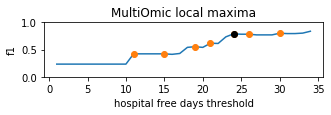

In [214]:
plot_onemetric(comb_metric_dict, 'f1', 'MultiOmic', savefigure=True)

# Hyperparameter tuning

In [219]:
# get dataset - combined first
dataset= 'combined'
DAY_CUTOFF = 24
RANDOM_SEED = 11

dfc = df_dict[dataset]
qrc = quant_range_dict[dataset]
dfc_quant_cols = dfc.columns[:qrc]
prefilter_range = len(dfc.columns)
dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='Unknown')))]
dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='unknown')))]
rangediff = prefilter_range - len(dfc.columns)
print( 'dropped columns = '+ str(rangediff))
qr_filt = qrc - rangediff
print('measurements used ' + str(qr_filt))
df = dfc[dfc['COVID']==1]
#df = dfc
X = df[df.columns[:qr_filt]]
df = df.assign(dayclass=np.zeros(len(df)))
df.loc[df['Hospital_free_days_45']<DAY_CUTOFF, 'dayclass'] = 'severe'
df.loc[df['Hospital_free_days_45']>=DAY_CUTOFF, 'dayclass'] = 'less_severe'
y = df['dayclass']
hfd = df['Hospital_free_days_45']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
X_train, X_test, hfd_train, hfd_test = train_test_split(X, hfd, test_size = 0.2, random_state = RANDOM_SEED)

dropped columns = 2756
measurements used 14536


In [216]:


RANDOM_SEED=11
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)
f1_scorer = make_scorer(f1_score, pos_label = 'severe')
et = ExtraTreesClassifier(random_state = RANDOM_SEED)
et_random = GridSearchCV(estimator = et, param_grid = random_grid, 
                               cv = 5, verbose=2, n_jobs = -1, 
                               scoring=f1_scorer)
# Fit the random search model
et_random.fit(X_train, y_train)
print(et_random.best_params_)
print(et_random.best_score_)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 54.8min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

{'bootstrap': True, 'max_depth': 115, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.6285714285714287


In [229]:

RANDOM_SEED=11
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [231]:
extraTrees_random_combined = gridsearch_omic_subset('combined', df_dict, random_grid)

dropped columns = 2756
measurements used 14536
training data shape (80, 14536)
{'n_estimators': [100, 122, 144, 166, 188, 211, 233, 255, 277, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 55, 100, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  2.5min finished


best parameters {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 277}
best f1 score = 0.7833116883116883


In [226]:
## why is the score so much worse?
# get dataset - combined first
dataset= 'combined'
DAY_CUTOFF = 24
RANDOM_SEED = 11

dfc = df_dict[dataset]
qrc = quant_range_dict[dataset]
dfc_quant_cols = dfc.columns[:qrc]
prefilter_range = len(dfc.columns)
dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='Unknown')))]
dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='unknown')))]
rangediff = prefilter_range - len(dfc.columns)
print( 'dropped columns = '+ str(rangediff))
qr_filt = qrc - rangediff
print('measurements used ' + str(qr_filt))
df = dfc[dfc['COVID']==1]
#df = dfc
X = df[df.columns[:qr_filt]]
df = df.assign(dayclass=np.zeros(len(df)))
df.loc[df['Hospital_free_days_45']<DAY_CUTOFF, 'dayclass'] = 'severe'
df.loc[df['Hospital_free_days_45']>=DAY_CUTOFF, 'dayclass'] = 'less_severe'
y = df['dayclass']
hfd = df['Hospital_free_days_45']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
X_train, X_test, hfd_train, hfd_test = train_test_split(X, hfd, test_size = 0.2, random_state = RANDOM_SEED)

xa = np.asarray(X_train)
ya = np.asarray(y_train)
ha = np.asarray(hfd_train)


fold=0
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
acc = []
recalls = []
precisions =[]
ave_precs = []
f1s = []
aucs = []

for train_index, test_index in kf.split(xa):
    print('fold= '+str(fold))
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = xa[train_index], xa[test_index]
    y_train, y_val = ya[train_index], ya[test_index]
    h_train, h_val = ha[train_index], ha[test_index]
    et = ExtraTreesClassifier(bootstrap=True, max_depth=115, 
                               max_features='sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators=200, 
                              random_state=RANDOM_SEED)
    et = ExtraTreesClassifier(random_state = RANDOM_SEED)
    et.fit(X_train, y_train)
    y_pred = et.predict(X_val)
    y_score = et.predict_proba(X_val)
    acc.append(accuracy_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred, pos_label='severe'))
    precisions.append(precision_score(y_val, y_pred, pos_label='severe'))
    ave_precs.append(average_precision_score(y_val, y_score[:,1], pos_label='severe') )
    f1s.append(f1_score(y_val, y_pred, pos_label='severe'))
    aucs.append(roc_auc_score(y_val, y_score[:,1]))
    fold+=1
print(f1s)
print('f1 mean = ' + str(np.mean(f1s)) )

dropped columns = 2756
measurements used 14536
fold= 0
fold= 1
fold= 2
fold= 3
fold= 4
[0.6153846153846153, 0.9090909090909091, 0.8235294117647058, 0.8000000000000002, 0.8000000000000002]
f1 mean = 0.7896009872480462


In [232]:
# get dataset - metabolomics
#dataset= 'metabolomics'
def gridsearch_omic_subset(dataset, df_dict, random_grid):
    DAY_CUTOFF = 24
    RANDOM_SEED = 11
    dfc = df_dict[dataset]
    qrc = quant_range_dict[dataset]
    dfc_quant_cols = dfc.columns[:qrc]
    prefilter_range = len(dfc.columns)
    dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='Unknown')))]
    dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='unknown')))]
    rangediff = prefilter_range - len(dfc.columns)
    print( 'dropped columns = '+ str(rangediff))
    qr_filt = qrc - rangediff
    print('measurements used ' + str(qr_filt))
    df = dfc[dfc['COVID']==1]
    X = df[df.columns[:qr_filt]]
    df = df.assign(dayclass=np.zeros(len(df)))
    df.loc[df['Hospital_free_days_45']<DAY_CUTOFF, 'dayclass'] = 'severe'
    df.loc[df['Hospital_free_days_45']>=DAY_CUTOFF, 'dayclass'] = 'less_severe'
    y = df['dayclass']
    hfd = df['Hospital_free_days_45']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
    X_train, X_test, hfd_train, hfd_test = train_test_split(X, hfd, test_size = 0.2, random_state = RANDOM_SEED)
    print( 'training data shape ' + str(X_train.shape) )

    print(random_grid)
    f1_scorer = make_scorer(f1_score, pos_label = 'severe')
    et = ExtraTreesClassifier(random_state=RANDOM_SEED)
    et_random = GridSearchCV(estimator = et, param_grid = random_grid, 
                                   cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED), 
                                     verbose=2, n_jobs = -1, 
                                   scoring=f1_scorer)
    # Fit the random search model
    et_random.fit(X_train, y_train)
    print('best parameters ' + str(et_random.best_params_) )
    print('best f1 score = '+ str(et_random.best_score_))
    return et_random

In [234]:

RANDOM_SEED=11
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = { 'max_features': max_features}
extraTrees_random_combined = gridsearch_omic_subset('combined', df_dict, random_grid)

dropped columns = 2756
measurements used 14536
training data shape (80, 14536)
{'max_features': ['auto', 'sqrt']}
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


best parameters {'max_features': 'auto'}
best f1 score = 0.7896009872480462


In [235]:
RANDOM_SEED=11
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
extraTrees_random_combined = gridsearch_omic_subset('combined', df_dict, random_grid)

dropped columns = 2756
measurements used 14536
training data shape (80, 14536)
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

best parameters {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
best f1 score = 0.8110939353044616


In [236]:
extrees_random_met = gridsearch_omic_subset('metabolomics', df_dict, random_grid)

dropped columns = 45
measurements used 110
training data shape (81, 110)
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

best parameters {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
best f1 score = 0.7105128205128205


In [237]:
extrees_random_lip = gridsearch_omic_subset('lipidomics', df_dict, random_grid)

dropped columns = 2711
measurements used 646
training data shape (81, 646)
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

best parameters {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
best f1 score = 0.7669480519480519


[Parallel(n_jobs=-1)]: Done 29700 out of 29700 | elapsed: 93.4min finished


In [238]:
extrees_random_trans = gridsearch_omic_subset('transcriptomics', df_dict, random_grid)

dropped columns = 0
measurements used 13263
training data shape (80, 13263)
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

best parameters {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
best f1 score = 0.8129292929292931


In [239]:
extrees_random_prot = gridsearch_omic_subset('proteomics', df_dict, random_grid)

dropped columns = 0
measurements used 517
training data shape (81, 517)
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

best parameters {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 800}
best f1 score = 0.8353624445729709


In [241]:
random = extraTrees_random_combined

In [316]:
# retrain and then predict on test set
random = extraTrees_random_combined


def model_predict_eval(model, df_dict, dataset, plot=True, savefigure=True):
    DAY_CUTOFF = 24
    RANDOM_SEED = 11
    dfc = df_dict[dataset]
    qrc = quant_range_dict[dataset]
    dfc_quant_cols = dfc.columns[:qrc]
    prefilter_range = len(dfc.columns)
    dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='Unknown')))]
    dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='unknown')))]
    rangediff = prefilter_range - len(dfc.columns)
    print( 'dropped columns = '+ str(rangediff))
    qr_filt = qrc - rangediff
    print('measurements used ' + str(qr_filt))
    df = dfc[dfc['COVID']==1]
    X = df[df.columns[:qr_filt]]
    df = df.assign(dayclass=np.zeros(len(df)))
    df.loc[df['Hospital_free_days_45']<DAY_CUTOFF, 'dayclass'] = 'severe'
    df.loc[df['Hospital_free_days_45']>=DAY_CUTOFF, 'dayclass'] = 'less_severe'
    y = df['dayclass']
    hfd = df['Hospital_free_days_45']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
    X_train, X_test, hfd_train, hfd_test = train_test_split(X, hfd, test_size = 0.2, random_state = RANDOM_SEED)
    print( 'training data shape ' + str(X_train.shape) )
    et = model
    y_pred = et.predict(X_test)
    y_score = et.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    recalls = recall_score(y_test, y_pred, pos_label='severe')
    precisions = precision_score(y_test, y_pred, pos_label='severe')
    ave_precs = average_precision_score(y_test, y_score[:,1], pos_label='severe') 
    f1s = f1_score(y_test, y_pred, pos_label='severe')
    aucs = roc_auc_score(y_test, y_score[:,1])
    # make plot
    day_order_index = np.argsort(hfd_test)
    correct = y_test == y_pred
    print('accuracy: %5.2f, recall: %3.2f, precision: %3.2f, f1: %3.2f' % (acc, 
                                                                       recalls,
                                                                       precisions,
                                                                       f1s)
                 )
    if(plot):
        plot_df = pd.DataFrame({'hfd':np.asarray(hfd_test)[day_order_index], 
                      'x':np.arange(1, len(y_test)+1,1), 
                      'label':np.asarray(y_test)[day_order_index],
                      'correct':np.asarray(correct)[day_order_index]})
        plt.rcParams['figure.figsize']= 5,5
        MARKERS = {True:"s",False:'X'}
        sns.scatterplot('x', 'hfd', data=plot_df, hue='label', style='correct', markers={True:"o",False:'X'}, s=120)
        plt.title(dataset+', test set predictions')
        plt.xlabel('samples ordered')
        plt.ylabel('hospital free days')
        if(savefigure):
            plt.savefig(dataset +'_testset_predictions.svg')
    return {'accuracy' : acc, 'recall':recalls, 'precision':precisions, 'ave_precision': ave_precs, \
            'f1': f1s, 'roc_auc': aucs}

dropped columns = 2756
measurements used 14536
training data shape (80, 14536)
accuracy:  0.80, recall: 0.83, precision: 0.83, f1: 0.83


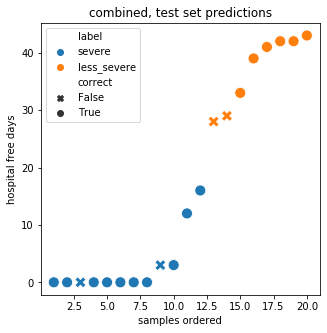

In [317]:
combined_metrics = model_predict_eval(extraTrees_random_combined.best_estimator_, df_dict, 'combined', plot=True)

In [318]:
combined_metrics

{'accuracy': 0.8,
 'recall': 0.8333333333333334,
 'precision': 0.8333333333333334,
 'ave_precision': 0.9453444703444706,
 'f1': 0.8333333333333334,
 'roc_auc': 0.9166666666666667}

dropped columns = 0
measurements used 517
training data shape (81, 517)
accuracy:  0.76, recall: 0.80, precision: 0.73, f1: 0.76


{'accuracy': 0.7619047619047619,
 'recall': 0.8,
 'precision': 0.7272727272727273,
 'ave_precision': 0.8864024864024863,
 'f1': 0.761904761904762,
 'roc_auc': 0.8727272727272726}

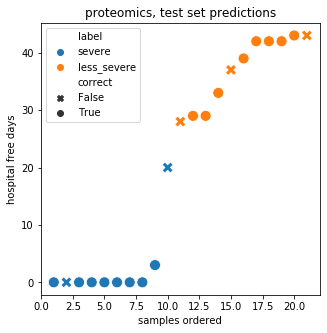

In [319]:
proteomics_metrics = model_predict_eval(extrees_random_prot.best_estimator_, df_dict, 'proteomics', plot=True, savefigure=True)
proteomics_metrics

dropped columns = 0
measurements used 13263
training data shape (80, 13263)
accuracy:  0.80, recall: 0.83, precision: 0.83, f1: 0.83


{'accuracy': 0.8,
 'recall': 0.8333333333333334,
 'precision': 0.8333333333333334,
 'ave_precision': 0.9179864117364119,
 'f1': 0.8333333333333334,
 'roc_auc': 0.8854166666666667}

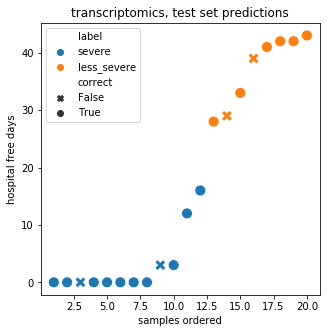

In [320]:
trans_metrics = model_predict_eval(extrees_random_trans.best_estimator_, df_dict, 'transcriptomics', plot=True, savefigure=True)
trans_metrics

dropped columns = 45
measurements used 110
training data shape (81, 110)
accuracy:  0.86, recall: 0.80, precision: 0.89, f1: 0.84


{'accuracy': 0.8571428571428571,
 'recall': 0.8,
 'precision': 0.8888888888888888,
 'ave_precision': 0.7690262515262515,
 'f1': 0.8421052631578948,
 'roc_auc': 0.8727272727272728}

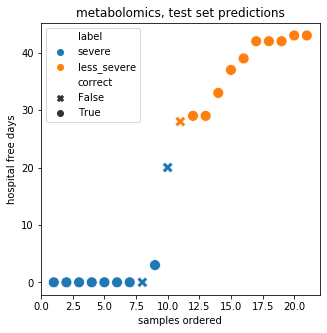

In [321]:
met_metrics = model_predict_eval(extrees_random_met.best_estimator_, df_dict, 'metabolomics', plot=True, savefigure=True)
met_metrics

dropped columns = 2711
measurements used 646
training data shape (81, 646)
accuracy:  0.81, recall: 0.80, precision: 0.80, f1: 0.80


{'accuracy': 0.8095238095238095,
 'recall': 0.8,
 'precision': 0.8,
 'ave_precision': 0.7439822595704949,
 'f1': 0.8000000000000002,
 'roc_auc': 0.7818181818181819}

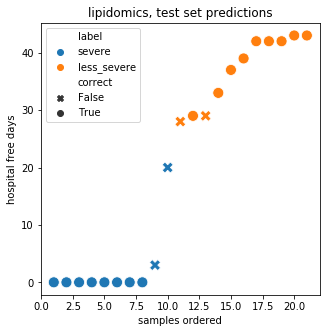

In [322]:
lip_metrics = model_predict_eval(extrees_random_lip.best_estimator_, df_dict, 'lipidomics', plot=True, savefigure=True)
lip_metrics

# ROC AUC curves

dropped columns = 2756
measurements used 14536


C:\Users\jesse\.conda\envs\sklearn\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


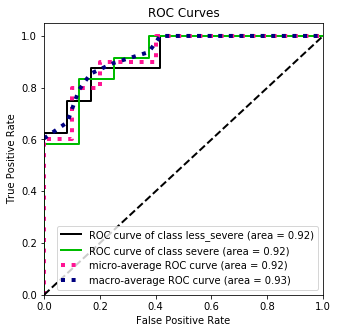

In [313]:
import scikitplot as skplt
import matplotlib.pyplot as plt
DAY_CUTOFF = 24
RANDOM_SEED = 11
dfc = df_dict[dataset]
qrc = quant_range_dict[dataset]
dfc_quant_cols = dfc.columns[:qrc]
prefilter_range = len(dfc.columns)
dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='Unknown')))]
dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='unknown')))]
rangediff = prefilter_range - len(dfc.columns)
print( 'dropped columns = '+ str(rangediff))
qr_filt = qrc - rangediff
print('measurements used ' + str(qr_filt))
df = dfc[dfc['COVID']==1]
X = df[df.columns[:qr_filt]]
df = df.assign(dayclass=np.zeros(len(df)))
df.loc[df['Hospital_free_days_45']<DAY_CUTOFF, 'dayclass'] = 'severe'
df.loc[df['Hospital_free_days_45']>=DAY_CUTOFF, 'dayclass'] = 'less_severe'
y = df['dayclass']
hfd = df['Hospital_free_days_45']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
X_train, X_test, hfd_train, hfd_test = train_test_split(X, hfd, test_size = 0.2, random_state = RANDOM_SEED)

pred_probs = extraTrees_random_combined.best_estimator_.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, pred_probs)

#plt.savefig('combined_ROC_AUC_testset.svg')

## last part is variable importance measure!

In [290]:
var_importances = extraTrees_random_combined.best_estimator_.feature_importances_

In [293]:
X.columns.values

array(['A0A024R6I7;A0A0G2JRN3', 'A0A075B6H9', 'A0A075B6I0', ..., 'ZYX',
       'ZZEF1', 'ZZZ3'], dtype=object)

In [295]:
len(X.columns)

14536

In [296]:
len(var_importances)

14536

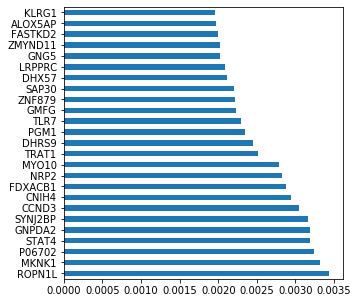

In [306]:
plt.rcParams['figure.figsize'] = 5,5
(pd.Series(var_importances, index=X.columns)
   .nlargest(25)
   .plot(kind='barh')) 

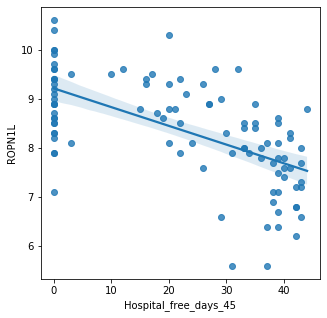

In [305]:
plt.rcParams['figure.figsize'] = 5,5
sns.regplot(dfc_covid['Hospital_free_days_45'],X['ROPN1L'])

In [356]:
def variable_importance_by_ome(dataset, model, df_dict, quant_range_dict, plot=True, write=True):
    dfc = df_dict[dataset]
    qrc = quant_range_dict[dataset]
    dfc_quant_cols = dfc.columns[:qrc]
    prefilter_range = len(dfc.columns)
    dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='Unknown')))]
    dfc = dfc[dfc.columns.drop(list(dfc.filter(regex='unknown')))]
    rangediff = prefilter_range - len(dfc.columns)
    print( 'dropped columns = '+ str(rangediff))
    qr_filt = qrc - rangediff
    print('measurements used ' + str(qr_filt))
    df = dfc[dfc['COVID']==1]
    X = df[df.columns[:qr_filt]]
    if(plot):
        plt.rcParams['figure.figsize'] = 5,5
        (pd.Series(model.feature_importances_, index=X.columns)
           .nlargest(10)
           .plot(kind='barh')) 
        plt.savefig(dataset+'_feature_importance.svg', bbox_inches = "tight")
    if(write):
        pd.DataFrame({'feature importance':model.feature_importances_, 
              'biomolecule':X.columns}).to_csv(dataset+'_feature_importance.csv')
    

dropped columns = 2756
measurements used 14536


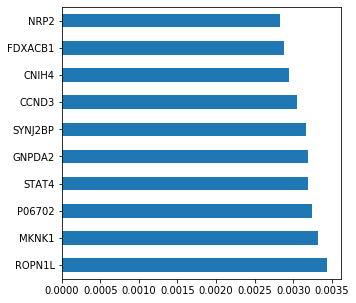

In [357]:
variable_importance_by_ome('combined', extraTrees_random_combined.best_estimator_, df_dict, quant_range_dict)

dropped columns = 0
measurements used 517


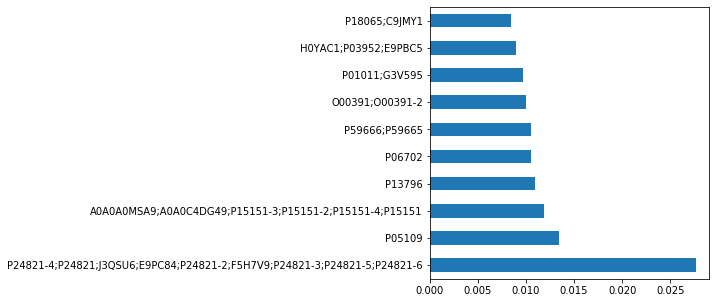

In [358]:
variable_importance_by_ome('proteomics', extrees_random_prot.best_estimator_, df_dict, quant_range_dict)

dropped columns = 2711
measurements used 646


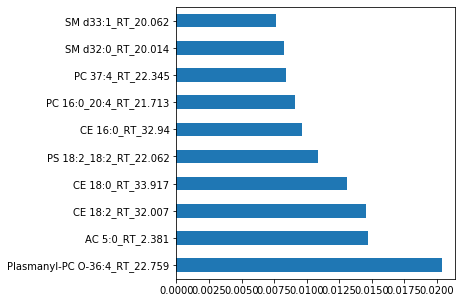

In [359]:
variable_importance_by_ome('lipidomics', extrees_random_lip.best_estimator_, df_dict, quant_range_dict)


dropped columns = 45
measurements used 110


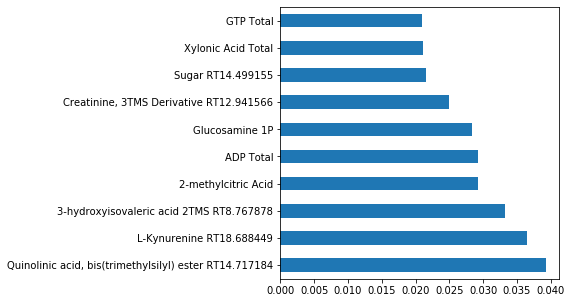

In [360]:
variable_importance_by_ome('metabolomics', extrees_random_met.best_estimator_, df_dict, quant_range_dict)


dropped columns = 0
measurements used 13263


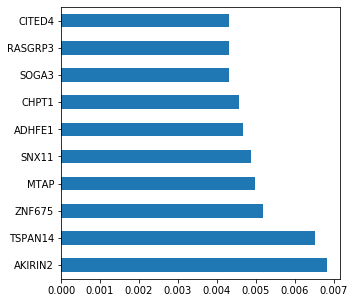

In [361]:
variable_importance_by_ome('transcriptomics', extrees_random_trans.best_estimator_, df_dict, quant_range_dict)

# save best model from each random search



dropped columns = 2756
measurements used 14536
training data shape (80, 14536)
accuracy:  0.80, recall: 0.83, precision: 0.83, f1: 0.83
0.8


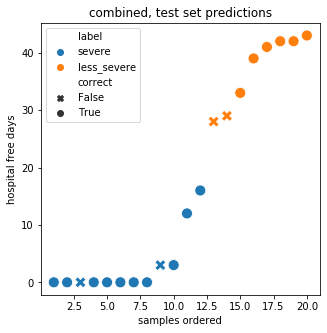

In [326]:
# save the model to disk
pre_result = extraTrees_random_combined.best_estimator_.score(X_test, y_test)
model_predict_eval(extraTrees_random_combined.best_estimator_, df_dict, 'combined', plot=True, savefigure=False)
print(pre_result)
filename = 'final_combined_model.sav'
pickle.dump(extraTrees_random_combined.best_estimator_, open(filename, 'wb'))
 
# some time later...
 


0.8
dropped columns = 2756
measurements used 14536
training data shape (80, 14536)
accuracy:  0.80, recall: 0.83, precision: 0.83, f1: 0.83


{'accuracy': 0.8,
 'recall': 0.8333333333333334,
 'precision': 0.8333333333333334,
 'ave_precision': 0.9453444703444706,
 'f1': 0.8333333333333334,
 'roc_auc': 0.9166666666666667}

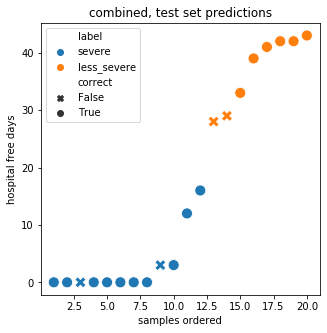

In [327]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model_predict_eval(loaded_model, df_dict, 'combined', plot=True, savefigure=False)

In [328]:
filename = 'final_lipidomics_model.sav'
pickle.dump(extrees_random_lip.best_estimator_, open(filename, 'wb'))


In [329]:
filename = 'final_metabolomics_model.sav'
pickle.dump(extrees_random_met.best_estimator_, open(filename, 'wb'))

In [330]:
filename = 'final_proteomics_model.sav'
pickle.dump(extrees_random_prot.best_estimator_, open(filename, 'wb'))

In [331]:
filename = 'final_transcriptomics_model.sav'
pickle.dump(extrees_random_trans.best_estimator_, open(filename, 'wb'))

In [334]:
## fix protein names?
from sqlalchemy import create_engine, MetaData, Table, select, join
import re


# SQLite path
db_path = 'sqlite:///C:\\covid_proteomics\\Covid-19 Study DB.sqlite'
# Create an engine that connects to the Covid-19 Study DB.sqlite file: engine
engine = create_engine(db_path)

# Establish connection
connection = engine.connect()
biomolecule_name_dict = {}
query = "SELECT * from metadata"
# get biomolecule names
metadata_df = pd.read_sql_query(query, connection)

fasta_header_df = metadata_df[metadata_df['metadata_type'] == 'fasta_header']
fasta_header_df = fasta_header_df.astype({'biomolecule_id': 'str'})
metadata_df

metadata_id  biomolecule_id     metadata_type  \
0                1               1  Remove_duplicate   
1                2               1              HMDB   
2                3               1             Class   
3                4               1      Larger_class   
4                5               1              KEGG   
...            ...             ...               ...   
46184        46185            8333      fasta_header   
46185        46186            8334      fasta_header   
46186        46187            8335      fasta_header   
46187        46188            8336      fasta_header   
46188        46189            8337      fasta_header   

                                          metadata_value  
0                                                         
1                                                         
2                                                         
3                                                         
4                                                         
...                                                  ...  
46184  tr|U3KPS2|U3KPS2_HUMAN Myeloblastin OS=Homo sa...  
46185  tr|U3KQK0|U3KQK0_HUMAN Histone H2B OS=Homo sap...  
46186  tr|V9GY83|V9GY83_HUMAN Low affinity immunoglob...  
46187  tr|V9GYM3|V9GYM3_HUMAN Apolipoprotein A-II OS=...  
46188  tr|X6R8F3|X6R8F3_HUMAN Neutrophil gelatinase-a...  

[46189 rows x 4 columns]

In [ ]:
for biomolecule_id in biomolecule_name_dict:
    # update to gene name
    #gene_name = gene_name_df[gene_name_df['biomolecule_id']==biomolecule_id]['metadata_value'].values[0]
    fasta_header = fasta_header_df[fasta_header_df['biomolecule_id']==biomolecule_id]['metadata_value'].values[0]
    fasta_header = re.search("\s(.*?)\sO[SX]=", fasta_header).group(1)
    biomolecule_name_dict[biomolecule_id] = fasta_header